## 1. Introduction
This notebook analyzes the functional and sequence relationships from the study on bacteria from operational heating and cooling water systems, primarily in Germany. Using 16S rRNA data (bootstrap-validated from Notebook 5), this analysis employs PICRUSt2 to predict metabolic functions and compare functional profiles between different bacterial groups.

### Analysis Approaches
The notebook start by importing libraries, preparing the directories paths in section 1, section 2 prepares the data for the picrust pipeline on fasta, biom formates. Section 3-6 shows the process utilising directly algoritm for advance computer capabilities. The author approach utilises the Galaxy platform, where the original product files are found https://usegalaxy.eu/u/magicalex238/h/picrust2-functional. The results are imported on section 7 where a broad analysis is done on the global data exploring pathways,algoritm implementation, top general pathways and reactions. Section 8 involves retrieving the protein names for the granular data (EC contribution, ECcontri) from Galaxy results and for that utilises Uniprot Database. ECcontri_Uniprot data is analysed for the point of cutoff where the protein abundance has biological activity (Knee_abundance) for later use. Section 9 import several known and autoritative databases that are use to compile a new database (EC_records) comprising enzyme_names, mechanisms, pathways, metal_involved, protein hierarchi, reactions, amongst others. Then enriches the granular data with the newly created EC_records, put identifiers idx and introduce Sites and Categories. Section 10 is dedicated to the Filtering of protein-genus pairs pipeline on ECcontri_Uniprot_enriched. The data is classified by patterns, pathways (housekeeping, niche and mixed), separated between increasing, decreasing and mixed patterns, and the increasing patterns pairs are taken to the next step. The data is then prioritized by biological and statistical significance (prioritized_markers). Lastly is filtered with the knee abundance for biological activity (balanced_markers) and divided on marker_groups.
Then Section 11 visualise the results, made some clustering between related pairs and choses the top 10 markers to bring into the machine learning compendium repository where is join with the physicochemical data for a more comprensive prediction on corrosion by microbiologically induced corrosion.

### Directory Structure:
``` text
Sequence Analysis and Functional Prediction Pipeline
├── Introduction  
│   ├── 16S rRNA Data (bootstrap-validated)
│   └── imports, paths, preparation data
└── Analysis Approaches  
    ├── Direct Algorithm (Sections 3-6)  
    └── Galaxy Platform Analysis                             
         ├── Section 7: Broad Analysis (pathways, reactions)
         ├── Section 8: Protein Name Retrieval, data preparation
         ├── Section 9: Database Creation and Data enrichment
         │       ├──  EC_records: enzyme_names, mechanisms, pathways,
         │       └──  metal_involved, reactions, hierarchy...
         ├── Section 10: Filtering Protein-Genus Pairs pipeline
         │       ├── patterns_data, classified_results,
         │       └── prioritized_results...
         └── Section 11:Visualization & Machine Learning  
                 ├── Clustering related pairs  
                 ├── Top 10 markers  
                 └── further to ML (corrosion prediction)   

Picrust2 works using its reference database that was installed with the package   ~/miniconda3/envs/picrust2/lib/python3.9/site-packages/picrust2/default_files/prokaryotic/pro_ref

About picrust2  
https://evomics.org/wp-content/uploads/2015/01/presentation_evomics-05-picrust_01-18-15.pdf



# 2. Loading and Preparing the Data

## 2.1 Colab Initialisation

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages

In [ ]:
import os
#os.path.exists('/content/drive/MyDrive')

from google.colab import drive
drive.flush_and_unmount()

Drive not mounted, so nothing to flush and unmount.


In [2]:
# Colab specific
from google.colab import drive
from google.colab import files
import os

drive.mount('/content/drive')

#change the path
os.chdir('/content/drive/MyDrive/MIC/data_picrust')

Mounted at /content/drive


In [3]:
# Making sure to use same python version for compatibility
!sudo apt-get update -y
!sudo apt-get install python3.10
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.10 1
!python --version

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,381 kB]
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,683 kB]
Get:13 https://r2u.stat.illinois.edu/ubuntu jamm

### Kaggle / Colab

In [ ]:
'''!pip install psutil
import psutil
!pip install biopython
!pip install biom-format
!pip install fuzzywuzzy'''

In [ ]:
from IPython import get_ipython
from IPython.display import display
%pip install umap-learn
!pip install lxml pandas
!pip install pyarrow
!pip install openpyxl
!pip install scipy
!pip install python-Levenshtein
!pip install -U kaleido
!pip install statsmodels
!pip install kneed
!pip install natsort
!python3 --version
!pip install adjustText

Note: you may need to restart the kernel to use updated packages.
Python 3.10.16


# 2.2. Importing Libraries,  Making Directories and Loading Data

In [1]:
# Standard library imports
import os
import sys
import ast
import subprocess
import logging
import time
from datetime import datetime
import shutil
from io import StringIO
from pathlib import Path
import re

# Data processing and analysis
import pandas as pd
import numpy as np
import openpyxl
import seaborn as sns
import networkx as nx
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
from matplotlib.colors import to_rgba, LinearSegmentedColormap
import matplotlib.patches as mpatches
from dash import Dash, dcc, html, Input, Output, callback

# Machine learning and statistical analysis
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA, NMF
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.manifold import TSNE
import umap
import scipy
from scipy import stats
from scipy.cluster.hierarchy import linkage, dendrogram
import scipy.cluster.hierarchy as sch
from statsmodels.stats.multitest import multipletests
from scipy.spatial.distance import pdist
from scipy.stats import spearmanr, kruskal, mannwhitneyu
from kneed import KneeLocator
from scipy.signal import savgol_filter
from community import community_louvain
#from joblib import Parallel, delayed

# Bioinformatics
#from Bio import SeqIO
#from Bio.Seq import Seq
#from Bio.SeqRecord import SeqRecord
#from biom import Table, load_table
#from biom.util import biom_open
#import xml.etree.ElementTree as ET
#from lxml import etree
# Web and data retrieval
#import requests

# Utility libraries
import gzip
import random
from natsort import natsorted
from typing import Dict, List, Tuple, Set, Optional
import pickle
import gc
import joblib
import h5py
import os
import json
import pyarrow.parquet as pq

os.environ['DISPLAY'] = ':0'

In [2]:
# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s')

# Base Paths
if "google.colab" in sys.modules:
    base_dir = Path("/content/drive/MyDrive/MIC/data_visual")
else:
    base_dir = Path("/home/beatriz/MIC/2_Micro/data_visual")

#base dir for small files to git
base_dir = Path("/home/beatriz/MIC/2_Micro/data_visual")
base_dir.mkdir(parents=True, exist_ok=True)

abundance_excel= Path("/home/beatriz/MIC/2_Micro/data_Ref/merged_to_sequence.xlsx")

# Create output directory if it doesn't exist
output_base = base_dir / "output_base"
output_base.mkdir(parents=True, exist_ok=True)
# large files hosted instead in kaggle
large_dir = Path("/home/beatriz/MIC")
large_dir.mkdir(parents=True, exist_ok=True)

# Directory to output large files 
output_large = large_dir / "output_large"
output_large.mkdir(parents=True, exist_ok=True)
'''
# for colab
# Create output directory if it doesn't exist
base_dir = Path("/content/drive/MyDrive/MIC/data_visual/")
base_dir.mkdir(parents=True, exist_ok=True)
abundance_excel= Path("/content/drive/MyDrive/MIC/data_picrust/merged_to_sequence.xlsx")

output_base = base_dir  # Separate output directory
output_base.mkdir(parents=True, exist_ok=True)
large_dir = Path("/content/drive/MyDrive/MIC/")
large_dir.mkdir(parents=True, exist_ok=True)

# Directory to output large files
output_large = large_dir / "output_large"
output_large.mkdir(parents=True, exist_ok=True)

# For Kaggle work
# Input datasets (read-only in Kaggle)
base_dir = Path("/kaggle/input/dataset_results_picrust") #base dir for small files to git /kaggle/input/new-picrust

# Files in small input directory
abundance_excel= base_dir / "merged_to_sequence.xlsx" # inside input small sizes input

# Output for small files has to be changed for vscode no to push it to git
output_base = Path("/kaggle/working/output_base")
output_base.mkdir(parents=True, exist_ok=True)

# Directory to output large files 
large_dir =  Path("/kaggle/working/")

# Directory to output large files 
output_large = large_dir / "output_large"
output_large.mkdir(parents=True, exist_ok=True)'''

'\n# for colab\n# Create output directory if it doesn\'t exist\nbase_dir = Path("/content/drive/MyDrive/MIC/data_visual/")\nbase_dir.mkdir(parents=True, exist_ok=True)\nabundance_excel= Path("/content/drive/MyDrive/MIC/data_picrust/merged_to_sequence.xlsx")\n\noutput_base = base_dir  # Separate output directory\noutput_base.mkdir(parents=True, exist_ok=True)\nlarge_dir = Path("/content/drive/MyDrive/MIC/")\nlarge_dir.mkdir(parents=True, exist_ok=True)\n\n# Directory to output large files\noutput_large = large_dir / "output_large"\noutput_large.mkdir(parents=True, exist_ok=True)\n\n# For Kaggle work\n# Input datasets (read-only in Kaggle)\nbase_dir = Path("/kaggle/input/dataset_results_picrust") #base dir for small files to git /kaggle/input/new-picrust\n\n# Files in small input directory\nabundance_excel= base_dir / "merged_to_sequence.xlsx" # inside input small sizes input\n\n# Output for small files has to be changed for vscode no to push it to git\noutput_base = Path("/kaggle/workin

In [3]:
# Integrated taxa from origin genus as headers with levels 6 for the genera, 7 for the GID, muss be cleaned
Integrated_T = pd.read_excel(abundance_excel, sheet_name='core_check_usual_taxa', header=[0,1,2,3,4,5,6,7], engine ='openpyxl')
# Drop first row (index 0) and first column in one chain
Integrated_T = Integrated_T.drop(index=0).drop(Integrated_T.columns[0], axis=1)
Integrated_T= Integrated_T.astype({'Sites': str})
Integrated_T['Sites'] = Integrated_T['Sites'].fillna('Source')
# Remove 'Unnamed' level names
Integrated_T.columns = Integrated_T.columns.map(lambda x: tuple('' if 'Unnamed' in str(level) else level for level in x))
# Changing dtypes to category whiles respecting structure
Integrated_T["Category"] = Integrated_T["Category"].astype("Int64")
Integrated_T= Integrated_T.set_index("Sites")
pre_Integrated = Integrated_T.T

In [ ]:
'''# Recomenzar
eccontri_path = output_large / 'ECcontri_Uniprot_enriched.parquet'
ECcontri_Uniprot_enriched = pd.read_parquet(eccontri_path)'''

In [4]:
# Define category dict outside
category_dict = Integrated_T.T.iloc[0, 0:-1].to_dict()

# Define colors and categories
category_colors = {1: '#008800',  # Dark green
                   2: '#FF8C00',  # Dark orange
                   3: '#FF0000'}   # Red

categories_labels = {1: 'Normal Operation',
              2: 'Early Warning',
              3: 'System Failure'}

In [5]:
parquet_dir = Path(os.path.join(output_large, "corrosion_markers_parquet"))
# List all Parquet files in directory
parquet_files = list(parquet_dir.glob("*.parquet"))

# Load all files into a dictionary of DataFrames
corrosion_report= {file.stem: pd.read_parquet(file) for file in parquet_files}

# Check available DataFrames
for name, df in corrosion_report.items():
    print(f"{name}: {df.shape}")

group_mechanism_acid_production: (414, 44)
group_metal_s: (640, 44)
group_top_markers: (500, 44)
group_metal_manganese: (276, 44)
group_tier_unknown: (9, 44)
integrated_results: (49711, 31)
group_high_confidence: (645, 44)
group_significant_markers: (162, 44)
group_mechanism_o2_consumption: (78, 44)
classified_results: (49711, 33)
prioritized_markers: (28907, 42)
group_tier_niche-specific: (528, 44)
balanced_markers: (647, 44)
group_high_metals_relevance: (246, 44)
group_high_mechanism_relevance: (360, 44)
group_metal_sulfur: (348, 44)
group_high_corrosion_relevance: (201, 44)
group_mechanism_sulfur_metabolism: (321, 44)
group_mechanism_biofilm_formation: (149, 44)
group_metal_copper: (37, 44)
group_mechanism_direct_eet: (449, 44)
group_high_tier_relevance: (528, 44)
group_very_high_specificity: (30, 44)
group_mechanism_h2_consumption: (570, 44)
group_high_specificity: (30, 44)
group_medium_confidence: (647, 44)
group_tier_mixed: (110, 44)
group_metal_involved: (647, 44)
pattern_data: 

roup_mechanism_acid_production: (414, 44)  
group_metal_s: (640, 44)  
group_top_markers: (500, 44)  
group_metal_manganese: (276, 44)  
group_tier_unknown: (9, 44)  
integrated_results: (49711, 31)  
group_high_confidence: (645, 44)  
group_significant_markers: (162, 44)  
group_mechanism_o2_consumption: (78, 44)  
classified_results: (49711, 33)  
prioritized_markers: (28907, 42)  
group_tier_niche-specific: (528, 44)  
balanced_markers: (647, 44)  
group_high_metals_relevance: (246, 44)  
group_high_mechanism_relevance: (360, 44)
group_metal_sulfur: (348, 44)
group_high_corrosion_relevance: (201, 44)
group_mechanism_sulfur_metabolism: (321, 44)
group_mechanism_biofilm_formation: (149, 44)
group_metal_copper: (37, 44)
group_mechanism_direct_eet: (449, 44)
group_high_tier_relevance: (528, 44)
group_very_high_specificity: (30, 44)
group_mechanism_h2_consumption: (570, 44)
group_high_specificity: (30, 44)
group_medium_confidence: (647, 44)
group_tier_mixed: (110, 44)
group_metal_involved: (647, 44)
pattern_data: (49711, 20)
group_metal_iron: (478, 44)

In [86]:
# Main analysis dataframes
pattern_data = corrosion_report["pattern_data"]
integrated_results = corrosion_report["integrated_results"]
classified_results = corrosion_report["classified_results"]
prioritized_markers = corrosion_report["prioritized_markers"]
balanced_markers = corrosion_report["balanced_markers"]

# Marker groups
top_markers = corrosion_report["group_top_markers"]
high_confidence = corrosion_report["group_high_confidence"]
significant_markers = corrosion_report["group_significant_markers"]
medium_confidence = corrosion_report["group_medium_confidence"]
very_high_specif = corrosion_report["group_very_high_specificity"]
high_specif = corrosion_report["group_high_specificity"]
high_metal_relv = corrosion_report["group_high_metals_relevance"]
high_mechanism_relv = corrosion_report["group_high_mechanism_relevance"]
high_tier_relv = corrosion_report["group_high_tier_relevance"]
high_corrosion_relv = corrosion_report["group_high_corrosion_relevance"]

# Mechanism-specific groups
mechanism_biofilm_formation = corrosion_report["group_mechanism_biofilm_formation"]
mechanism_h2_consumption = corrosion_report["group_mechanism_h2_consumption"]
mechanism_direct_eet = corrosion_report["group_mechanism_direct_eet"]
mechanism_sulfur_metabolism = corrosion_report["group_mechanism_sulfur_metabolism"]
mechanism_acid_production = corrosion_report["group_mechanism_acid_production"]
mechanism_o2_consumption = corrosion_report["group_mechanism_o2_consumption"]

# Metal-related groups
metal_involved = corrosion_report["group_metal_involved"]
metal_iron = corrosion_report["group_metal_iron"]
metal_copper = corrosion_report["group_metal_copper"]
metal_manganese = corrosion_report["group_metal_manganese"]
metal_s = corrosion_report["group_metal_s"]
metal_sulfur = corrosion_report["group_metal_sulfur"]

# Pathway classification groups
tier_niche_specific = corrosion_report["group_tier_niche-specific"]
tier_mixed = corrosion_report["group_tier_mixed"]
tier_unknown = corrosion_report["group_tier_unknown"]

# 3. General Visualising Corrosion Protein-Genus Pairs Analysis

## 3.1. Multiple Visualizations of Functional Data across Risk Categories

In [23]:
def plot_multiview_functional_landscape(prioritized_markers, top_n=25):
    """
    Creates multiple visualizations of functional data across risk categories,
    using the 'Category' column for coloring.

    Args:    prioritized_markers (DataFrame): DataFrame containing marker data.
             top_n (int): Number of top markers to include.
    Returns:   matplotlib figure with multiple subplots showing different aspects of the data.
    """

    # Define colors and categories
    category_colors = {
        1: '#008800',  # Dark green - Normal Operation
        2: '#FF8C00',  # Dark orange - Early Warning
        3: '#FF0000'   # Red - System Failure
    }

    categories_labels = {
        1: 'Normal Operation',
        2: 'Early Warning',
        3: 'System Failure'
    }
    # Select top markers by score
    top_markers = prioritized_markers.sort_values('combined_score', ascending=False).head(top_n)
    
    # Ensure Category is integer type to prevent mapping issues
    top_markers['Category'] = top_markers['Category'].astype(int)

    # Create figure with multiple subplots
    fig = plt.figure(figsize=(20, 16))

    # 1. Pathway abundance by category (top left)
    ax1 = plt.subplot2grid((2, 2), (0, 0))

    # Process mechanisms data for mean categories
    mech_by_mean = []
    for _, row in top_markers.iterrows():
        if isinstance(row.get('corrosion_mechanisms'), str) and row['corrosion_mechanisms'] and pd.notna(row['norm_abund_contri']):
            mechanisms = [m.strip() for m in row['corrosion_mechanisms'].split(';')]
            
            # Find highest mean category for this row
            mean_cat1 = row.get('mean_cat1', 0) 
            mean_cat2 = row.get('mean_cat2', 0)
            mean_cat3 = row.get('mean_cat3', 0)
            
            # Create entries for each category to ensure all three appear in legend
            for mech in mechanisms:
                if mech:  # Ensure mechanism is not empty
                    # Add entry for each category with its corresponding mean value
                    mech_by_mean.append({
                        'Mechanism': mech,
                        'Mean_Category': 'mean_cat1',  # Normal Operation
                        'Abundance': mean_cat1 * row['norm_abund_contri']
                    })
                    mech_by_mean.append({
                        'Mechanism': mech,
                        'Mean_Category': 'mean_cat2',  # Early Warning
                        'Abundance': mean_cat2 * row['norm_abund_contri']
                    })
                    mech_by_mean.append({
                        'Mechanism': mech,
                        'Mean_Category': 'mean_cat3',  # System Failure
                        'Abundance': mean_cat3 * row['norm_abund_contri']
                    })
    
    # Convert to DataFrame
    mean_mech_df = pd.DataFrame(mech_by_mean)
    
    # Define colors for mean categories
    mean_colors = {
        'mean_cat1': '#008800',  # Dark green - Normal Operation
        'mean_cat2': '#FF8C00',  # Dark orange - Early Warning
        'mean_cat3': '#FF0000'   # Red - System Failure
    }
    
    # Define category labels for the legend
    mean_labels = {
        'mean_cat1': 'Normal Operation (Mean)',
        'mean_cat2': 'Early Warning (Mean)',
        'mean_cat3': 'System Failure (Mean)'
    }
    
    if not mean_mech_df.empty:
        # Aggregate by mechanism and mean category
        agg_mean_mech = mean_mech_df.groupby(['Mechanism', 'Mean_Category'])['Abundance'].sum().reset_index()
        
        # Get top mechanisms by total abundance across all categories
        top_mechanisms = agg_mean_mech.groupby('Mechanism')['Abundance'].sum().nlargest(10).index
        agg_mean_mech = agg_mean_mech[agg_mean_mech['Mechanism'].isin(top_mechanisms)]
        
        # Create the plot with mean category colors
        sns.barplot(
            data=agg_mean_mech,
            x='Abundance',
            y='Mechanism',
            hue='Mean_Category',
            palette=mean_colors,
            ax=ax1
        )
        
        # Update legend with readable mean category labels
        handles, labels = ax1.get_legend_handles_labels()
        ax1.legend(handles=handles, labels=[mean_labels[label] for label in labels])
        ax1.set_title(f"Top Corrosion Mechanisms - {name}\nBy Mean Categories", fontsize=14)
        ax1.set_xlabel('Abundance', fontsize=12)
        ax1.set_ylabel('Mechanism', fontsize=12)
    else:
        ax1.text(0.5, 0.5, "No mechanism data available", ha='center', va='center', fontsize=14)
        ax1.set_title('Top Corrosion Mechanisms by Mean Category', fontsize=14)

    # 2. Heatmap of top proteins across categories (top right)
    ax2 = plt.subplot2grid((2, 2), (0, 1))

    # Check if we have required columns for the heatmap
    required_cols = ['mean_cat1', 'mean_cat2', 'mean_cat3', 'Genus', 'protein_name', 'norm_abund_contri']
    has_required_cols = all(col in top_markers.columns for col in required_cols)

    if has_required_cols and not top_markers.empty:
        # Create descriptive row labels
        protein_labels = []
        for _, row in top_markers.iterrows():
            genus = row.get('Genus', 'Unknown')
            protein_name = row.get('protein_name', 'Unknown')
            label = f"{genus} - {protein_name[:20]}..." if (isinstance(protein_name, str) and len(protein_name) > 20) else f"{genus} - {protein_name}"
            protein_labels.append(label)

        # Initialize a DataFrame to hold continuous values per category
        # Use numeric categories (1, 2, 3) instead of descriptive labels
        heatmap_data = pd.DataFrame(index=top_markers.index, columns=[1, 2, 3])
        
        # For each marker, compute the contribution for each category
        for idx, row in top_markers.iterrows():
            # Sum the means to get total abundance for this marker across categories
            total = row['mean_cat1'] + row['mean_cat2'] + row['mean_cat3']
            if total > 0:
                # Proportionally distribute the overall normalized abundance contribution
                heatmap_data.at[idx, 1] = (row['mean_cat1'] / total) * row['norm_abund_contri']
                heatmap_data.at[idx, 2] = (row['mean_cat2'] / total) * row['norm_abund_contri']
                heatmap_data.at[idx, 3] = (row['mean_cat3'] / total) * row['norm_abund_contri']
            else:
                # If total is zero, use zeros to avoid division errors
                heatmap_data.at[idx, 1] = 0
                heatmap_data.at[idx, 2] = 0
                heatmap_data.at[idx, 3] = 0

        # Limit to first 50 proteins to avoid overcrowding
        n_rows = min(50, len(heatmap_data))
        heatmap_data = heatmap_data.iloc[:n_rows]
        protein_labels = protein_labels[:n_rows]

        # Replace any remaining NaN values with 0 to avoid matplotlib warnings
        heatmap_data = heatmap_data.fillna(0)

        # Optionally, scale each row to percentages if desired
        for idx in heatmap_data.index:
            row_max = heatmap_data.loc[idx].max()
            if row_max > 0:
                heatmap_data.loc[idx] = (heatmap_data.loc[idx] / row_max * 100).round(1)

        # Create the heatmap using the continuous (non-binary) data with numeric category labels
        sns.heatmap(
            heatmap_data,
            cmap='Blues',
            annot=True,
            fmt='.1f',
            linewidths=0.5,
            yticklabels=protein_labels,
            xticklabels=['Category 1', 'Category 2', 'Category 3'],  # Consistent numeric labeling
            ax=ax2,
            vmin=0,
            vmax=100 
        )

        ax2.set_title('Protein Normalized Abundance Contributions by Category', fontsize=14)
    else:
        ax2.text(0.5, 0.5, "Insufficient data for heatmap", ha='center', va='center', fontsize=14)
        ax2.set_title('Protein Normalized Abundance Contributions by Category', fontsize=14)

    # 3. Pattern alignment with risk categories (bottom left)
    ax3 = plt.subplot2grid((2, 2), (1, 0))

    # Check for required columns

    if all(col in top_markers.columns for col in ['mean_cat1', 'mean_cat2', 'mean_cat3', 'Genus', 'protein_name', 'specificity', 'prevalence']) and not top_markers.empty:
        # Use specificity or prevalence score instead of correlation
        # Choose the metric that better differentiates your data
        top_markers['Category_Alignment'] = top_markers['specificity'] * top_markers['prevalence']

        # Filter out rows with NaN values
        valid_metrics = top_markers.dropna(subset=['Category_Alignment']).copy()

        if not valid_metrics.empty:
            # Sort by alignment metric and select top + bottom 5 (or fewer if not enough data)
            n_to_select = min(5, len(valid_metrics) // 2)  # ensure we don't try to select more than available

            top_aligned = valid_metrics.sort_values('Category_Alignment', ascending=False).head(n_to_select)
            low_aligned = valid_metrics.sort_values('Category_Alignment').head(n_to_select)

            # Combine the high and low alignment metrics
            metric_markers = pd.concat([top_aligned, low_aligned])

            # Create new indices to avoid alignment issues
            metric_markers = metric_markers.reset_index(drop=True)

            # Create labels
            metric_labels = []
            for _, row in metric_markers.iterrows():
                genus = row.get('Genus', 'Unknown')
                protein_name = row.get('protein_name', 'Unknown')
                if isinstance(protein_name, str) and len(protein_name) > 15:
                    label = f"{genus} - {protein_name[:15]}..."
                else:
                    label = f"{genus} - {protein_name}"
                metric_labels.append(label)

            # Create a color map based on alignment values
            # Higher values (better category alignment) are blue
            colors = ['red' if c < metric_markers['Category_Alignment'].median() else 'blue' for c in metric_markers['Category_Alignment']]

            # Create a basic matplotlib horizontal bar plot
            bars = ax3.barh(
                range(len(metric_markers)),
                metric_markers['Category_Alignment'].values,
                color=colors
            )

            # Set the y-tick labels manually
            ax3.set_yticks(range(len(metric_labels)))
            ax3.set_yticklabels(metric_labels)

            ax3.axvline(x=metric_markers['Category_Alignment'].median(), color='gray', linestyle='--')
            ax3.set_title('Proteins with Strongest Category Alignment', fontsize=14)
            ax3.set_xlabel('Category Alignment Score (Specificity × Prevalence)', fontsize=12)
            ax3.set_ylabel('')
        else:
            ax3.text(0.5, 0.5, "No valid alignment data", ha='center', va='center', fontsize=14)
            ax3.set_title('Proteins with Strongest Category Alignment', fontsize=14)
    else:
        ax3.text(0.5, 0.5, "Insufficient data for pattern analysis", ha='center', va='center', fontsize=14)
        ax3.set_title('Proteins with Strongest Category Alignment', fontsize=14)
    # 4. Genus distribution across categories (bottom right)
    ax4 = plt.subplot2grid((2, 2), (1, 1))

    # Check for required columns
    if all(col in top_markers.columns for col in ['mean_cat1', 'mean_cat2', 'mean_cat3', 'Genus']) and not top_markers.empty:
        # Group by genus and calculate mean abundance in each category
        genus_abundance = top_markers.groupby('Genus').agg({
            'mean_cat1': 'mean',
            'mean_cat2': 'mean',
            'mean_cat3': 'mean'
        }).reset_index()

        # Rename columns for melting
        genus_abundance.columns = ['Genus', 'Category 1', 'Category 2', 'Category 3']

        # Calculate total abundance and get top genera
        genus_abundance['Total'] = genus_abundance['Category 1'] + genus_abundance['Category 2'] + genus_abundance['Category 3']
        n_genera = min(12, len(genus_abundance))
        top_genera = genus_abundance.sort_values('Total', ascending=False).head(n_genera)

        # Melt for plotting
        genera_plot = top_genera.melt(
            id_vars=['Genus'],
            value_vars=['Category 1', 'Category 2', 'Category 3'],
            var_name='Category',
            value_name='Abundance'
        )

        # Map categories to labels
        genera_plot['Category'] = genera_plot['Category'].map({
            'Category 1': categories_labels[1],
            'Category 2': categories_labels[2],
            'Category 3': categories_labels[3]
        })

        # Create the plot
        sns.barplot(
            data=genera_plot,
            x='Genus',
            y='Abundance',
            hue='Category',
            palette=[category_colors[1], category_colors[2], category_colors[3]],
            ax=ax4
        )

        ax4.set_title('Top Genera Abundance by Risk Category', fontsize=14)
        ax4.set_xlabel('Genus', fontsize=12)
        ax4.set_ylabel('Mean Abundance', fontsize=12)
        ax4.tick_params(axis='x', rotation=45)
    else:
        ax4.text(0.5, 0.5, "Insufficient genus data", ha='center', va='center', fontsize=14)
        ax4.set_title('Top Genera Abundance by Risk Category', fontsize=14)

    # Overall title
    plt.suptitle('Functional MIC Landscape on balanced_markers', fontsize=18, y=0.98)

    plt.tight_layout(rect=[0, 0, 1, 0.96])

    return fig

/tmp/ipykernel_50526/2058062186.py:152: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  heatmap_data = heatmap_data.fillna(0)


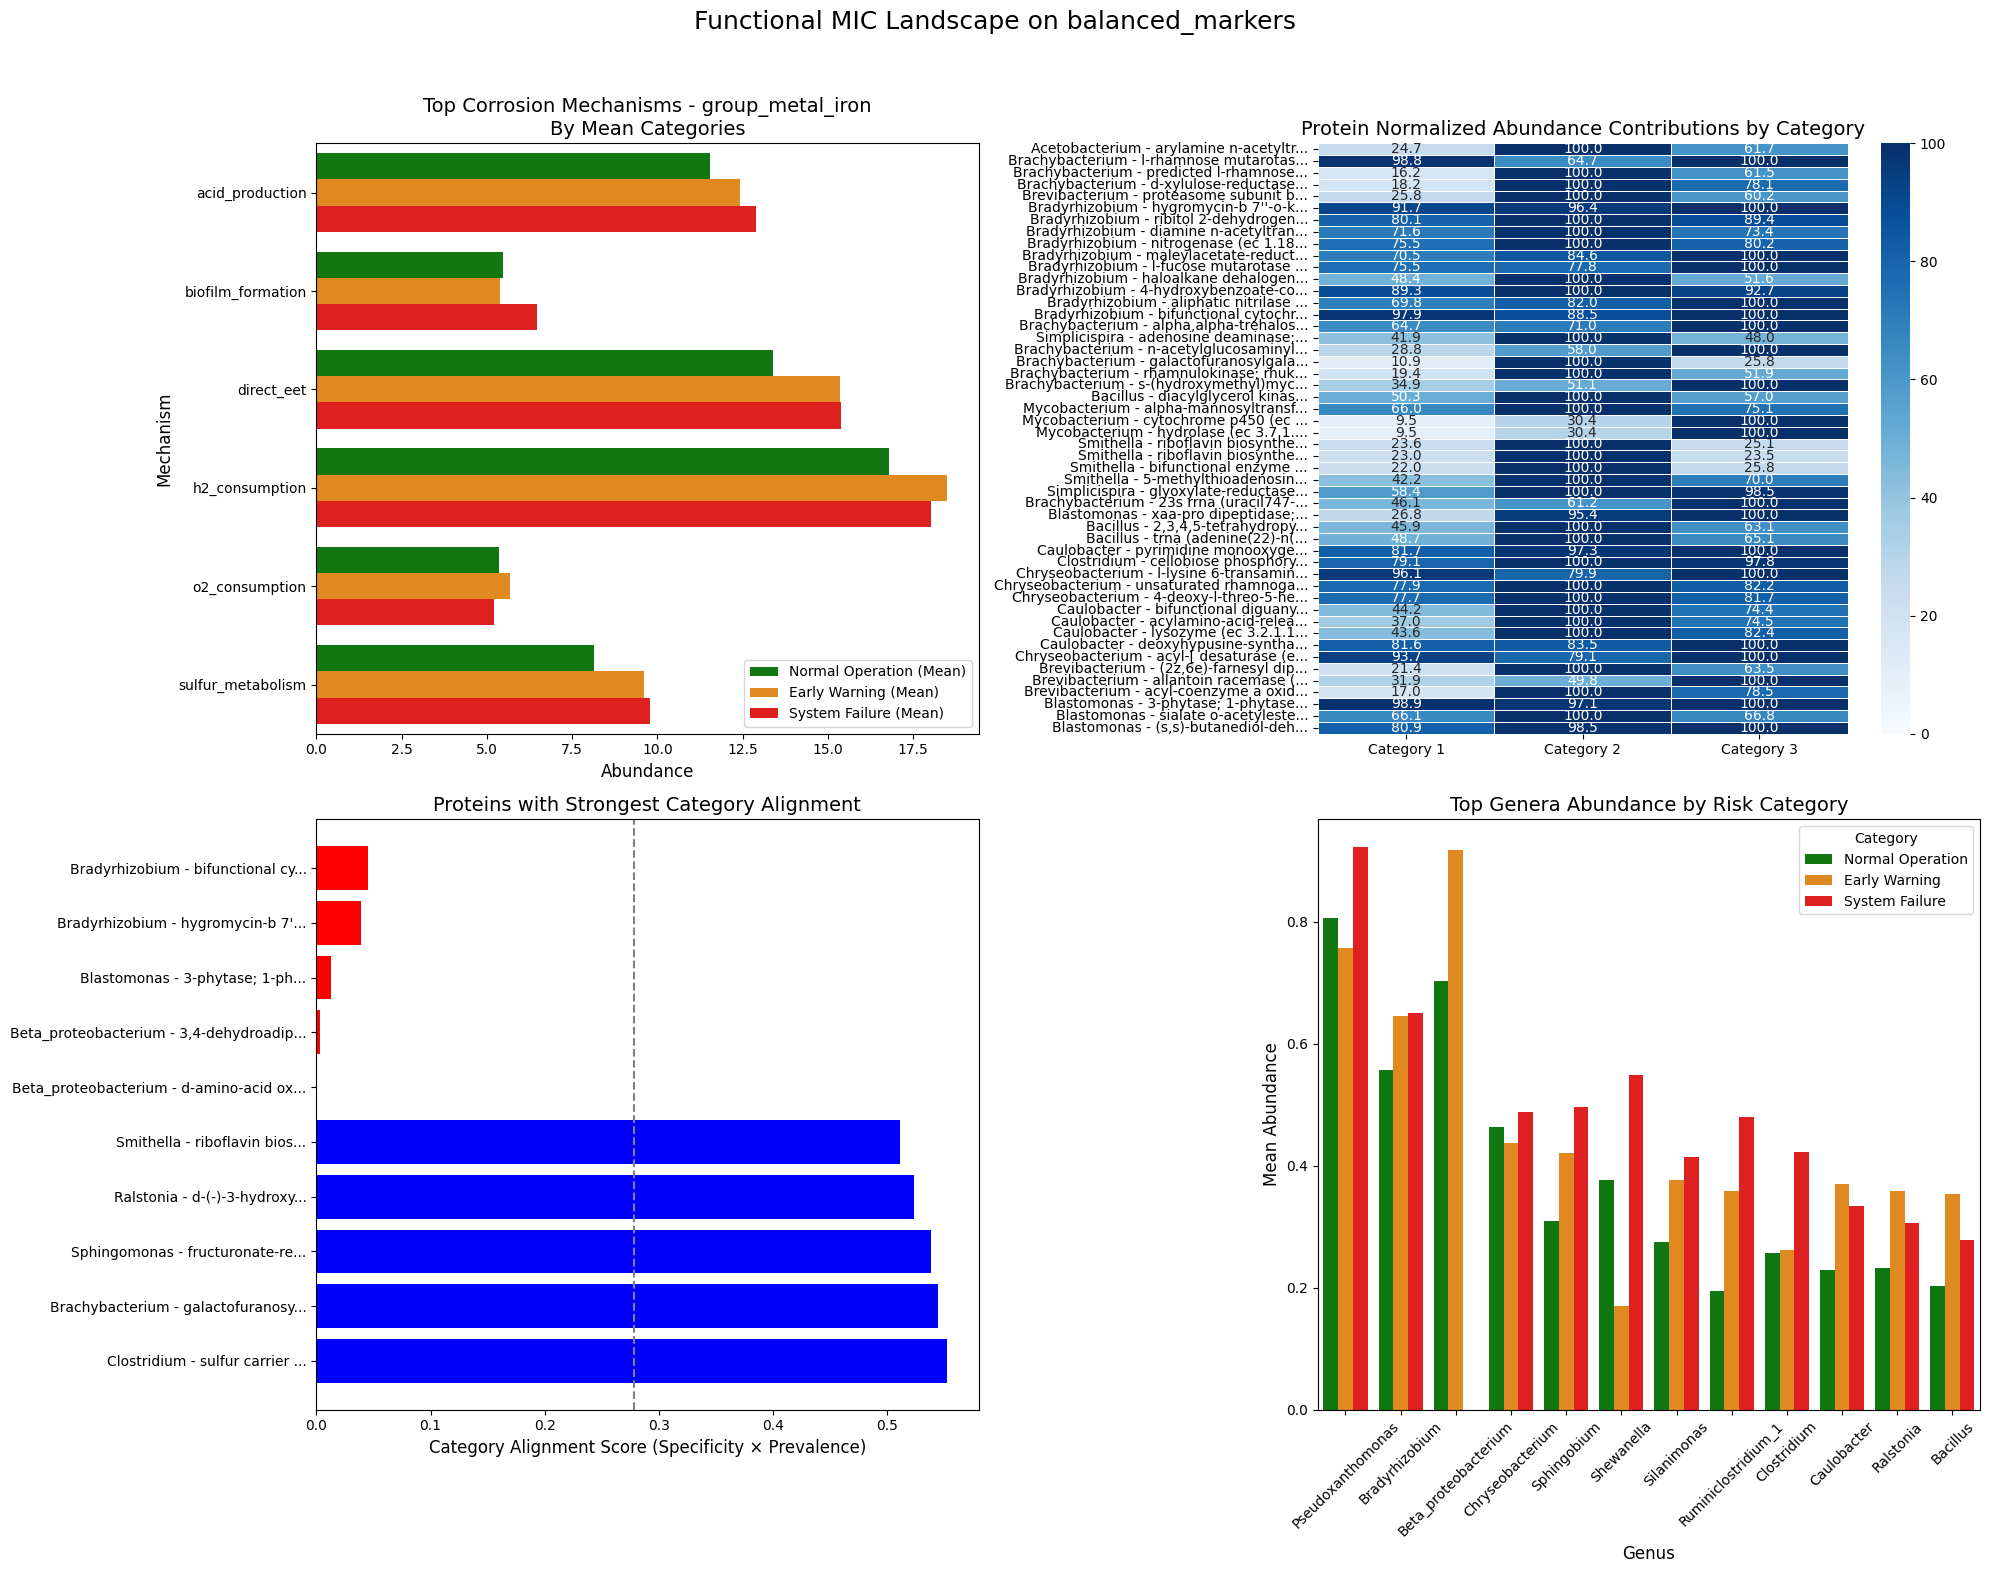

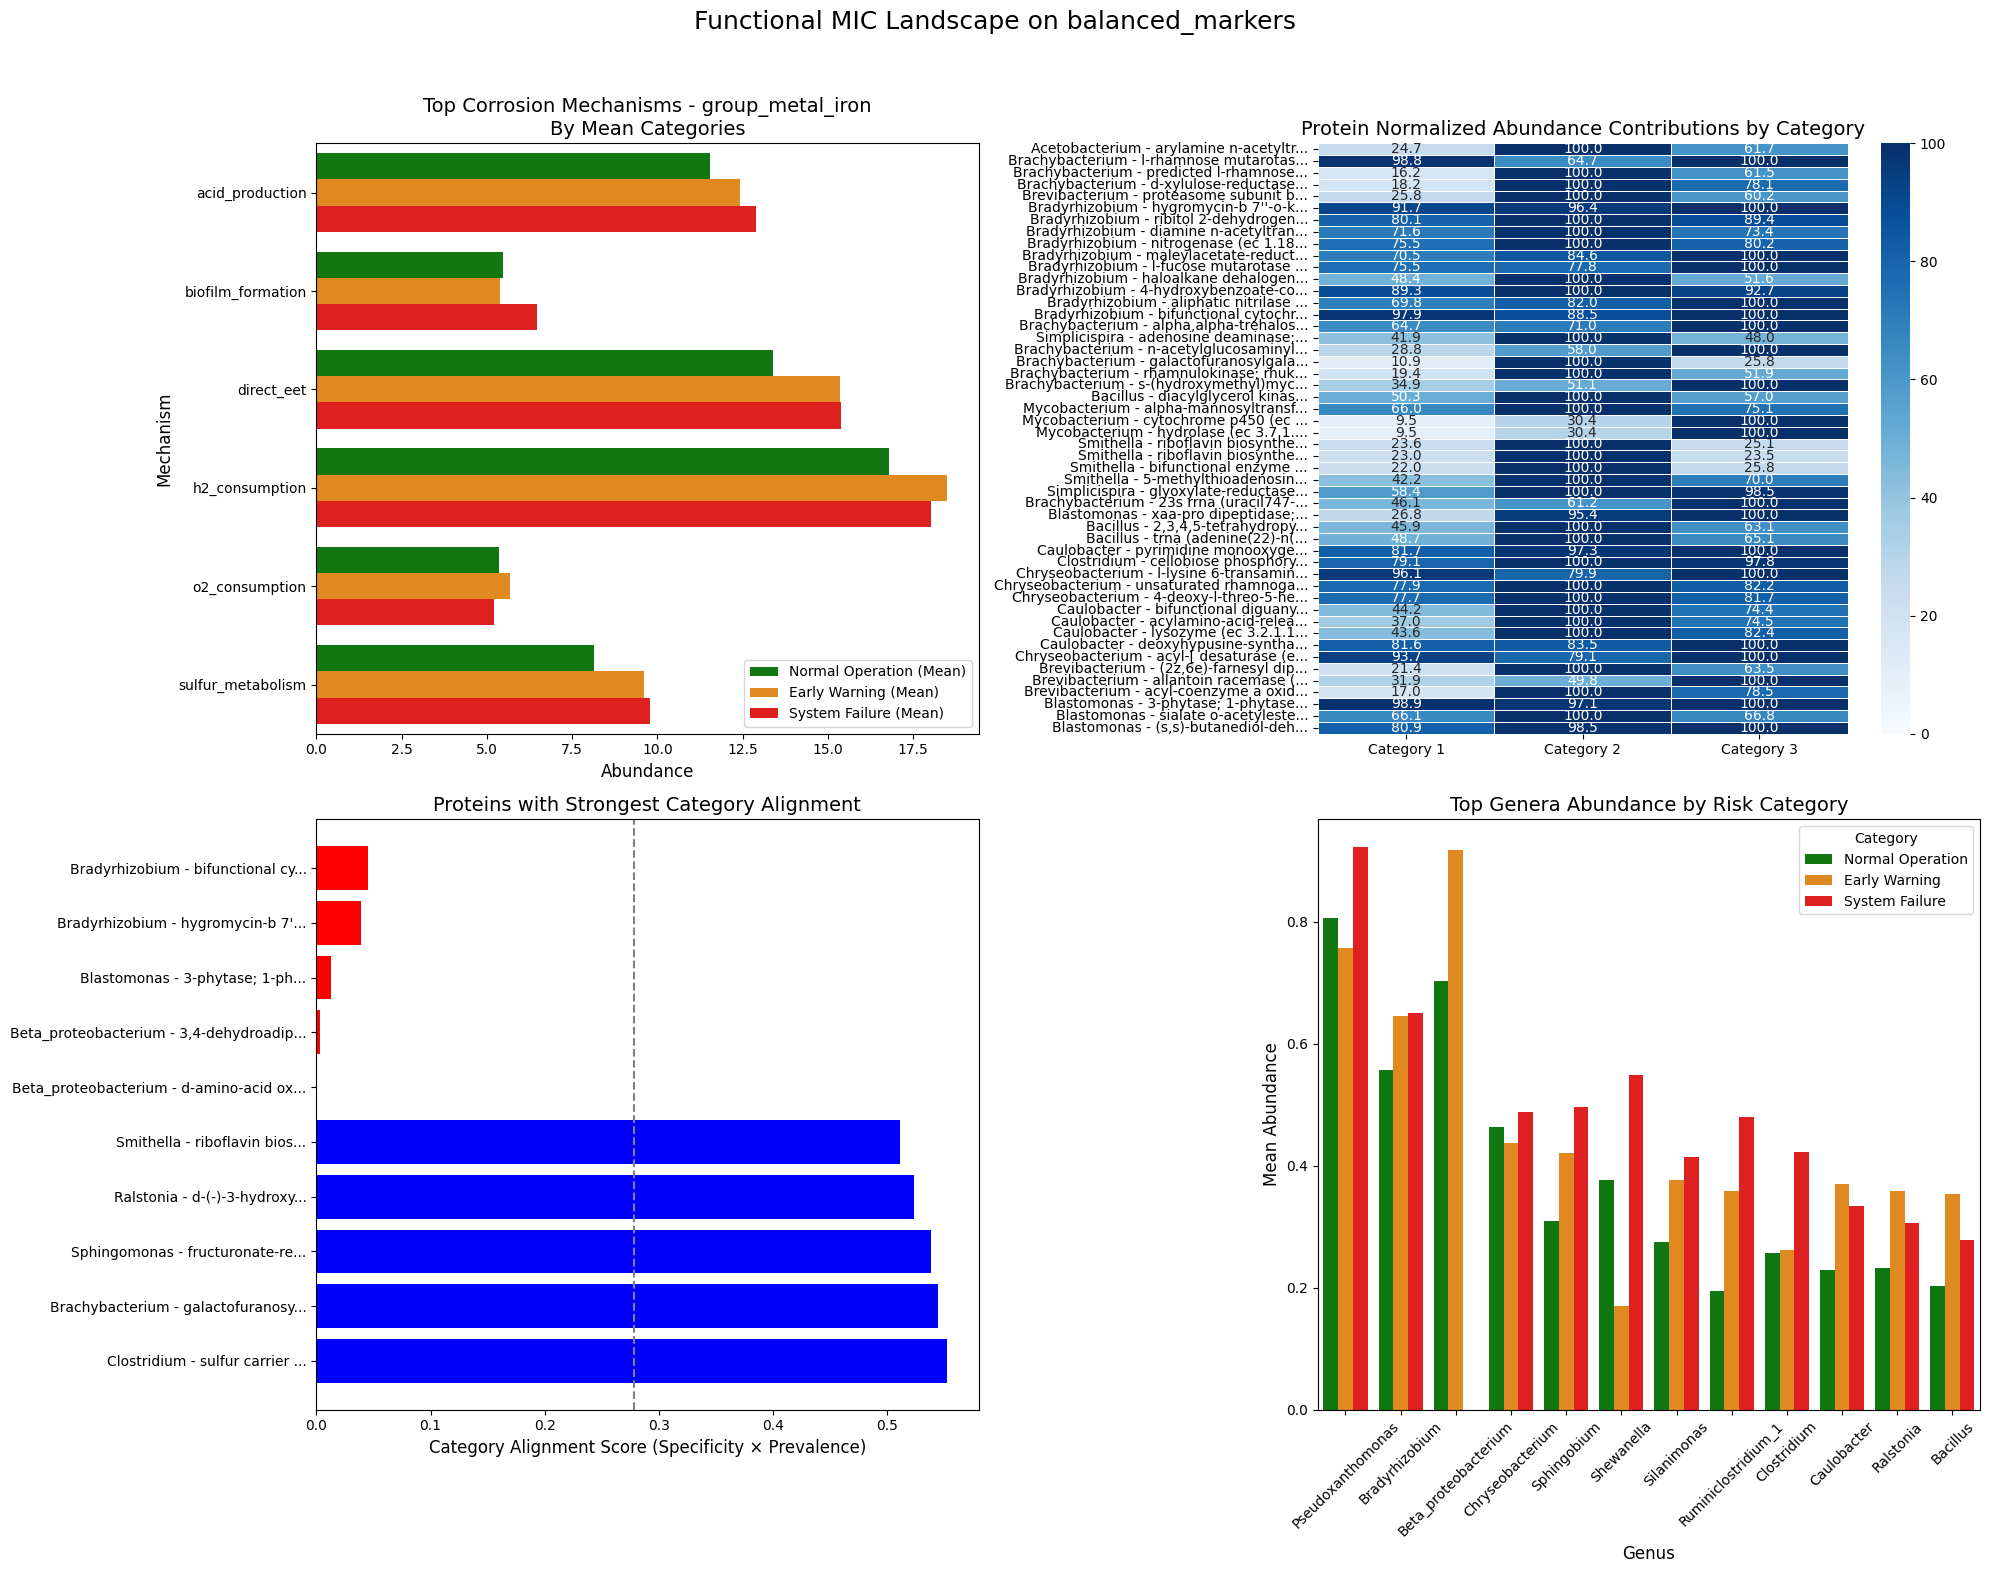

In [25]:
plot_multiview_functional_landscape(top_markers, top_n=150)

/tmp/ipykernel_50526/2058062186.py:152: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  heatmap_data = heatmap_data.fillna(0)


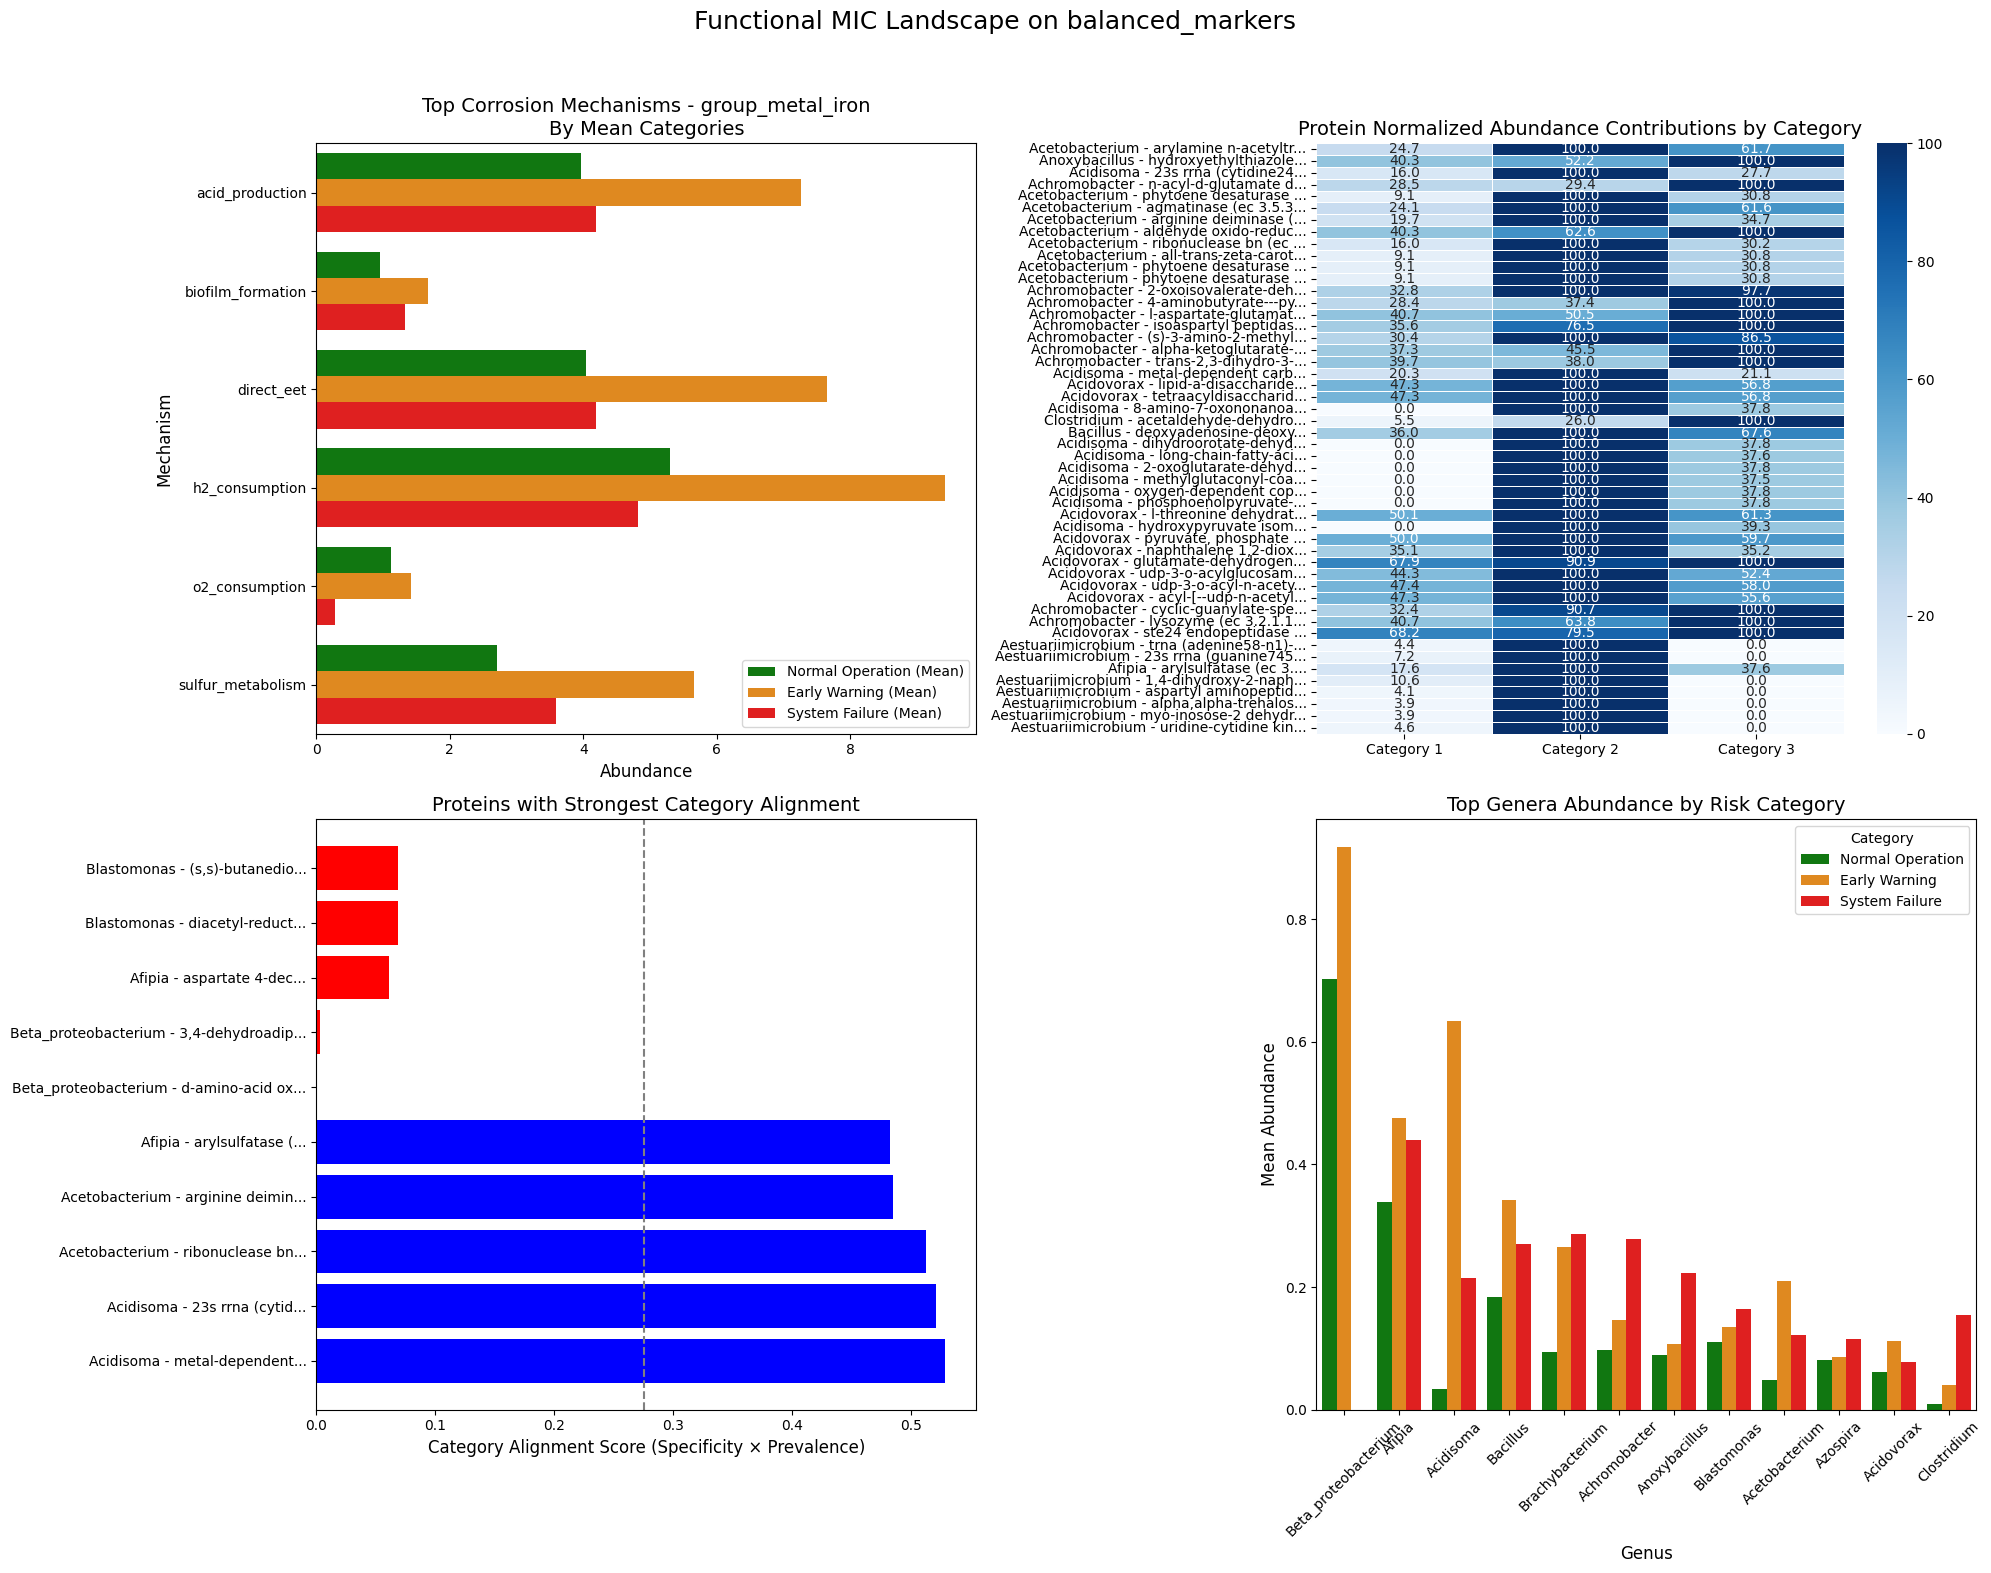

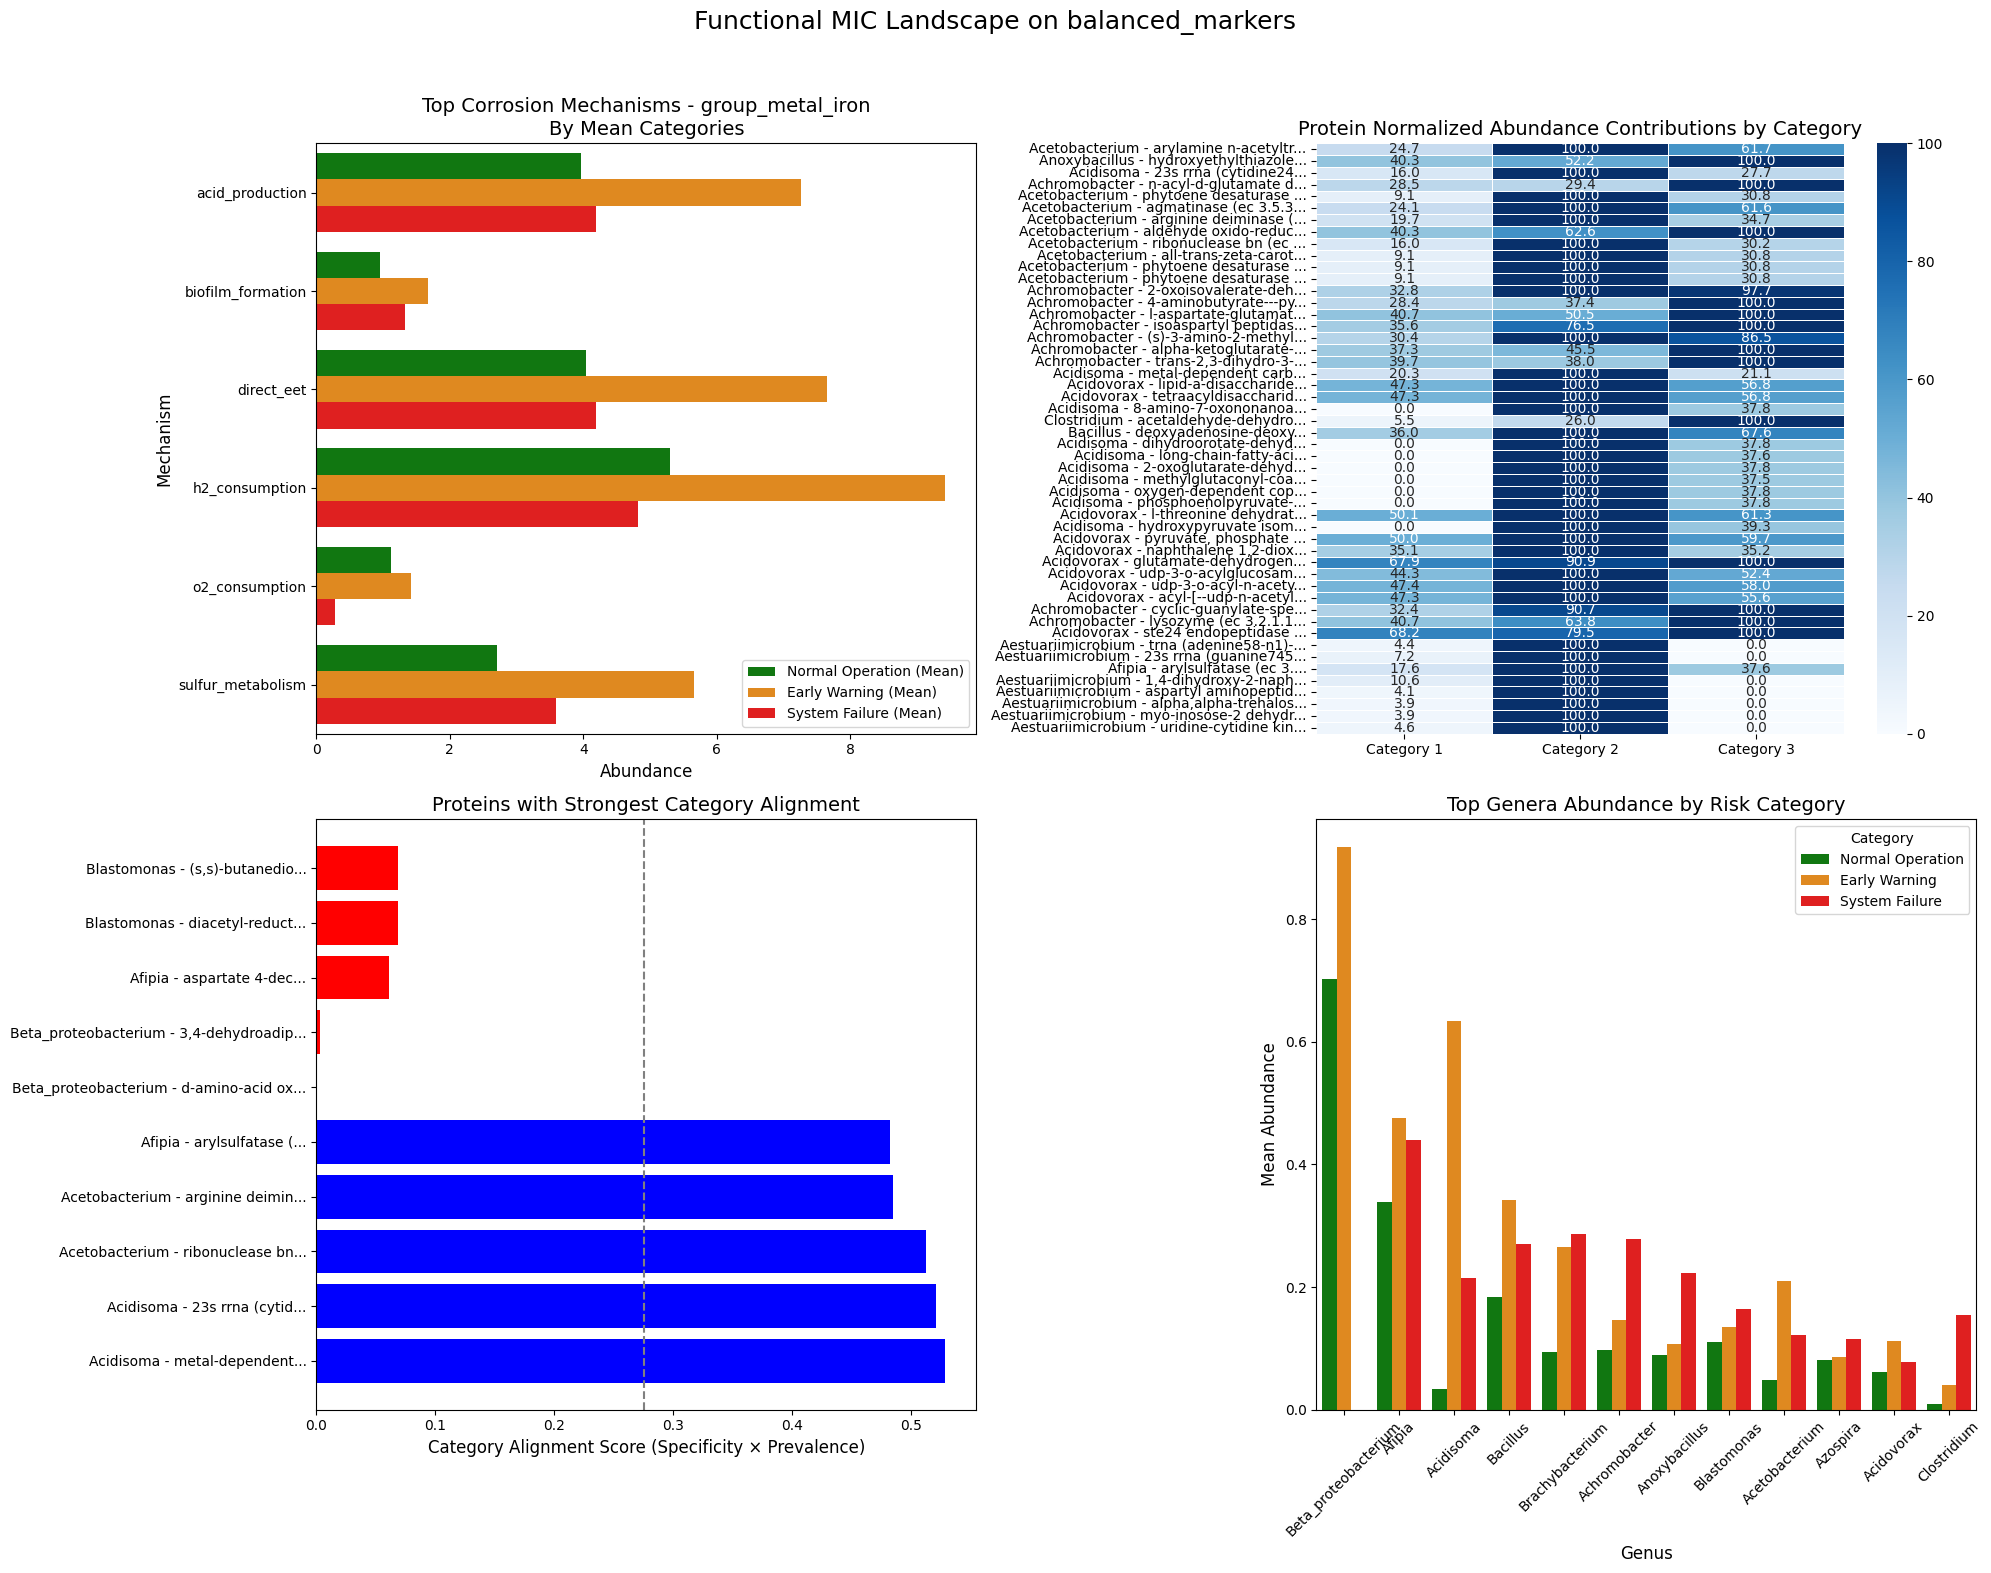

In [24]:
#plot_multiview_functional_landscape(prioritized_markers, top_n=25)
plot_multiview_functional_landscape(high_confidence, top_n=100)

The prominence of O2 consumption as the top mechanism at the granular level matches previous observations in section 7.3 and 7.4 at the global scale, which gives good consistency to the analysis.
The sequence of mechanisms (O2 consumption → sulfur metabolism → acid production) tells a coherent story that aligns with measured parameters:
O2 consumption creating anaerobic conditions, sulfur metabolism explaining why sulfur disappears from the measurements (being used by bacteria or converted to H2S) and the acid production matching the high concentration of acids found in field. The plot for very_high_specificity group shows that the biofilm mechanism and the acid production predominate for that group.

As can be seen the ploting corresponds to the means on the data. The original data would be taken in order to see the data on the original form

## 3.2. Comparison

In [37]:
def corrosion_mechanism_original_vs_mean(top_markers, name="Comparison", top_n=10):
    """
    Create a comparison plot showing corrosion mechanisms using:
    1. Original Category (left subplot)
    2. Mean categories (right subplot)
    
    Parameters:
    -----------
    top_markers : DataFrame
        DataFrame containing the data with columns: 
        Category, corrosion_mechanisms, norm_abund_contri, mean_cat1, mean_cat2, mean_cat3
    name : str, optional
        Name to include in the plot title, by default "Comparison"
    top_n : int, optional
        Number of top mechanisms to display, by default 10
    save_path : str, optional
        Path to save the output figure, by default None
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The generated figure
    """
    # Define colors and categories for original Category
    category_colors = {
        1: '#008800',  # Dark green - Normal Operation
        2: '#FF8C00',  # Dark orange - Early Warning
        3: '#FF0000'   # Red - System Failure
    }
    
    categories_labels = {
        1: 'Normal Operation',
        2: 'Early Warning',
        3: 'System Failure'
    }
    
    # Define colors for mean categories
    mean_colors = {
        'mean_cat1': '#008800',  # Dark green
        'mean_cat2': '#FF8C00',  # Dark orange
        'mean_cat3': '#FF0000'   # Red
    }
    
    # Mean category labels for the legend
    mean_labels = {
        'mean_cat1': 'Normal Operation (Mean)',
        'mean_cat2': 'Early Warning (Mean)',
        'mean_cat3': 'System Failure (Mean)'
    }
    
    # Select top markers by score
    top_markers = top_markers.copy(deep=False)
    
    # Ensure Category is integer type to prevent mapping issues
    top_markers['Category'] = top_markers['Category'].astype(int)
    
    # Create figure with multiple subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # 1. FIRST PLOT: Original Category (left)
    mech_by_category = []
    for _, row in top_markers.iterrows():
        if isinstance(row.get('corrosion_mechanisms'), str) and row['corrosion_mechanisms'] and pd.notna(row['norm_abund_contri']):
            mechanisms = [m.strip() for m in row['corrosion_mechanisms'].split(';')]
            for mech in mechanisms:
                if mech:  # Ensure mechanism is not empty
                    mech_by_category.append({
                        'Mechanism': mech,
                        'Category': int(row['Category']),  # Ensure integer type
                        'norm_abund_contri': row['norm_abund_contri']
                    })
    
    # Convert to DataFrame and aggregate
    mech_df = pd.DataFrame(mech_by_category)
    
    # Check if we have mechanisms data to plot
    if not mech_df.empty:
        # Group by mechanism and original category, summing abundance
        agg_mech = mech_df.groupby(['Mechanism', 'Category'])['norm_abund_contri'].sum().reset_index(name='Abundance')
        
        # Sort by abundance and get top mechanisms
        top_mechanisms = agg_mech.groupby('Mechanism')['Abundance'].sum().nlargest(top_n).index
        agg_mech = agg_mech[agg_mech['Mechanism'].isin(top_mechanisms)]
        
        # Create the plot with consistent category colors
        sns.barplot(
            data=agg_mech,
            x='Abundance',
            y='Mechanism',
            hue='Category',
            palette=category_colors,
            ax=ax1
        )
        
        # Ensure legend shows categories with proper labels
        handles, labels = ax1.get_legend_handles_labels()
        ax1.legend(handles=handles, labels=[categories_labels[int(label)] for label in labels])
        ax1.set_title(f"Top Corrosion Mechanisms - {name}\nBy Original Category", fontsize=14)
        ax1.set_xlabel('Abundance', fontsize=12)
        ax1.set_ylabel('Mechanism', fontsize=14)
    else:
        ax1.text(0.5, 0.5, "No mechanism data available", ha='center', va='center', fontsize=14)
        ax1.set_title('Top Corrosion Mechanisms by Original Category', fontsize=14)
    
    # 2. SECOND PLOT: Mean categories (right)
    mech_by_mean = []
    for _, row in top_markers.iterrows():
        if isinstance(row.get('corrosion_mechanisms'), str) and row['corrosion_mechanisms'] and pd.notna(row['norm_abund_contri']):
            mechanisms = [m.strip() for m in row['corrosion_mechanisms'].split(';')]
            
            # Get mean values
            mean_cat1 = row.get('mean_cat1', 0)
            mean_cat2 = row.get('mean_cat2', 0)
            mean_cat3 = row.get('mean_cat3', 0)
            
            for mech in mechanisms:
                if mech:  # Ensure mechanism is not empty
                    # Add entry for each category with its corresponding mean value
                    mech_by_mean.append({
                        'Mechanism': mech,
                        'Mean_Category': 'mean_cat1',
                        'Abundance': mean_cat1 * row['norm_abund_contri']
                    })
                    mech_by_mean.append({
                        'Mechanism': mech,
                        'Mean_Category': 'mean_cat2',
                        'Abundance': mean_cat2 * row['norm_abund_contri']
                    })
                    mech_by_mean.append({
                        'Mechanism': mech,
                        'Mean_Category': 'mean_cat3',
                        'Abundance': mean_cat3 * row['norm_abund_contri']
                    })
    
    # Convert to DataFrame for mean categories
    mean_mech_df = pd.DataFrame(mech_by_mean)
    
    # Second plot - mean categories
    if not mean_mech_df.empty:
        # Use the same top mechanisms as in the first plot for consistency
        # Aggregate by mechanism and mean category
        agg_mean_mech = mean_mech_df.groupby(['Mechanism', 'Mean_Category'])['Abundance'].sum().reset_index()
        
        # Filter to the same top mechanisms from the first plot for consistency
        agg_mean_mech = agg_mean_mech[agg_mean_mech['Mechanism'].isin(top_mechanisms)]
        
        # Create the plot with mean category colors
        sns.barplot(
            data=agg_mean_mech,
            x='Abundance',
            y='Mechanism',
            hue='Mean_Category',
            palette=mean_colors,
            ax=ax2
        )
        
        # Update legend with readable mean category labels
        handles, labels = ax2.get_legend_handles_labels()
        ax2.legend(handles=handles, labels=[mean_labels[label] for label in labels])
        
        ax2.set_title(f"Top Corrosion Mechanisms - {name}\nBy Mean Categories", fontsize=14)
        ax2.set_xlabel('Abundance', fontsize=14)
        ax2.set_ylabel('', fontsize=14)  
    else:
        ax2.text(0.5, 0.5, "No mechanism data available", ha='center', va='center', fontsize=14)
        ax2.set_title('Top Corrosion Mechanisms by Mean Categories', fontsize=14)
    
    plt.tight_layout(pad=2)
    
    return fig


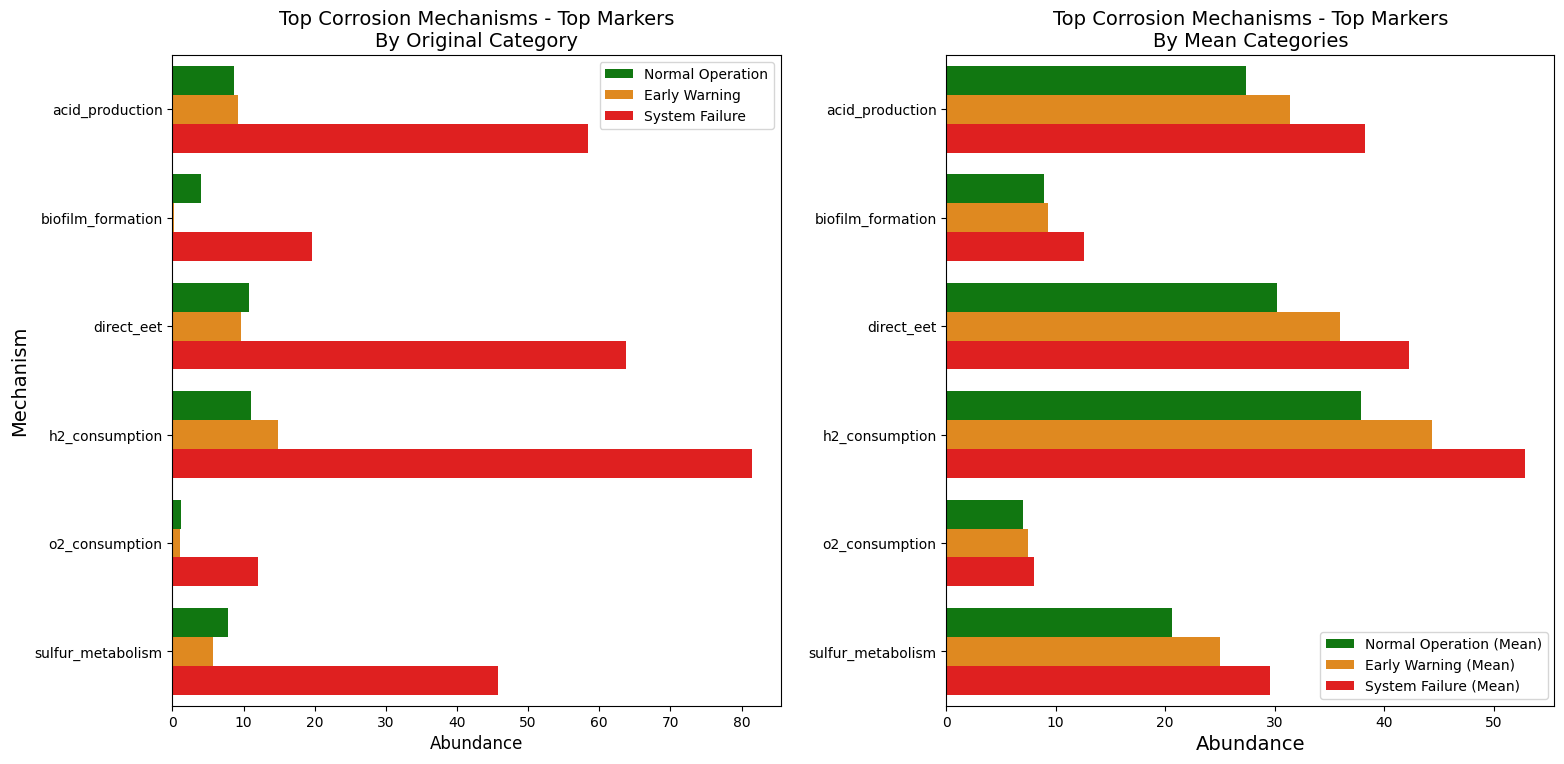

In [38]:
#Calling the function:
fig = corrosion_mechanism_original_vs_mean(top_markers, "Top Markers",  top_n=50)
plt.show()

The left plot is color-coded by the original category assigned at the system level and groups data by the normal abundance contribution per mechanism and category. In effect, this aggregation creates a system-level measure,it provides an overall picture that  align with field observations such as a reported “magnetic-like mass” and analytical findings of small organic acids. The right plot is color coded by the mean category utilising mean abundances, it gives a Genus-Protein Level Analysis. Here, the category is determined based on where each genus-protein pair shows the highest relative abundance—indicating the dominant association per row. By taking means, the plot smooths out the local variability inherent at the granular level, which can help reveal broad trends across risk levels. Averaging hides variability among individual genus-protein pairs. Some proteins might not change or might even decrease in abundance even in high-risk systems, but this nuance is lost when data are aggregated. If the system-level categorization is influenced by a few dominant features, the aggregated measure might not fully represent the diversity of responses across mechanisms.
Using means retains the intrinsic variability at the genus-protein level, acknowledging that each pair can behave differently under various conditions.This approach may capture biologically relevant differences such as downregulation of certain proteins despite an overall high-risk status. The granular view often shows a mix of increases, decreases, or constancy in protein abundance, which makes it harder to draw a unified conclusion about system-level behavior. While the granular approach is more precise, it might diverge from field-level measurements (as observed with Picrust2 results showing a dominance of O₂ respiration pathways like cytochrome C), raising questions about which level of detail best represents the actual system state.
The differences between the two plots highlight an important trade-off. The system-level evaluation (left) offers a simplified, aggregate view that aligns well with certain field observations but may overlook intra-group variability. The granular approach (right) captures heterogeneity among the genus-protein pairs, emphasizing that in a “high-risk” system, not all proteins follow the same trend, which is crucial when interpreting pathway-level responses. The system-level plot reflects the outcome of on-field analyses (e.g., elevated magnetic mass and confirmation of small organic acids) and can be used to support operational assessments.If comparing with section 7.3 the direct Picrust2 result the granular plot better corresponds to the Picrust2 findings from Galaxy, where the dominant pathways (such as those related to O₂ respiration) are identified. This suggests that, at the detailed protein level, the behavior is more complex than what is captured by the aggregate measure.

## 3.3 Pathway Data across Risk Categories

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

# ... (your extract_pathways and categorize_pathway functions remain the same) ...

def plot_pathway_analysis(prioritized_markers, top_n=100):
    """
    Creates comprehensive visualizations of pathway data across risk categories.
    """
    plt.close('all')
    top_markers = prioritized_markers.sort_values('combined_score', ascending=False).head(top_n)
    pathway_counts = extract_pathways(top_markers)
    common_pathways = pathway_counts[pathway_counts >= 2].index.tolist()
    pathway_categories = {}
    for pathway in common_pathways:
        category = categorize_pathway(pathway)
        pathway_categories[category] = pathway_categories.get(category, 0) + pathway_counts[pathway]
    category_df = pd.DataFrame({'Category': list(pathway_categories.keys()), 'Count': list(pathway_categories.values())}).sort_values('Count', ascending=False)
    pathway_data = []
    for _, row in top_markers.iterrows():
        if isinstance(row['pathways'], str) and row['pathways']:
            row_pathways = [p.strip() for p in row['pathways'].split(';')]
            for pathway in row_pathways:
                if pathway in common_pathways:
                    pathway_data.append({
                        'Pathway': pathway,
                        'Category': categorize_pathway(pathway),
                        'Category 1': row['mean_cat1'] if pd.notna(row['mean_cat1']) else 0,
                        'Category 2': row['mean_cat2'] if pd.notna(row['mean_cat2']) else 0,
                        'Category 3': row['mean_cat3'] if pd.notna(row['mean_cat3']) else 0,
                    })
    pathway_df = pd.DataFrame(pathway_data)
    agg_pathway = pathway_df.groupby('Category').agg({'Category 1': 'mean', 'Category 2': 'mean', 'Category 3': 'mean'}).reset_index()
    agg_pathway['Cat3_to_Cat1_Ratio'] = agg_pathway.apply(lambda x: x['Category 3'] / x['Category 1'] if x['Category 1'] > 0 else (10 if x['Category 3'] > 0 else 1), axis=1)
    agg_pathway = agg_pathway.sort_values('Cat3_to_Cat1_Ratio', ascending=False)
    fig, axes = plt.subplots(2, 2, figsize=(18, 14)) #Create a 2x2 grid.
    sns.barplot(data=category_df, x='Count', y='Category', color='skyblue', ax=axes[0, 0])
    for i, bar in enumerate(axes[0, 0].patches):
        axes[0, 0].text(bar.get_width() + 0.3, bar.get_y() + bar.get_height() / 2, f"{int(bar.get_width())}", ha='left', va='center', fontsize=12)
    axes[0, 0].set_title('Distribution of Pathway Categories', fontsize=18)
    axes[0, 0].tick_params(axis='both', labelsize=14)
    G = nx.Graph()
    for category, count in pathway_categories.items():
        G.add_node(category, size=count, group=1)
    genera_counts = top_markers['Genus'].value_counts().head(10)
    for genus, count in genera_counts.items():
        G.add_node(genus, size=count * 3, group=2)
    for _, row in top_markers.iterrows():
        genus = row['Genus']
        if genus not in genera_counts:
            continue
        if isinstance(row['pathways'], str) and row['pathways']:
            pathways = [p.strip() for p in row['pathways'].split(';')]
            categories_added = set()
            for pathway in pathways:
                if pathway in common_pathways:
                    category = categorize_pathway(pathway)
                    if category not in categories_added:
                        if not G.has_edge(genus, category):
                            G.add_edge(genus, category, weight=1)
                        else:
                            G[genus][category]['weight'] += 1
                        categories_added.add(category)
    pos = nx.spring_layout(G, k=0.3, seed=42)
    category_nodes = [node for node in G.nodes() if G.nodes[node].get('group', 0) == 1]
    genera_nodes = [node for node in G.nodes() if G.nodes[node].get('group', 0) == 2]
    node_sizes_cat = [G.nodes[node].get('size', 10) * 20 for node in category_nodes]
    node_sizes_gen = [G.nodes[node].get('size', 10) * 20 for node in genera_nodes]
    nx.draw_networkx_nodes(G, pos, nodelist=category_nodes, node_color='lightblue', node_size=node_sizes_cat, alpha=0.8, ax=axes[1, 1])
    nx.draw_networkx_nodes(G, pos, nodelist=genera_nodes, node_color='lightgreen', node_size=node_sizes_gen, alpha=0.8, ax=axes[1, 1])
    edge_weights = [G[u][v].get('weight', 1) / 2 for u, v in G.edges()]
    nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.5, ax=axes[1, 1])
    nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif', ax=axes[1, 1])
    axes[1, 1].set_title('Genus-Pathway Category Network', fontsize=18)
    axes[1, 1].axis('off') #Turn off the axis.
    sns.barplot(data=agg_pathway, x='Cat3_to_Cat1_Ratio', y='Category', color='steelblue', ax=axes[1, 0])
    for i, bar in enumerate(axes[1, 0].patches):
        ratio_value = agg_pathway.iloc[i]['Cat3_to_Cat1_Ratio']
        axes[1, 0].text(bar.get_width() + 0.02, bar.get_y() + bar.get_height() / 2, f"{ratio_value:.2f}x", ha='left', va='center', fontsize=12)
    axes[1, 0].axvline(x=1, color='gray', linestyle='--')
    axes[1, 0].set_title('Pathway Category Enrichment in High Risk (Cat3:Cat1 Ratio)', fontsize=18)
    axes[1, 0].tick_params(axis='both', labelsize=14)
    heatmap_data = agg_pathway.set_index('Category')[['Category 1', 'Category 2', 'Category 3']].fillna(0)
    for idx in heatmap_data.index:
        row_max = heatmap_data.loc[idx].max()
        if row_max > 0:
            heatmap_data.loc[idx] = (heatmap_data.loc[idx] / row_max * 100).round(1)
    sns.heatmap(heatmap_data, cmap='Blues', annot=True, fmt=".1f", linewidths=0.5, ax=axes[0, 1], vmin=0, vmax=100, annot_kws={"size": 12}) #put the heatmap on the 2nd position.
    axes[0, 1].set_title('Pathway Category Abundance Patterns (% of max)', fontsize=18)
    axes[0, 1].tick_params(axis='both', labelsize=14)
    plt.tight_layout()
    return fig, category_df, agg_pathway

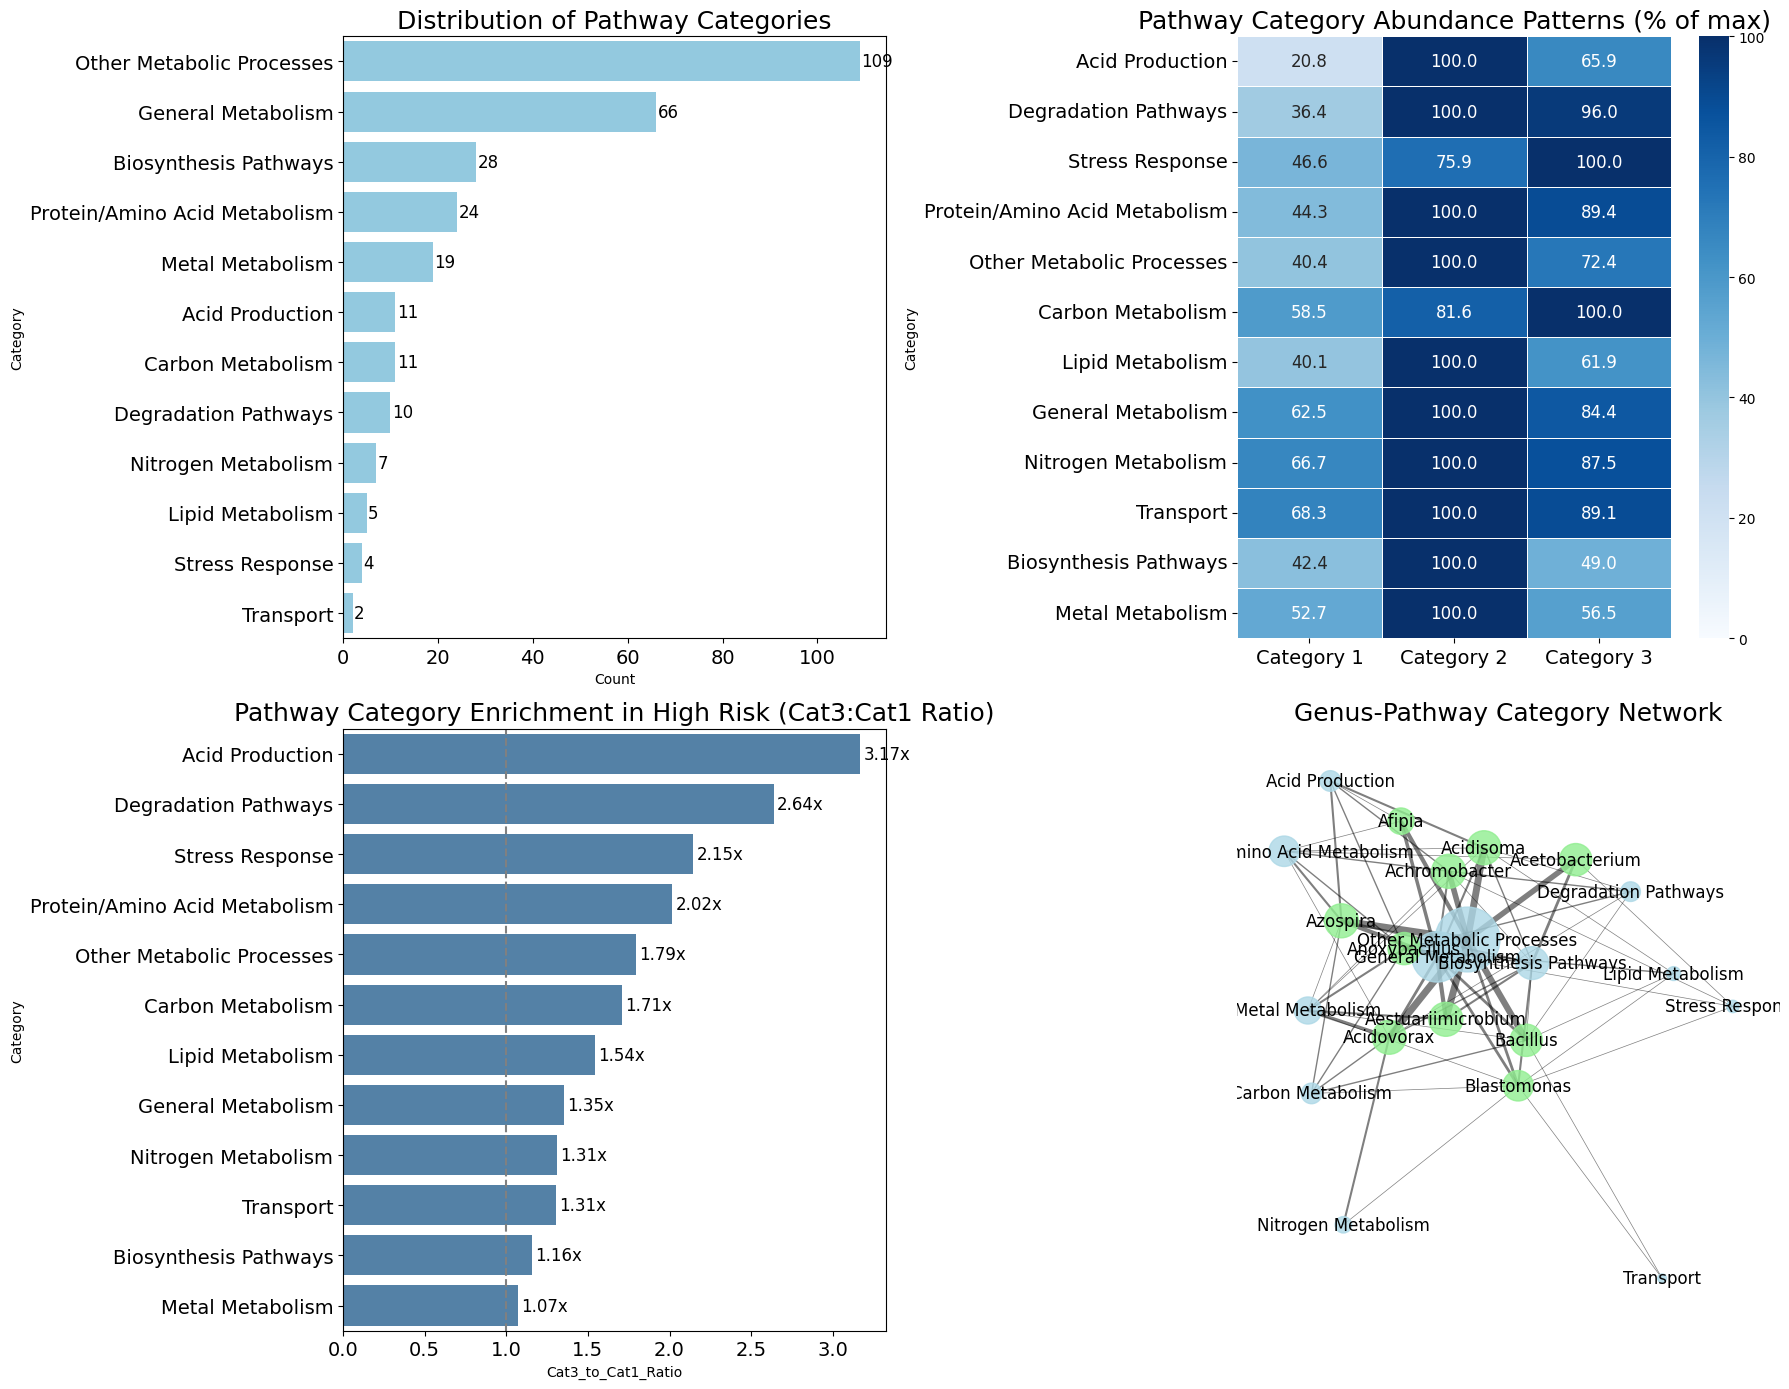

In [62]:
fig = plot_pathway_analysis(high_confidence, top_n=100)
plt.show()

The dominance of biosyntesis metabolism, metal metabolism, and other metabolic process makes biological sense in the context of corrosion. These bacteria are actively growing and adapting to metal-rich environments, requiring extensive byosinthesis capacity. However, the relative analysis (Plots 3 and 4) tells a different and perhaps more revealing story. The enrichment ratio and percentage-based visualizations highlight that carbon and nitrogen metabolism follow by stress response shown the strongest relative increase in high-risk environments. This aligns perfectly with survival and biofilm formation, as bacteria shift their metabolism toward producing extracellular polymeric substances (EPS) and building biomass in established corrosion environments.
The increased relative importance of nitrogen metabolism in higher risk categories is also significant, potentially indicating a shift toward nitrogen-containing compound production for stress response, an involvement in redox processes that could directly influence corrosion and production of specialized metabolites needed for survival in increasingly harsh environments.
The network visualization (Plot 2) provides context by showing how specific genera connect to these metabolic functions. This network approach helps identify which bacteria are the primary contributors to particular metabolic activities, revealing potential keystone species in the corrosion process.
These visualizations together suggest a metabolic progression from general growth and adaptation in early stages to specialized carbon and nitrogen metabolism in advanced corrosion environments, providing evidence for metabolic specialization as corrosion advances.


Metabolism of aromatics are propose to be the most enriched pathways on this function, whith the motility andand oter carbon fixations pathways, which is interesting to see the penicilin being anotated there, it might be noticed that the anotations here visualised come from different databases anotaated on the EC numbers reported by the picrust alogrithm and are no direct measures. The cunction for enrichement has been done on two groups first

## 3.4 Network Analysis of Corrosion Mechanisms

In [475]:
def create_static_network(df, top_n=20, threshold=0.5):
    """
    Creates a static network visualization of genus-protein-mechanism relationships.

    Args:
        df: DataFrame containing marker data with required columns
        top_n: Number of top markers to include
        threshold: Edge weight threshold (0.0-1.0)

    Returns:
        G: NetworkX graph object
    """

    # Define colors for node types
    node_colors = {
        'genus': '#2196F3',      # Blue
        'protein': '#4CAF50',    # Green
        'mechanism': '#FF5722'   # Orange-red
    }

    # Check required columns
    required_cols = ['Genus', 'protein_name', 'combined_score', 'corrosion_mechanisms']
    missing_cols = [col for col in required_cols if col not in df.columns]

    if missing_cols:
        print(f"Missing columns: {missing_cols}")
        print("Available columns:", df.columns.tolist())
        return None

    # Create network
    G = nx.Graph()

    # Get top markers
    top_markers = df.sort_values('combined_score', ascending=False).head(top_n)

    # Process rows and build network
    for _, row in top_markers.iterrows():
        genus = str(row['Genus'])
        protein = str(row['protein_name'])

        # Skip if missing data
        if pd.isna(genus) or pd.isna(protein):
            continue

        # Trim protein name if too long
        protein_short = protein[:27] + "..." if len(protein) > 30 else protein

        # Add nodes if they don't exist
        if not G.has_node(genus):
            G.add_node(genus, type='genus')

        if not G.has_node(protein_short):
            G.add_node(protein_short, type='protein')

        # Add edge between genus and protein with weight from score
        score = float(row.get('combined_score', 1.0)) if not pd.isna(row.get('combined_score')) else 1.0
        G.add_edge(genus, protein_short, weight=score)

        # Add mechanism nodes and edges
        mechanisms_col = row.get('corrosion_mechanisms', '')
        if isinstance(mechanisms_col, str) and mechanisms_col:
            for mech in mechanisms_col.split(';'):
                mech = mech.strip()
                if mech:  # Only add non-empty mechanisms
                    if not G.has_node(mech):
                        G.add_node(mech, type='mechanism')
                    G.add_edge(protein_short, mech, weight=1.0)

    # Detect communities
    partition = community_louvain.best_partition(G)

    # Assign communities to nodes
    nx.set_node_attributes(G, partition, 'community')

    # Prepare for visualization
    plt.figure(figsize=(15, 12))

    # Position nodes using force-directed layout
    pos = nx.spring_layout(G, k=0.3, seed=42)

    # Draw edges
    nx.draw_networkx_edges(G, pos, alpha=0.4)

    # Draw nodes by type with different colors
    for node_type, color in node_colors.items():
        nodes = [node for node in G.nodes() if G.nodes[node].get('type') == node_type]
        nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=color,
                              node_size=500 if node_type == 'genus' else 300)

    # Draw labels differently for each type
    genera_labels = {n: n for n in G.nodes() if G.nodes[n].get('type') == 'genus'}
    nx.draw_networkx_labels(G, pos, labels=genera_labels, font_size=10, font_weight='bold')

    mech_labels = {n: n for n in G.nodes() if G.nodes[n].get('type') == 'mechanism'}
    nx.draw_networkx_labels(G, pos, labels=mech_labels, font_size=8)

    # Create legend
    plt.plot([0], [0], 'o', color=node_colors['genus'], label='Genus')
    plt.plot([0], [0], 'o', color=node_colors['protein'], label='Protein')
    plt.plot([0], [0], 'o', color=node_colors['mechanism'], label='Mechanism')
    plt.legend()

    plt.title(f"Network of Top {top_n} Corrosion Markers")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    return G

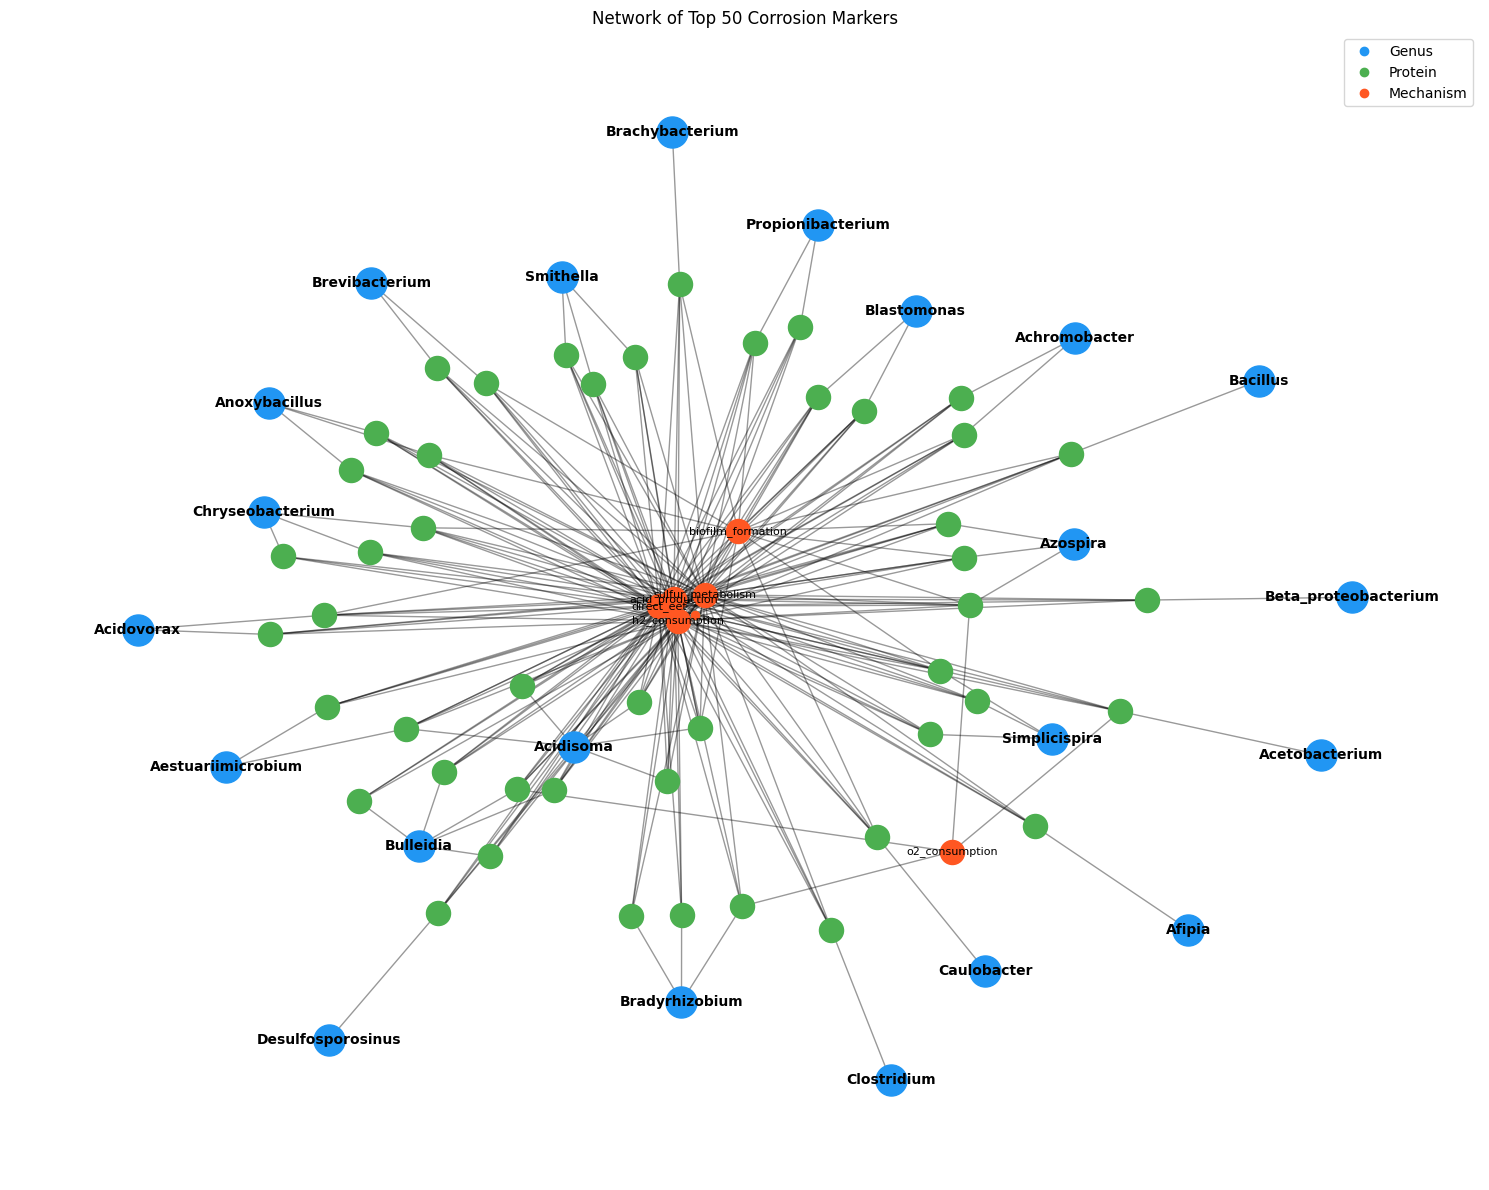

In [ ]:
create_static_network(high_metal_relv, top_n=50, threshold=0.5)

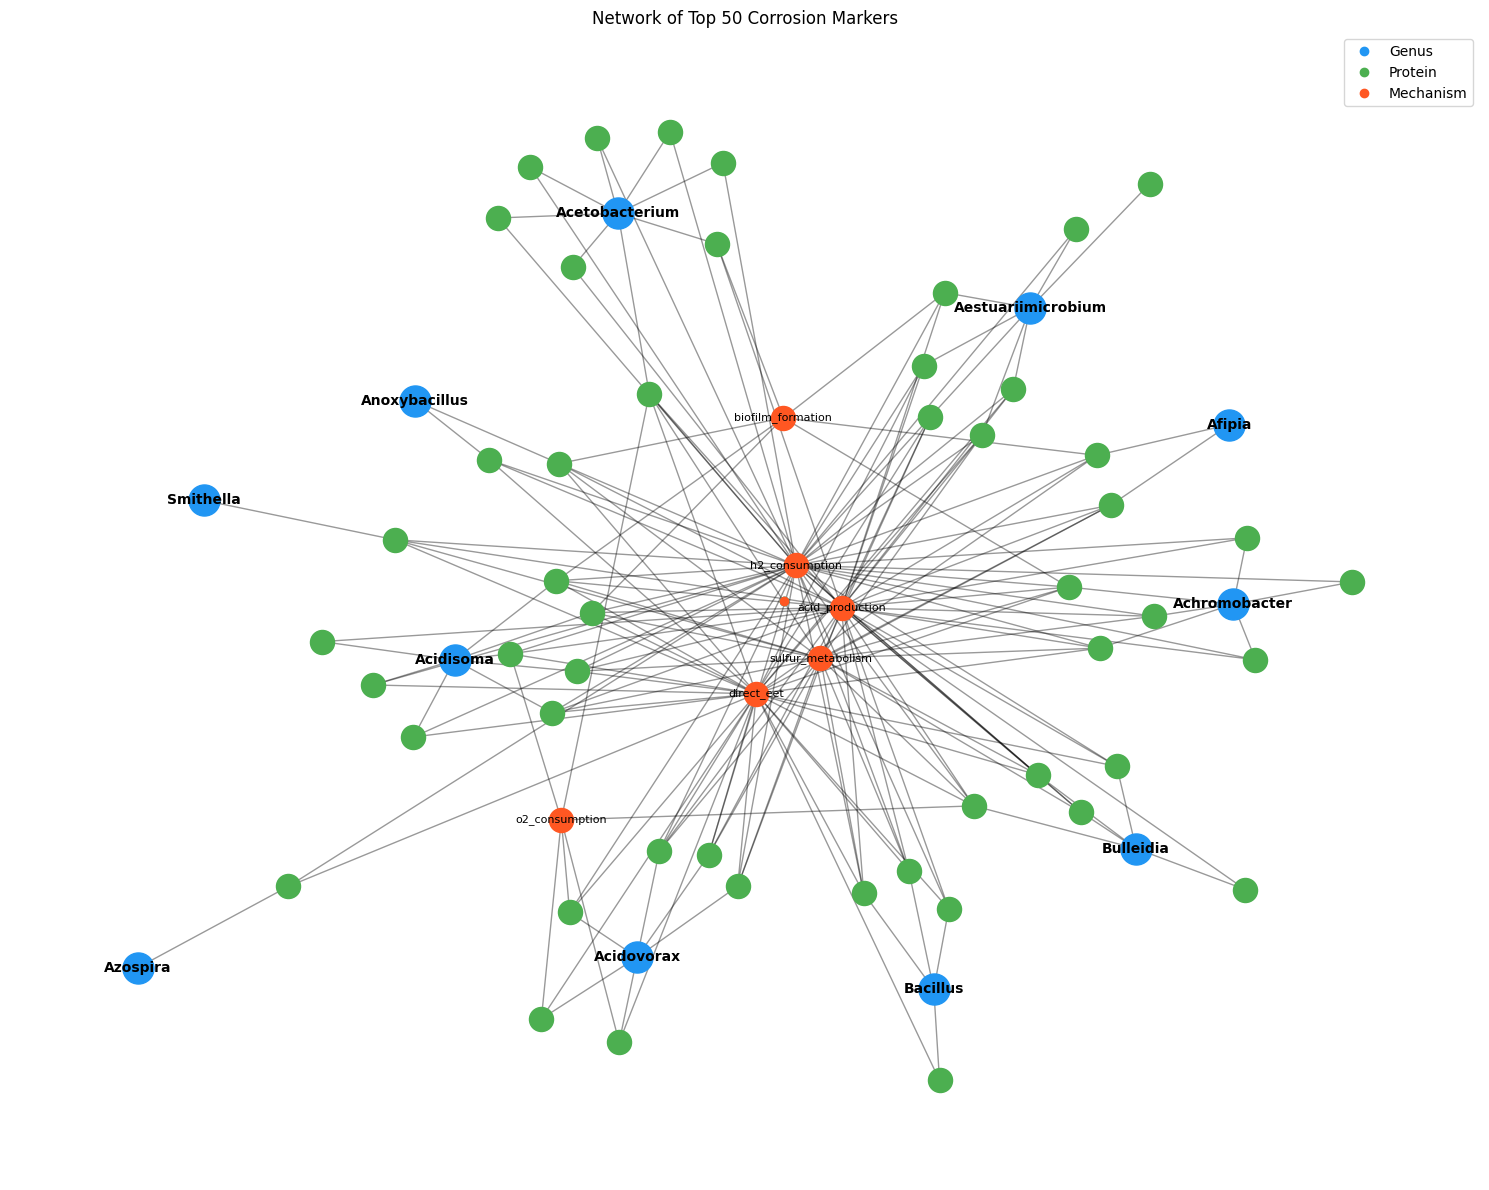

In [ ]:
create_static_network(tier_niche_specific, top_n=50, threshold=0.5)

In [87]:
import dash
from dash import html, dcc, Input, Output, callback
import dash_bootstrap_components as dbc
import networkx as nx
import plotly.graph_objects as go
import pandas as pd
import numpy as np

# Import community detection algorithm
try:
    from community import community_louvain
except ImportError:
    import sys
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "python-louvain"])
    from community import community_louvain

def create_dash_network(df, top_n=20, threshold=0.5):
    """
    Creates a Dash application with an interactive network visualization.
    
    Args:
        df: DataFrame containing marker data
        top_n: Number of top markers to include
        threshold: Edge weight threshold (0.0-1.0)
        
    Returns:
        Dash application object
    """
    # Define colors for node types
    node_colors = {
        'genus': '#2196F3',     # Blue
        'protein': '#4CAF50',   # Green
        'mechanism': '#FF5722'  # Orange-red
    }
    
    # Create the Dash app
    app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])
    
    # Check required columns
    required_cols = ['Genus', 'protein_name', 'combined_score', 'corrosion_mechanisms']
    missing_cols = [col for col in required_cols if col not in df.columns]
    
    if missing_cols:
        app.layout = html.Div([
            html.H3("Error: Missing Required Columns"),
            html.P(f"Missing columns: {', '.join(missing_cols)}"),
            html.P(f"Available columns: {', '.join(df.columns.tolist())}"),
            html.P("Required columns: 'Genus', 'protein_name', 'combined_score', 'corrosion_mechanisms'")
        ])
        return app
    
    # Create app layout
    app.layout = html.Div([
        html.H2("Interactive Corrosion Network Visualization", style={'textAlign': 'center', 'margin': '20px'}),
        
        dbc.Row([
            # Controls panel
            dbc.Col([
                dbc.Card([
                    dbc.CardHeader("Visualization Controls"),
                    dbc.CardBody([
                        html.Label("Number of Top Markers:"),
                        dcc.Slider(
                            id='top-n-slider',
                            min=5,
                            max=50,
                            step=5,
                            value=top_n,
                            marks={i: str(i) for i in range(5, 51, 5)}
                        ),
                        html.Br(),
                        
                        html.Label("Edge Weight Threshold:"),
                        dcc.Slider(
                            id='threshold-slider',
                            min=0.1,
                            max=0.9,
                            step=0.1,
                            value=threshold,
                            marks={i/10: str(i/10) for i in range(1, 10)}
                        ),
                        html.Br(),
                        
                        html.Label("Node Types:"),
                        dbc.Checklist(
                            id='node-type-checklist',
                            options=[
                                {'label': 'Genera', 'value': 'genus'},
                                {'label': 'Proteins', 'value': 'protein'},
                                {'label': 'Mechanisms', 'value': 'mechanism'}
                            ],
                            value=['genus', 'protein', 'mechanism']
                        )
                    ])
                ])
            ], width=3),
            
            # Network visualization
            dbc.Col([
                dcc.Graph(id='network-graph', style={'height': '80vh'})
            ], width=9)
        ]),
        
        # Network stats
        dbc.Row([
            dbc.Col([
                html.Div(id='network-stats', style={'margin': '20px'})
            ])
        ])
    ])
    
    @app.callback(
        [Output('network-graph', 'figure'),
         Output('network-stats', 'children')],
        [Input('top-n-slider', 'value'),
         Input('threshold-slider', 'value'),
         Input('node-type-checklist', 'value')]
    )
    def update_network(top_n_value, threshold_value, selected_node_types):
        # Create network
        G = nx.Graph()
        
        # Get top markers
        top_markers = df.sort_values('combined_score', ascending=False).head(top_n_value)
        
        # Process rows and build network
        for _, row in top_markers.iterrows():
            genus = str(row['Genus'])
            protein = str(row['protein_name'])
            
            # Skip if missing data
            if pd.isna(genus) or pd.isna(protein):
                continue
                
            # Trim protein name if too long
            protein_short = protein[:27] + "..." if len(protein) > 30 else protein
            
            # Add nodes if they don't exist
            if not G.has_node(genus):
                G.add_node(genus, type='genus')
            if not G.has_node(protein_short):
                G.add_node(protein_short, type='protein')
                
            # Add edge between genus and protein with weight from score
            score = float(row.get('combined_score', 1.0)) if not pd.isna(row.get('combined_score')) else 1.0
            G.add_edge(genus, protein_short, weight=score)
            
            # Add mechanism nodes and edges
            mechanisms_col = row.get('corrosion_mechanisms', '')
            if isinstance(mechanisms_col, str) and mechanisms_col:
                for mech in mechanisms_col.split(';'):
                    mech = mech.strip()
                    if mech:  # Only add non-empty mechanisms
                        if not G.has_node(mech):
                            G.add_node(mech, type='mechanism')
                        G.add_edge(protein_short, mech, weight=1.0)
        
        # Filter nodes by type
        nodes_to_keep = [node for node in G.nodes() if G.nodes[node].get('type') in selected_node_types]
        G = G.subgraph(nodes_to_keep)
        
        # Filter edges by weight threshold
        edges_to_keep = [(u, v) for u, v, d in G.edges(data=True) if d.get('weight', 0) >= threshold_value]
        G = G.edge_subgraph(edges_to_keep)
        
        # Detect communities if we have nodes
        if G.number_of_nodes() > 0:
            try:
                partition = community_louvain.best_partition(G)
                nx.set_node_attributes(G, partition, 'community')
            except:
                # If community detection fails, assign all to same community
                nx.set_node_attributes(G, {node: 0 for node in G.nodes()}, 'community')
        
        # Create plotly figure
        fig = go.Figure()
        
        if G.number_of_nodes() == 0:
            fig.add_annotation(
                text="No nodes match the current filter settings",
                showarrow=False,
                font=dict(size=16)
            )
            stats_html = html.Div([
                html.H5("Network Statistics"),
                html.P("No nodes to display with current settings.")
            ])
            return fig, stats_html
        
        # Calculate node positions with force-directed layout
        pos = nx.spring_layout(G, k=0.3, seed=42)
        
        # Create edge trace
        edge_x = []
        edge_y = []
        
        for edge in G.edges():
            x0, y0 = pos[edge[0]]
            x1, y1 = pos[edge[1]]
            edge_x.extend([x0, x1, None])
            edge_y.extend([y0, y1, None])
            
        edge_trace = go.Scatter(
            x=edge_x, y=edge_y,
            line=dict(width=0.8, color='#888'),
            hoverinfo='none',
            mode='lines',
            showlegend=False
        )
        
        fig.add_trace(edge_trace)
        
        # Create node traces by type
        for node_type, color in node_colors.items():
            if node_type in selected_node_types:
                node_x = []
                node_y = []
                node_text = []
                node_size = []
                
                # Filter nodes by type
                nodes = [node for node in G.nodes() if G.nodes[node].get('type') == node_type]
                
                # Skip if no nodes of this type
                if not nodes:
                    continue
                
                # Set node size by type
                size_map = {'genus': 20, 'protein': 15, 'mechanism': 18}
                
                for node in nodes:
                    x, y = pos[node]
                    node_x.append(x)
                    node_y.append(y)
                    
                    # Create hover text
                    if node_type == 'genus':
                        hover_text = f"Genus: {node}<br>Connected proteins: {len(list(G.neighbors(node)))}"
                    elif node_type == 'protein':
                        hover_text = f"Protein: {node}"
                    else:  # mechanism
                        hover_text = f"Mechanism: {node}"
                        
                    node_text.append(hover_text)
                    node_size.append(size_map[node_type] * (0.5 + G.degree(node) / 10))
                
                node_trace = go.Scatter(
                    x=node_x, y=node_y,
                    mode='markers+text' if node_type != 'protein' else 'markers',
                    text=nodes if node_type != 'protein' else None,
                    textposition="top center",
                    hoverinfo='text',
                    hovertext=node_text,
                    marker=dict(
                        color=color,
                        size=node_size,
                        line=dict(width=1, color='#333')
                    ),
                    name=node_type.capitalize()
                )
                
                fig.add_trace(node_trace)
        
        # Update layout
        fig.update_layout(
            title=f"Network of Top {top_n_value} Corrosion Markers (Threshold: {threshold_value})",
            showlegend=True,
            hovermode='closest',
            margin=dict(b=20, l=5, r=5, t=40),
            xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
            yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
            height=700,
            legend=dict(
                yanchor="top",
                y=0.99,
                xanchor="left",
                x=0.01
            )
        )
        
        # Create network statistics
        stats_html = html.Div([
            html.H5("Network Statistics"),
            html.Ul([
                html.Li(f"Total Nodes: {G.number_of_nodes()}"),
                html.Li(f"Total Edges: {G.number_of_edges()}"),
                html.Li(f"Communities Detected: {len(set(nx.get_node_attributes(G, 'community').values()))}"),
                html.Li(f"Average Degree: {sum(dict(G.degree()).values()) / G.number_of_nodes():.2f}"),
                html.Li([
                    "Node Types: ",
                    html.Span(f"{sum(1 for n in G.nodes() if G.nodes[n].get('type') == 'genus')} Genera, ", 
                             style={'color': node_colors['genus']}),
                    html.Span(f"{sum(1 for n in G.nodes() if G.nodes[n].get('type') == 'protein')} Proteins, ", 
                             style={'color': node_colors['protein']}),
                    html.Span(f"{sum(1 for n in G.nodes() if G.nodes[n].get('type') == 'mechanism')} Mechanisms", 
                             style={'color': node_colors['mechanism']})
                ])
            ])
        ])
        
        return fig, stats_html
    
    return app

# calling the dashboard

app = create_dash_network(significant_markers)
app.run(debug=True)

## 3.5. Flow of Corrosion Mechanisms to Risk Categories

In [ ]:

def temporal_transition(prioritized_markers):
    """
    Debugs issues with the temporal transition analysis and creates a Sankey diagram
    showing the flow of proteins between risk categories.
    """
    # First, let's check if we have corrosion_mechanisms data
    print(f"Total rows in dataset: {len(prioritized_markers)}")

    # Check for non-empty corrosion_mechanisms
    has_mechanisms = prioritized_markers['corrosion_mechanisms'].notna() & (prioritized_markers['corrosion_mechanisms'] != '')
    print(f"Rows with non-empty corrosion_mechanisms: {has_mechanisms.sum()}")

    # Check the first few mechanism entries to understand format
    print("\nSample corrosion_mechanisms entries:")
    for mech in prioritized_markers['corrosion_mechanisms'].dropna().head(3).values:
        print(f"  - {mech}")
        # Replace values directly within the Series (no rename() on Series)
    prioritized_markers['corrosion_mechanisms'] = prioritized_markers['corrosion_mechanisms'].str.replace('o2_consumption', 'O2_consumption').str.replace('h2_consumption', 'H2_consumption')
    # The issue might be with the 'significant' column - check its values
    if 'significant' in prioritized_markers.columns:
        print(f"\nRows marked as significant: {prioritized_markers['significant'].sum()}")
        # Try using prioritized_markers instead of classified_results
        sig_results = prioritized_markers.copy()
    else:
        print("\n'significant' column not found - using all data")
        sig_results = prioritized_markers.copy()
        sig_results['significant'] = True

    # Create category dominance for each protein-genus pair
    sig_results['dominant_category'] = sig_results[['mean_cat1', 'mean_cat2', 'mean_cat3']].idxmax(axis=1)
    sig_results['dominant_category'] = sig_results['dominant_category'].map({
        'mean_cat1': 'Category 1',
        'mean_cat2': 'Category 2',
        'mean_cat3': 'Category 3'
    })

    print(f"Distribution by dominant category: {sig_results['dominant_category'].value_counts().to_dict()}")

    # Group by genus and corrosion mechanism
    flow_data = []
    mechanisms_set = set()

    # Try different separator characters
    for separator in [';', ',', '|']:
        print(f"\nTrying separator: '{separator}'")
        mechanism_count = 0

        for _, row in sig_results.iterrows():
            if isinstance(row['corrosion_mechanisms'], str) and row['corrosion_mechanisms']:
                mechanisms = [m.strip() for m in row['corrosion_mechanisms'].split(separator) if m.strip()]
                mechanism_count += len(mechanisms)

                if len(mechanisms) > 0:
                    # If we found mechanisms, break out of the separator loop
                    break

        print(f"Found {mechanism_count} mechanisms with separator '{separator}'")
        if mechanism_count > 0:
            # We found our separator
            break

    # Use the best separator found
    for _, row in sig_results.iterrows():
        if isinstance(row['corrosion_mechanisms'], str) and row['corrosion_mechanisms']:
            mechanisms = [m.strip() for m in row['corrosion_mechanisms'].split(separator) if m.strip()]

            for m in mechanisms:
                mechanisms_set.add(m)  # Track all unique mechanisms

                # Determine the dominant category for this protein
                dom_cat = row['dominant_category']

                # Add a flow from mechanism to dominant category
                flow_data.append({
                    'source': m,
                    'target': dom_cat,
                    'value': 1,  # Count each protein once
                    'genus': row['Genus'],
                    'protein': row['protein_name']
                })

    # Convert to DataFrame
    import pandas as pd
    flow_df = pd.DataFrame(flow_data)

    # Print some diagnostic info
    print(f"\nNumber of unique mechanisms: {len(mechanisms_set)}")
    print(f"Number of flows: {len(flow_df)}")

    # Check if we have any data before proceeding
    if len(flow_df) == 0:
        print("No flows found. Check your corrosion_mechanisms data format.")
        return None

     # Define the order of mechanisms acording to energy requeriments
    mechanism_order = [
        "o2_consumption",
        "h2_consumption",
        "direct_eet",
        "iron_metabolism",
        "sulfur_metabolism",
        "acid_formation",
        "biofilm_formation"
    ]

    # Filter to only include mechanisms that exist in your data
    mechanisms = [m for m in mechanism_order if m in mechanisms_set]

    # Add any mechanisms that weren't in your predefined order
    other_mechanisms = sorted(list(mechanisms_set - set(mechanism_order)))
    mechanisms.extend(other_mechanisms)

    # Categories in order
    categories = ['Category 1', 'Category 2', 'Category 3']
    all_nodes = mechanisms + categories

    # Map source and target to indices
    node_indices = {node: i for i, node in enumerate(all_nodes)}

    flow_df['source_idx'] = flow_df['source'].map(node_indices)
    flow_df['target_idx'] = flow_df['target'].map(node_indices)

    # Aggregate flows by source and target
    agg_flows = flow_df.groupby(['source_idx', 'target_idx']).size().reset_index(name='value')

    # Define node colors - use specified category colors
    category_colors = {
        'Category 1': '#008800',  # Dark green
        'Category 2': '#FF8C00',  # Dark orange
        'Category 3': '#FF0000'   # Red
    }

    # Generate mechanism colors - use a gradient
    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    from matplotlib.colors import rgb2hex
    import numpy as np

    cmap = plt.cm.get_cmap('viridis', len(mechanisms))
    mechanism_colors = {m: rgb2hex(cmap(i)[:3]) for i, m in enumerate(mechanisms)}

    # Combine all colors
    node_colors = [mechanism_colors.get(node, '#9467bd') if node in mechanisms
                  else category_colors.get(node, '#1f77b4') for node in all_nodes]

    # Create labels with proper formatting
    labels = []
    for node in all_nodes:
        if node in mechanisms:
            # Truncate long mechanism names
            if len(node) > 25:
                labels.append(node[:22] + '...')
            else:
                labels.append(node)
        else:
            # Format category names
            labels.append(node)

    # Create Sankey diagram
    import plotly.graph_objects as go
    fig = go.Figure(data=[go.Sankey(
        arrangement="snap",  # Help prevent overlapping
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=labels,
            color=node_colors,
            hoverinfo="all",
            hovertemplate="<b>%{label}</b><br>Count: %{value}<extra></extra>"
        ),
        link=dict(
            source=agg_flows['source_idx'],
            target=agg_flows['target_idx'],
            value=agg_flows['value'],
            hovertemplate="<b>%{source.label}</b> → <b>%{target.label}</b><br>Count: %{value}<extra></extra>"
        )
    )])

    fig.update_layout(
        title_text="Metabolic Mechanisms flow according to Risk Categories",
        font_size=12,
        height=800,
        width=1200, margin=dict(l=50, r=50, t=50, b=50))

    return fig

In [ ]:
fig = temporal_transition(classified_results)
fig.show()
fig = temporal_transition(top_markers)
fig.show()

## 3.6.  Protein Abundance Trajectories across risk categories

In [94]:
def plot_protein_trajectories(balanced_markers, top_n=20):
    """
    Creates a line chart showing protein abundance trajectories across risk categories.
    """
    # Select top proteins
    top_proteins = balanced_markers.sort_values('combined_score', ascending=False).head(top_n)

    # Prepare data for trajectories
    trajectories = []

    for i, row in top_proteins.iterrows():
        # Create shorter, more readable labels
        protein_name = row['protein_name']
        if len(protein_name) > 30:
            protein_name = protein_name[:27] + "..."

        label = f"{row['Genus']} - {protein_name}"

        trajectories.append({
            'id': label,
            'Category 1': row['mean_cat1'],
            'Category 2': row['mean_cat2'],
            'Category 3': row['mean_cat3'],
            'pattern': row['pattern'],
            'score': row['combined_score']
        })

    # Convert to DataFrame
    traj_df = pd.DataFrame(trajectories)

    # Melt for plotting
    melted = pd.melt(
        traj_df,
        id_vars=['id', 'pattern', 'score'],
        value_vars=['Category 1', 'Category 2', 'Category 3'],
        var_name='category',
        value_name='abundance'
    )

    # Map categories to numeric values for plotting
    melted['category_num'] = melted['category'].map({
        'Category 1': 1,
        'Category 2': 2,
        'Category 3': 3
    })

    # Create line chart
    fig = px.line(
        melted,
        x='category_num',
        y='abundance',
        color='id',
        line_group='id',
        hover_data=['pattern', 'score'],
        markers=True,
        title='Protein Abundance Trajectories Across Risk Categories',
        labels={'category_num': 'Risk Category', 'abundance': 'Mean Abundance'},
        height=600,
        width=1000
    )

    # Update x-axis
    fig.update_xaxes(
        tickvals=[1, 2, 3],
        ticktext=['Category 1', 'Category 2', 'Category 3']
    )

    # Place legend at the bottom of the chart
    fig.update_layout(
        legend=dict(
            orientation="h",     # horizontal orientation
            yanchor="bottom",
            y=-0.5,              # position below the plot
            xanchor="center",
            x=0.5                # centered horizontally
        ),
        margin=dict(
            b=150                # add bottom margin to accommodate the legend
        )
    )

    return fig

plot_protein_trajectories(high_corrosion_relv,  top_n=20)

## 3.7.  UMAP visualizations colored by protein metadata

In [ ]:

import dash
from dash import dcc, html, Input, Output, callback, State
import dash_bootstrap_components as dbc
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import umap

def create_dash_umap_visualization(marker_data):
    """
    Creates a Dash application with an interactive UMAP visualization
    of protein data with improved legend handling and interactivity
    
    Args:
        marker_data: DataFrame containing protein data and metadata
        
    Returns:
        Dash application object
    """
    # Create the Dash app
    app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])
    
    # Get available columns for coloring
    metadata_columns = [col for col in marker_data.columns 
                        if not col.startswith('mean_') and col not in ['protein_name', 'Genus']]
    
    # Create app layout
    app.layout = html.Div([
        html.H2("Interactive Protein UMAP Visualization", style={'textAlign': 'center', 'margin': '20px'}),
        
        dbc.Row([
            # Controls panel
            dbc.Col([
                dbc.Card([
                    dbc.CardHeader("UMAP Controls"),
                    dbc.CardBody([
                        html.Label("Color By:"),
                        dcc.Dropdown(
                            id='color-by-dropdown',
                            options=[{'label': col, 'value': col} for col in metadata_columns],
                            value='corrosion_mechanisms' if 'corrosion_mechanisms' in metadata_columns else metadata_columns[0],
                            clearable=False
                        ),
                        html.Br(),
                        
                        html.Label("n_neighbors:"),
                        dcc.Slider(
                            id='n-neighbors-slider',
                            min=5,
                            max=50,
                            step=5,
                            value=15,
                            marks={i: str(i) for i in range(5, 51, 5)}
                        ),
                        html.Br(),
                        
                        html.Label("min_dist:"),
                        dcc.Slider(
                            id='min-dist-slider',
                            min=0.0,
                            max=0.9,
                            step=0.1,
                            value=0.1,
                            marks={i/10: str(i/10) for i in range(0, 10)}
                        ),
                        html.Br(),
                        
                        html.Label("Show Labels:"),
                        dbc.Checklist(
                            id='show-labels-toggle',
                            options=[
                                {'label': 'Show Labels', 'value': 'show'}
                            ],
                            value=['show']
                        ),
                        html.Br(),
                        
                        html.Label("Label Size:"),
                        dcc.Slider(
                            id='label-size-slider',
                            min=6,
                            max=14,
                            step=1,
                            value=10,
                            marks={i: str(i) for i in range(6, 15, 2)}
                        ),
                        html.Br(),
                        
                        html.Label("Point Size:"),
                        dcc.Slider(
                            id='point-size-slider',
                            min=5,
                            max=20,
                            step=1,
                            value=10,
                            marks={i: str(i) for i in range(5, 21, 5)}
                        ),
                        html.Br(),
                        
                        dbc.Button("Reset View", id="reset-button", color="primary")
                    ])
                ])
            ], width=3),
            
            # UMAP visualization
            dbc.Col([
                dcc.Loading(
                    id="loading-umap",
                    type="default",
                    children=dcc.Graph(id='umap-graph', style={'height': '80vh'})
                )
            ], width=9)
        ]),
        
        dbc.Row([
            dbc.Col([
                html.Div(id='selected-point-info', style={'margin': '20px'})
            ])
        ])
    ])
    
    @app.callback(
        [Output('umap-graph', 'figure'),
         Output('selected-point-info', 'children')],
        [Input('color-by-dropdown', 'value'),
         Input('n-neighbors-slider', 'value'),
         Input('min-dist-slider', 'value'),
         Input('show-labels-toggle', 'value'),
         Input('label-size-slider', 'value'),
         Input('point-size-slider', 'value'),
         Input('reset-button', 'n_clicks'),
         Input('umap-graph', 'clickData')]
    )
    def update_umap(color_by, n_neighbors, min_dist, show_labels, 
                   label_size, point_size, n_clicks, click_data):
        # Extract numerical data for UMAP
        numerical_cols = [col for col in marker_data.columns if col.startswith('mean_')]
        
        if len(numerical_cols) == 0:
            return go.Figure().update_layout(
                title="Error: No numerical columns found for UMAP projection",
                annotations=[{
                    'text': "No columns beginning with 'mean_' were found in the data",
                    'showarrow': False,
                    'font': {'size': 16}
                }]
            ), "No data available"
        
        # Prepare data for UMAP
        X = marker_data[numerical_cols].values
        
        # Create UMAP projection
        umap_model = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=42)
        embedding = umap_model.fit_transform(X)
        
        # Create a DataFrame with the embedding
        umap_df = pd.DataFrame({
            'UMAP1': embedding[:, 0],
            'UMAP2': embedding[:, 1],
            'protein_name': marker_data['protein_name'].values,
            'Genus': marker_data['Genus'].values,
            'label': marker_data['Genus'] + '-' + marker_data['protein_name'].str[:10]
        })
        
        # Add the color column if it exists
        if color_by in marker_data.columns:
            umap_df[color_by] = marker_data[color_by].values
        
        # Create the figure
        if color_by in marker_data.columns:
            # Check if categorical or numerical
            if marker_data[color_by].dtype == 'object':
                # Categorical coloring
                fig = px.scatter(
                    umap_df, 
                    x='UMAP1', 
                    y='UMAP2', 
                    color=color_by,
                    hover_name='label',
                    hover_data=['protein_name', 'Genus'],
                    size_max=point_size,
                    opacity=0.7,
                    title=f'UMAP Projection of Protein Data Colored by {color_by}'
                )
                
                # Improve legend appearance for categorical data
                fig.update_layout(
                    legend=dict(
                        orientation="h",
                        yanchor="bottom",
                        y=-0.2,
                        xanchor="center",
                        x=0.5,
                        font=dict(size=10),
                        itemsizing='constant'
                    )
                )
            else:
                # Numerical coloring
                fig = px.scatter(
                    umap_df, 
                    x='UMAP1', 
                    y='UMAP2', 
                    color=color_by,
                    hover_name='label',
                    hover_data=['protein_name', 'Genus'],
                    size_max=point_size,
                    opacity=0.7,
                    color_continuous_scale='viridis',
                    title=f'UMAP Projection of Protein Data Colored by {color_by}'
                )
        else:
            # Default coloring
            fig = px.scatter(
                umap_df, 
                x='UMAP1', 
                y='UMAP2',
                hover_name='label',
                hover_data=['protein_name', 'Genus'],
                size_max=point_size,
                opacity=0.7,
                title='UMAP Projection of Protein Data'
            )
        
        # Add labels conditionally
        if 'show' in show_labels:
            for i, row in umap_df.iterrows():
                fig.add_annotation(
                    x=row['UMAP1'],
                    y=row['UMAP2'],
                    text=row['label'],
                    showarrow=False,
                    font=dict(size=label_size),
                    xshift=10,
                    yshift=10,
                    bgcolor="rgba(255, 255, 255, 0.5)"  # Semi-transparent background
                )
        
        # Update layout
        fig.update_layout(
            xaxis_title="UMAP Dimension 1",
            yaxis_title="UMAP Dimension 2",
            legend_title=color_by,
            height=700,
            margin=dict(l=10, r=10, t=80, b=80 if color_by in marker_data.columns and marker_data[color_by].dtype == 'object' else 10),
            hovermode='closest'
        )
        
        # Uniform marker size
        fig.update_traces(marker=dict(size=point_size))
        
        # Show information for clicked point
        if click_data:
            point_index = click_data['points'][0]['pointIndex']
            point_info = marker_data.iloc[point_index]
            
            info_html = html.Div([
                html.H5(f"Selected Protein: {point_info['protein_name']}"),
                html.P(f"Genus: {point_info['Genus']}"),
                html.P(f"Mechanism: {point_info.get('corrosion_mechanisms', 'N/A')}"),
                
                html.H6("Additional Information:"),
                html.Ul([
                    html.Li(f"{col}: {point_info[col]}") 
                    for col in point_info.index 
                    if col not in ['protein_name', 'Genus', 'corrosion_mechanisms'] 
                    and not col.startswith('mean_')
                ])
            ])
        else:
            info_html = html.Div([
                html.P("Click on a point to see detailed information")
            ])
        
        return fig, info_html
    
    return app

# umap visualising 

app = create_dash_umap_visualization(top_markers)
app.run(debug=True)

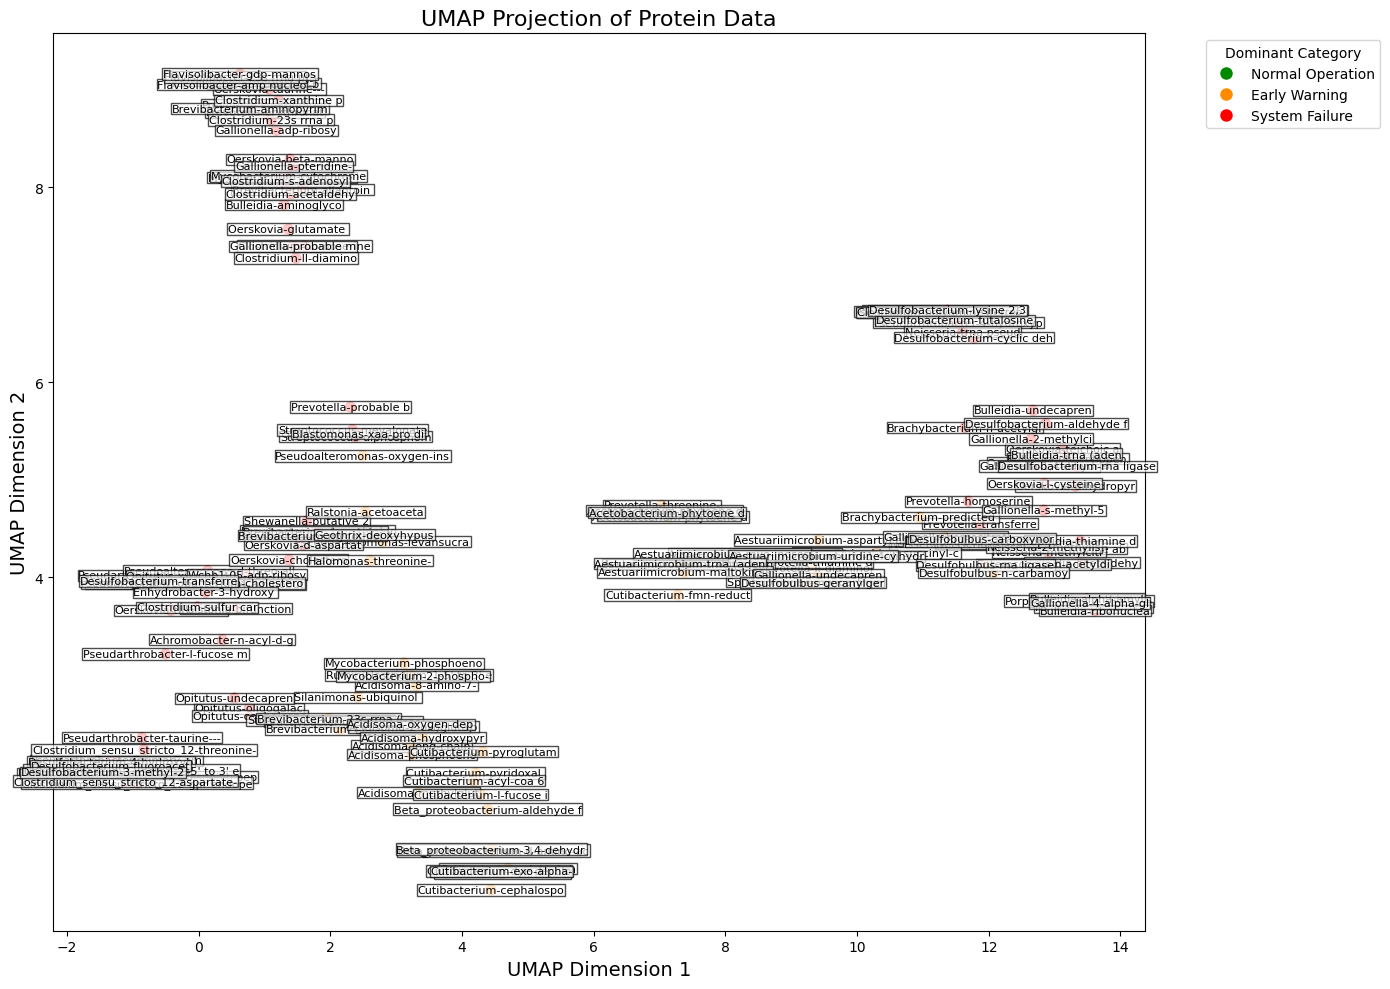

In [96]:
def create_simple_umap_visualization(marker_data, n_neighbors=15, min_dist=0.1, point_size=50):
    """
    Creates a basic UMAP visualization colored by dominant category
    """
    
    import umap
    from matplotlib.lines import Line2D
    
    # Define the category colors as in your original code
    category_colors = {
        1: '#008800',  # Dark green - Normal Operation
        2: '#FF8C00',  # Dark orange - Early Warning
        3: '#FF0000'   # Red - System Failure
    }
    
    categories_labels = {
        1: 'Normal Operation',
        2: 'Early Warning',
        3: 'System Failure'
    }
    
    # Extract numerical data for UMAP
    numerical_cols = [col for col in marker_data.columns if col.startswith('mean_')]
    X = marker_data[numerical_cols].values
    
    # Create UMAP projection
    umap_model = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=None)
    embedding = umap_model.fit_transform(X)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Determine dominant category for each data point
    cat_columns = ['mean_cat1', 'mean_cat2', 'mean_cat3']
    dominant_cats = marker_data[cat_columns].idxmax(axis=1).map(lambda x: int(x[-1]))
    
    # Create a list of colors based on dominant category
    colors = [category_colors[cat] for cat in dominant_cats]
    
    # Create scatter plot
    scatter = ax.scatter(embedding[:, 0], embedding[:, 1], c=colors, s=point_size, alpha=0.7)
    
    # Create legend
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor=color, 
               label=label, markersize=10)
        for cat, (color, label) in enumerate(zip(
            [category_colors[1], category_colors[2], category_colors[3]],
            [categories_labels[1], categories_labels[2], categories_labels[3]]
        ), 1)
    ]
    
    ax.legend(handles=legend_elements, title="Dominant Category", 
             bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add basic labels
    for i, (_, row) in enumerate(marker_data.iterrows()):
        label = f"{row['Genus']}-{str(row['protein_name'])[:10]}"
        ax.text(embedding[i, 0], embedding[i, 1], label, 
              fontsize=8, ha='center', va='center',
              bbox=dict(facecolor='white', alpha=0.7, pad=0.5))
    
    # Set title and labels
    ax.set_title('UMAP Projection of Protein Data', fontsize=16)
    ax.set_xlabel('UMAP Dimension 1', fontsize=14)
    ax.set_ylabel('UMAP Dimension 2', fontsize=14)
    
    plt.tight_layout()
    return fig

plot = create_simple_umap_visualization(significant_markers, n_neighbors=10, min_dist=0.1, point_size=50)

# Display the figure
plt.show()

## 4.1 Pathway Enrichment across Risk Categories
Plot shows metabolic pathways present in the corrosion environment, how abundant each pathway is across different corrosion risk categories. The pathways increase/decrease with severity or specific conditions
Biological processes are identified, which be involved in corrosion mechanisms across different risk levels.The bubble chart visualization uses
Y-axis: Different metabolic pathways
X-axis: Risk categories (Normal Operation, Early Warning, System Failure)
Bubble size: Mean abundance of the pathway in that category
Bubble color: Pattern type (increasing, decreasing, or unique to a category)

In [88]:
def plot_pathway_enrichment(classified_results):
    """
    Creates a bubble chart showing pathway enrichment by risk category,
    accounting for unique patterns in specific categories.
    """
    # Extract top pathways from the dataset
    pathway_data = []

    for _, row in classified_results.iterrows():
        if isinstance(row['pathways'], str) and row['pathways']:
            pathways = [p.strip() for p in row['pathways'].split(';')]
            # Take only the first 3 pathways to avoid overwhelming the plot
            for pathway in pathways[:3]:
                pathway_data.append({
                    'pathway': pathway,
                    'category': 'Category 1',
                    'mean_abundance': row['mean_cat1'],
                    'classification': row['pathway_classification']
                })
                pathway_data.append({
                    'pathway': pathway,
                    'category': 'Category 2',
                    'mean_abundance': row['mean_cat2'],
                    'classification': row['pathway_classification']
                })
                pathway_data.append({
                    'pathway': pathway,
                    'category': 'Category 3',
                    'mean_abundance': row['mean_cat3'],
                    'classification': row['pathway_classification']
                })

    # Convert to DataFrame
    pathway_df = pd.DataFrame(pathway_data)

    # Group by pathway and category, calculate mean abundance
    grouped = pathway_df.groupby(['pathway', 'category', 'classification'], as_index=False)['mean_abundance'].mean()

    # Add pattern detection: dominant category
    pivot = grouped.pivot_table(index='pathway', columns='category', values='mean_abundance').reset_index()

    # Identify dominant category for each pathway
    pivot['dominant_cat'] = pivot[['Category 1', 'Category 2', 'Category 3']].idxmax(axis=1)
    pivot['max_value'] = pivot[['Category 1', 'Category 2', 'Category 3']].max(axis=1)
    pivot['pattern'] = 'unique_' + pivot['dominant_cat'].str.replace('Category ', 'cat')

    # Calculate fold changes between categories with pseudocounts
    min_threshold = 0.01  # Higher minimum threshold to prevent extreme ratios

    # Cat3 vs Cat1 fold change
    pivot['fold_change_3vs1'] = (pivot['Category 3'] + min_threshold) / (pivot['Category 1'] + min_threshold)
    pivot['log2fc_3vs1'] = np.log2(pivot['fold_change_3vs1'])

    # Cat2 vs Cat1 fold change
    pivot['fold_change_2vs1'] = (pivot['Category 2'] + min_threshold) / (pivot['Category 1'] + min_threshold)
    pivot['log2fc_2vs1'] = np.log2(pivot['fold_change_2vs1'])

    # Cat3 vs Cat2 fold change
    pivot['fold_change_3vs2'] = (pivot['Category 3'] + min_threshold) / (pivot['Category 2'] + min_threshold)
    pivot['log2fc_3vs2'] = np.log2(pivot['fold_change_3vs2'])

    # Identify increasing or decreasing patterns
    # Pattern is "increasing" if Cat1 < Cat2 < Cat3
    pivot['is_increasing'] = (
        (pivot['Category 1'] < pivot['Category 2']) &
        (pivot['Category 2'] < pivot['Category 3'])
    )

    # Pattern is "decreasing" if Cat1 > Cat2 > Cat3
    pivot['is_decreasing'] = (
        (pivot['Category 1'] > pivot['Category 2']) &
        (pivot['Category 2'] > pivot['Category 3'])
    )

    # Update pattern label based on trend
    pivot.loc[pivot['is_increasing'], 'pattern'] = 'increasing'
    pivot.loc[pivot['is_decreasing'], 'pattern'] = 'decreasing'

    # Handle infinity and NaN values with more moderate caps
    for col in ['log2fc_3vs1', 'log2fc_2vs1', 'log2fc_3vs2']:
        pivot[col] = pivot[col].replace([np.inf, -np.inf], [5, -5])  # More moderate caps
        pivot[col] = pivot[col].fillna(0)
    # Merge back the pattern information
    enrichment = pd.merge(
        grouped,
        pivot[['pathway', 'fold_change_3vs1', 'log2fc_3vs1', 'pattern', 'dominant_cat']],
        on='pathway'
    )

    # Get top pathways for each pattern type
    pattern_types = pivot['pattern'].unique()
    top_pathways = []

    for pattern in pattern_types:
        # Get top 5 pathways for this pattern
        pattern_data = enrichment[enrichment['pattern'] == pattern].copy(deep=False)
        if len(pattern_data) > 0:
            if pattern == 'increasing':
                # For increasing, get highest fold change
                top = pattern_data.sort_values('log2fc_3vs1', ascending=False).head(5)
            elif pattern == 'decreasing':
                # For decreasing, get lowest fold change
                top = pattern_data.sort_values('log2fc_3vs1', ascending=True).head(5)
            else:
                # For unique patterns, get highest mean abundance
                top = pattern_data.sort_values('mean_abundance', ascending=False).head(5)
            top_pathways.append(top)

    # Combine all top pathways
    plot_data = pd.concat(top_pathways)

    plot_data = plot_data.dropna(subset=['mean_abundance'])

    # Create a bubble chart
    fig = px.scatter(
        plot_data,
        x='category',
        y='pathway',
        size='mean_abundance',
        color='pattern',
        hover_data=['classification', 'mean_abundance'],
        height=400,
        width=600,
        title='Pathway Enrichment Analysis Across Risk Categories',
        labels={
            'category': 'Risk Category',
            'pathway': 'Metabolic Pathway',
            'mean_abundance': 'Mean Abundance',
            'pattern': 'Abundance Pattern'
        },
        color_discrete_map={
            'increasing': '#4CAF50',  # Green
            'decreasing': '#F44336',  # Red
            #'unique_cat1': '#2196F3',  # Blue
            'unique_cat2': '#FF9800',  # Orange
            'unique_cat3': '#9C27B0'   # Purple
        }, category_orders={"category": ["Category 1", "Category 2", "Category 3"]}
    )

    # Update layout for better readability
    fig.update_layout(
        yaxis={'categoryorder': 'total ascending'},
        legend_title_text='Abundance Pattern',
        xaxis_title='Risk Category',
        yaxis_title='Metabolic Pathway'
    )

    return fig, pivot

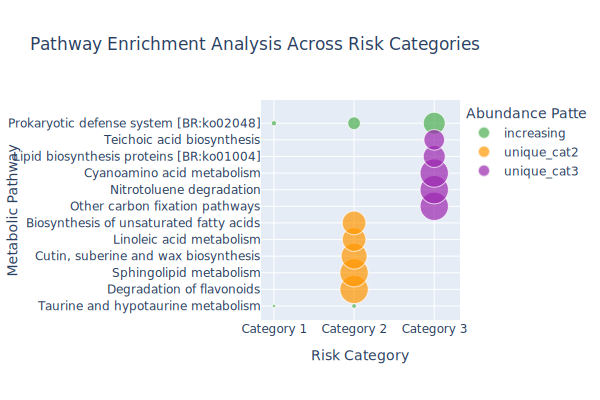

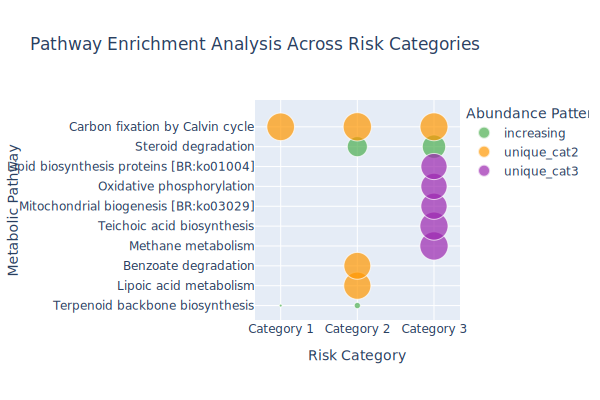

In [89]:
# calling the function
Pathway_enrichment, pathway_patterns = plot_pathway_enrichment(tier_niche_specific)
Pathway_enrichment.show(renderer="svg")
# calling the function
Pathway_enrichment, pathway_patterns = plot_pathway_enrichment(top_markers)
Pathway_enrichment.show(renderer="svg")

## 5. Mechanism Distribution across Risk Category

In [76]:
def plot_mechanism_distribution(prioritized_markers):
    """
    Creates stacked bar charts showing mechanism distribution across risk categories.
    """
    # Define colors and categories
    category_colors = {
        1: '#008800',  # Dark green - Normal Operation
        2: '#FF8C00',  # Dark orange - Early Warning
        3: '#FF0000'   # Red - System Failure
    }

    categories_labels = {
        1: 'Normal Operation',
        2: 'Early Warning',
        3: 'System Failure'
    }

    # Process mechanism data
    mech_data = []

    for _, row in prioritized_markers.iterrows():
        if isinstance(row['corrosion_mechanisms'], str) and row['corrosion_mechanisms']:
            mechanisms = [m.strip() for m in row['corrosion_mechanisms'].split(';')]
            for mech in mechanisms:
                mech_data.append({
                    'corrosion_mechanisms': mech,
                    'Category 1': row['mean_cat1'],
                    'Category 2': row['mean_cat2'],
                    'Category 3': row['mean_cat3']
                })

    # Convert to DataFrame
    mech_df = pd.DataFrame(mech_data)

    # Group by mechanism
    grouped = mech_df.groupby('corrosion_mechanisms').agg({
        'Category 1': 'sum',
        'Category 2': 'sum',
        'Category 3': 'sum'
    }).reset_index()

    # Calculate total abundance and sort
    grouped['total'] = grouped['Category 1'] + grouped['Category 2'] + grouped['Category 3']
    grouped = grouped.sort_values('total', ascending=False).head(10)

    # Prepare data for stacked bar chart
    data = []

    for category, color in zip(['Category 1', 'Category 2', 'Category 3'], category_colors.values()):
        data.append(
            go.Bar(
                name=category,
                x=grouped['corrosion_mechanisms'],
                y=grouped[category],
                text=grouped[category].round(2),
                textposition='auto',
                marker_color=color
            )
        )

    # Create figure
    fig = go.Figure(data=data)

    # Update layout
    fig.update_layout(
        barmode='stack',
        title='Top 10 Corrosion Mechanisms by Risk Category',
        xaxis_title='Corrosion Mechanisms',
        yaxis_title='Total Abundance',
        legend_title='Risk Category',
        hovermode='x',
        height=600,
        width=1000
    )

    return fig
    plt.show()

plot_mechanism_distribution(top_markers)

# Top Protein

In [515]:
def plot_top_protein_heatmap(df, top_proteins=20):
    # Sort by preferred significance metric
    top_proteins = df.sort_values(by='significance_score', ascending=False).head(top_proteins)

    # Select mean value columns for heatmap
    heatmap_data = top_proteins[['mean_cat1', 'mean_cat2', 'mean_cat3']]

    # Truncate long protein names for better visualization
    truncated_names = top_proteins['protein_name'].apply(lambda x: x if len(x) <= 70 else x[:17] + '...')

    # Create heatmap
    plt.figure(figsize=(10, 8))  # Adjusted figure size
    sns.heatmap(
        heatmap_data,
        annot=True,
        fmt=".2f",
        cmap='viridis',
        yticklabels=truncated_names,  # Use truncated names
        xticklabels=['Category 1', 'Category 2', 'Category 3']
    )

    plt.title(f"Top Protein Expression Heatmap")
    plt.ylabel("Proteins")
    plt.xlabel("Risk Category")

    # Use tight_layout to minimize empty space
    plt.tight_layout()

    return plt.gcf()

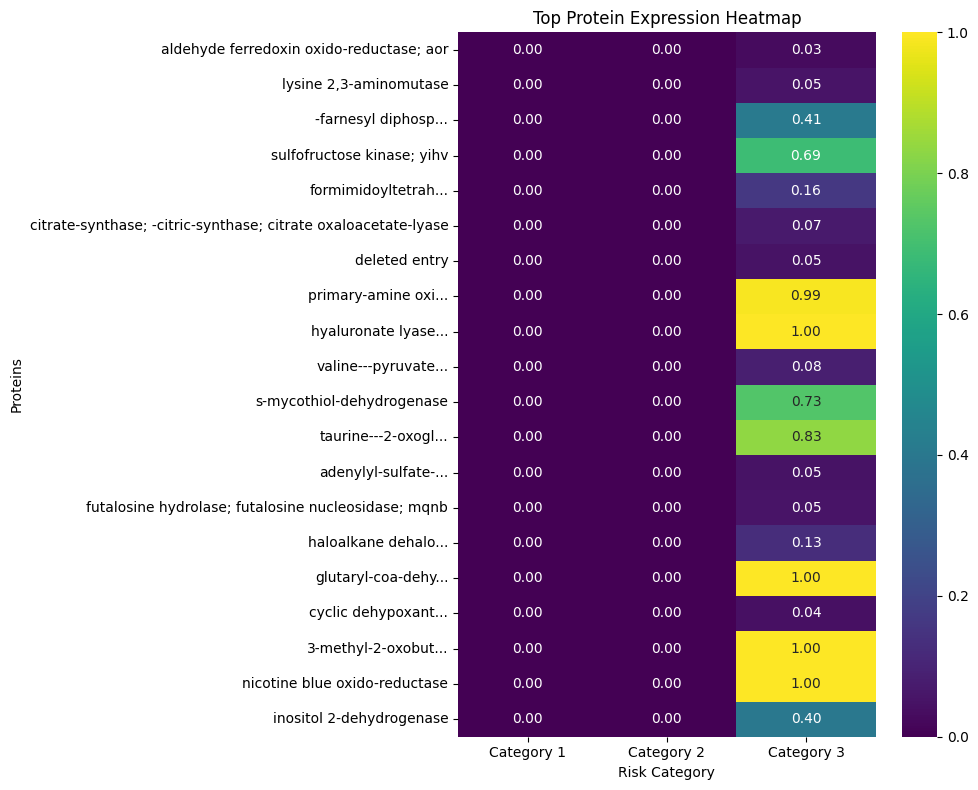

In [546]:
plot_top_protein_heatmap(high_confidence)
plt.show()

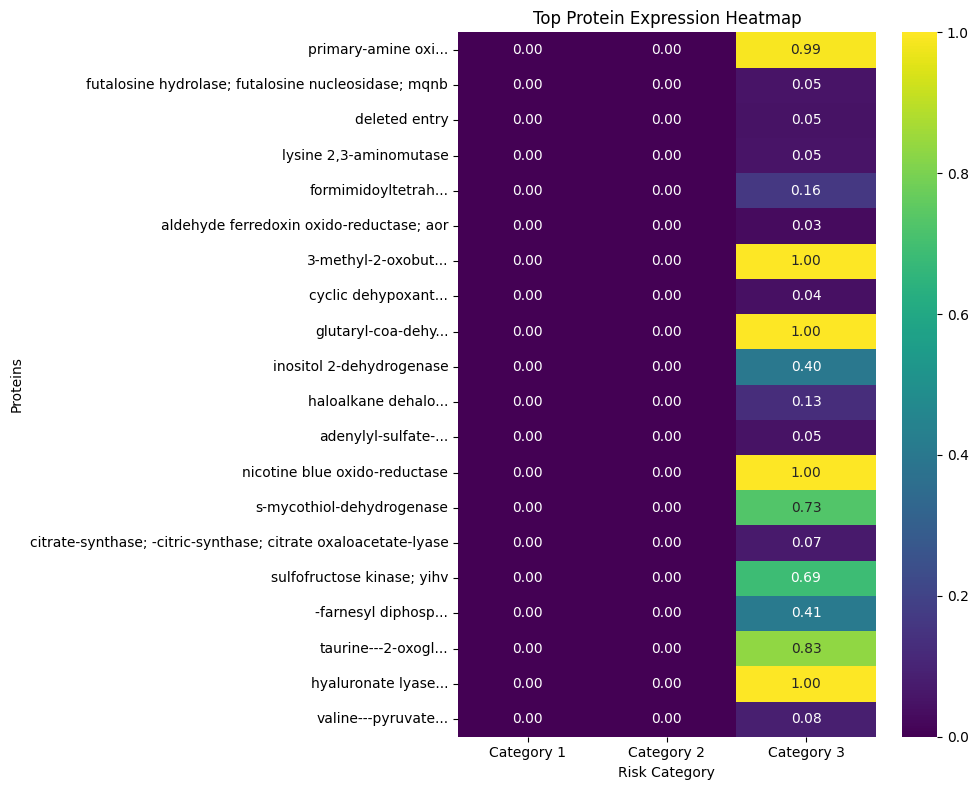

In [516]:
plot_top_protein_heatmap(very_high_specif)
plt.show()

In [571]:
def plot_functional_group_heatmap(classified_results, mechanism_focus=True, top_n=100):
    """
    Create a heatmap grouped by functional categories (mechanisms or pathway classification)

    Parameters:
        classified_results: DataFrame with classified pathways
        mechanism_focus: Whether to focus on mechanisms (True) or pathway classification (False)
        top_n: Number of top pairs to use (default: 100)

    Returns:
        matplotlib figure
    """
    # Get top markers
    top_markers = classified_results.head(top_n)

    if mechanism_focus and 'corrosion_mechanisms' in top_markers.columns:
        # Extract all mechanisms
        all_mechanisms = set()
        for mechs in top_markers['corrosion_mechanisms'].dropna():
            if isinstance(mechs, str):
                all_mechanisms.update([m.strip() for m in mechs.split(';')])

        # Create a matrix: rows=genera, columns=mechanisms
        genera = top_markers['Genus'].unique()
        mechanisms = sorted(list(all_mechanisms))

        matrix = np.zeros((len(genera), len(mechanisms)))

        # Fill matrix with counts
        for i, genus in enumerate(genera):
            genus_markers = top_markers[top_markers['Genus'] == genus]

            for _, row in genus_markers.iterrows():
                if pd.notna(row['corrosion_mechanisms']) and isinstance(row['corrosion_mechanisms'], str):
                    marker_mechanisms = [m.strip() for m in row['corrosion_mechanisms'].split(';')]
                    for mechanism in marker_mechanisms:
                        if mechanism in mechanisms:
                            j = mechanisms.index(mechanism)
                            matrix[i, j] += 1

        # Plot
        plt.figure(figsize=(4, 5))

        # Use a better colormap for mechanisms
        cmap = LinearSegmentedColormap.from_list('corrosion', ['#FFFFFF', '#FF9966', '#CC3300'])

        ax = sns.heatmap(matrix, cmap=cmap, linewidths=0.5, linecolor='gray',
                      xticklabels=mechanisms, yticklabels=genera)

        plt.title('Genus-Mechanism Relationship (Count of Proteins)')
        plt.xlabel('Corrosion Mechanism')
        plt.ylabel('Genus')
        plt.xticks(rotation=45, ha='right')

    else:
        # Use pathway classification
        if 'pathway_classification' not in top_markers.columns:
            return None

        # Create a matrix: rows=genera, columns=classifications
        genera = top_markers['Genus'].unique()
        classifications = ['universal', 'mixed', 'niche-specific']

        matrix = np.zeros((len(genera), len(classifications)))

        # Fill matrix with counts
        for i, genus in enumerate(genera):
            genus_markers = top_markers[top_markers['Genus'] == genus]

            for classification in classifications:
                j = classifications.index(classification)
                count = sum(genus_markers['pathway_classification'] == classification)
                matrix[i, j] = count

        # Plot
        #plt.figure(figsize=(12, 10))
        cmap = LinearSegmentedColormap.from_list('pathways', ['#FFFFFF', '#66CCFF', '#003366'])

        ax = sns.heatmap(matrix, cmap=cmap, linewidths=0.5, linecolor='gray',
                      xticklabels=classifications, yticklabels=genera)

        plt.title('Genus-Pathway Classification Relationship (Count of Proteins)')
        plt.xlabel('Pathway Classification')
        plt.ylabel('Genus')

    #plt.tight_layout()
    return plt.gcf()

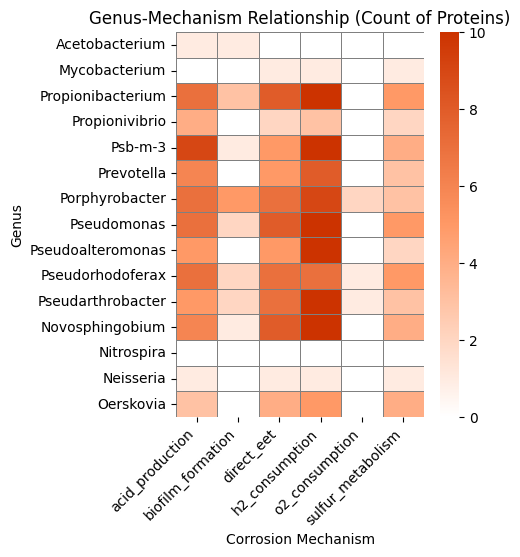

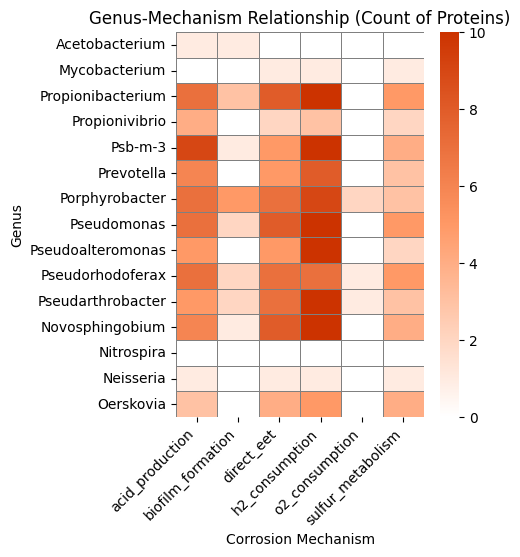

In [ ]:
plot_functional_group_heatmap(high_confidence, mechanism_focus=True, top_n=100)

In [ ]:
def create_sunburst_chart(data_frame, category=3, output_file='pathway_sunburst.html'):
    """
    Create a sunburst chart showing hierarchical representation of pathways
    for a specific risk category.

    Parameters: data_frame classified_results
    category : int Risk category to visualize (1, 2, or 3)
    output_file : str file name to save the interactive HTML plot
    """
    # Filter data to significant pathways
    sig_df = data_frame[data_frame['significant'] == True].copy(deep=False)

    # Prepare data for sunburst chart
    sunburst_data = []

    for _, row in sig_df.iterrows():
        # Extract hierarchy levels - assuming hierarchy is in path format
        hierarchy = row['hierarchy']
        if not isinstance(hierarchy, str) or not hierarchy:
            hierarchy = "Unclassified"

        # Split hierarchy path
        hierarchy_levels = hierarchy.split('/')
        levels = []

        # Build all path components
        for i in range(len(hierarchy_levels)):
            levels.append('/'.join(hierarchy_levels[:i+1]))

        # Calculate abundance value
        abundance = row[f'mean_{category}']

        # Add the full path with the value
        sunburst_data.append({
            'id': '/'.join(hierarchy_levels),
            'parent': '/'.join(hierarchy_levels[:-1]) if len(hierarchy_levels) > 1 else '',
            'labels': hierarchy_levels[-1],
            'values': abundance,
            'genus': row['Genus'],
            'protein': row['protein_name'],
            'corrosion_relevance': row['corrosion_relevance'],
            'pathway_classification': row['pathway_classification'] if 'pathway_classification' in row else 'Unknown'
        })

        # Add all parent paths
        for i in range(len(hierarchy_levels)-1, 0, -1):
            parent_path = '/'.join(hierarchy_levels[:i])
            path = '/'.join(hierarchy_levels[:i+1])

            # Check if this parent path is already in data
            if not any(d['id'] == path for d in sunburst_data):
                sunburst_data.append({
                    'id': path,
                    'parent': parent_path if i > 1 else '',
                    'labels': hierarchy_levels[i],
                    'values': abundance,  # This will get summed up in plotly
                    'genus': '',
                    'protein': '',
                    'corrosion_relevance': '',
                    'pathway_classification': ''
                })

        # Add the root node if needed
        if len(hierarchy_levels) > 0 and not any(d['id'] == hierarchy_levels[0] for d in sunburst_data):
            sunburst_data.append({
                'id': hierarchy_levels[0],
                'parent': '',
                'labels': hierarchy_levels[0],
                'values': abundance,
                'genus': '',
                'protein': '',
                'corrosion_relevance': '',
                'pathway_classification': ''
            })

    # Convert to DataFrame
    sunburst_df = pd.DataFrame(sunburst_data)

    # Create the sunburst chart with Plotly
    fig = px.sunburst(
        sunburst_df,
        ids='id',
        parents='parent',
        names='labels',
        values='values',
        color='values',
        hover_data=['genus', 'protein', 'corrosion_relevance', 'pathway_classification'],
        color_continuous_scale='Viridis',
        title=f'Hierarchical Pathway Distribution for Category {category}'
    )

    # Update layout
    fig.update_layout(
        width=900,
        height=900,
        margin=dict(t=50, l=0, r=0, b=10)
    )

    # Save to HTML file
    pio.write_html(fig, file=output_file, auto_open=True)

    return fig

# Example usage:
create_sunburst_chart(classified_results, category=3, output_file='pathway_sunburst_cat3.html')

In [ ]:
def create_network_graph(data_frame, n_top=15, threshold=0.5, category=3):
    """
    Create a network graph showing relationships between genera, pathways, and corrosion mechanisms.
    Parameters: data_frame : pandas DataFrame prioritized_markers DataFrame
    n_top : int   Number of top genera-pathway combinations to include
    threshold : float  Minimum combined_score to include (0-1)
    category : int  Risk category to visualize (1, 2, or 3)
    """
    # Filter data
    filtered_df = data_frame[
        (data_frame['combined_score'] >= threshold) &
        (data_frame[f'mean_{category}'] > 0)
    ].sort_values('combined_score', ascending=False).head(n_top)

    # Create a graph
    G = nx.Graph()

    # Add nodes and edges
    for _, row in filtered_df.iterrows():
        genus = row['Genus']
        protein = row['protein_name'][:20] + '...' if len(row['protein_name']) > 20 else row['protein_name']

        # Process corrosion mechanisms
        mechanisms = row['corrosion_mechanisms']
        if isinstance(mechanisms, str):
            if '[' in mechanisms:
                mechanisms = eval(mechanisms)
            elif ',' in mechanisms:
                mechanisms = [m.strip() for m in mechanisms.split(',')]
            else:
                mechanisms = [mechanisms]

        # Add nodes if they don't exist
        if not G.has_node(genus):
            G.add_node(genus, type='genus',
                      abundance=row[f'mean_{category}'],
                      corr_score=row['corr'])

        if not G.has_node(protein):
            G.add_node(protein, type='protein',
                      score=row['combined_score'],
                      hierarchy=row['hierarchy'].split('/')[0] if isinstance(row['hierarchy'], str) else 'Unknown')

        # Add edge between genus and protein
        G.add_edge(genus, protein, weight=row[f'mean_{category}'])

        # Add mechanism nodes and edges
        for mech in mechanisms:
            if mech and isinstance(mech, str):
                if not G.has_node(mech):
                    G.add_node(mech, type='mechanism')

                # Connect mechanism to protein
                G.add_edge(protein, mech, weight=1)

    # Set up the plot
    plt.figure(figsize=(16, 12))

    # Set positions using spring layout
    pos = nx.spring_layout(G, k=0.5, iterations=50, seed=42)

    # Prepare node colors by type
    node_colors = []
    node_sizes = []
    node_alphas = []

    for node in G.nodes():
        if G.nodes[node]['type'] == 'genus':
            # Color genera by correlation score (red for positive, blue for negative)
            corr = G.nodes[node]['corr_score']
            if corr > 0:
                color = (1, 0, 0, min(1, abs(corr)))  # Red with alpha based on correlation strength
            else:
                color = (0, 0, 1, min(1, abs(corr)))  # Blue with alpha based on correlation strength
            node_colors.append(color)
            node_sizes.append(300 + G.nodes[node]['abundance'] * 100)
            node_alphas.append(min(1, abs(corr)))

        elif G.nodes[node]['type'] == 'protein':
            # Color proteins by hierarchy
            hierarchy = G.nodes[node]['hierarchy']
            # Create a deterministic color based on hierarchy string
            h_hash = sum([ord(c) for c in hierarchy]) % 100 / 100.0
            color = plt.cm.tab20(h_hash)
            node_colors.append(color)
            node_sizes.append(200 + G.nodes[node]['score'] * 300)
            node_alphas.append(G.nodes[node]['score'])

        elif G.nodes[node]['type'] == 'mechanism':
            # Use a distinct color for mechanisms
            node_colors.append('green')
            node_sizes.append(150)
            node_alphas.append(0.8)

    # Get edge weights for width
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
    max_weight = max(edge_weights)
    normalized_weights = [w/max_weight * 3 for w in edge_weights]

    # Draw the network
    nodes = nx.draw_networkx_nodes(
        G, pos,
        node_color=node_colors,
        node_size=node_sizes,
        alpha=0.8
    )

    edges = nx.draw_networkx_edges(
        G, pos,
        width=normalized_weights,
        alpha=0.6,
        edge_color='gray'
    )

    labels = nx.draw_networkx_labels(
        G, pos,
        font_size=10,
        font_weight='bold'
    )

    # Add legend
    genus_patch = mpatches.Patch(color='lightcoral', label='Genus (red=positive corr, blue=negative)')
    protein_patch = mpatches.Patch(color='lightblue', label='Protein (color=hierarchy)')
    mech_patch = mpatches.Patch(color='lightgreen', label='Corrosion Mechanism')
    plt.legend(handles=[genus_patch, protein_patch, mech_patch], loc='upper left', bbox_to_anchor=(1, 1))

    # Add title
    plt.title(f'Network of Genera, Proteins, and Corrosion Mechanisms for Category {category}', fontsize=14)

    # Remove axis
    plt.axis('off')

    # Adjust layout
    plt.tight_layout()
    plt.savefig(f'network_graph_cat{category}.png', dpi=300, bbox_inches='tight')
    plt.show()

    return G
classified_results= complete_results['classified_results']
prioritized_markers = complete_results['prioritized_markers']
# Example usage:
create_network_graph(prioritized_markers, n_top=15, threshold=0.5, category=3)

# 6. Metal Involvement by Genus across Risk Categories
The plot_metal_involvement function creates a heatmap showing the relationship between bacterial genera and the specific metals they interact with, weighted by the combined score from your prioritized markers.

In [ ]:
def plot_metal_involvement(prioritized_markers):
    """
    Creates a heatmap showing metal involvement by genus across risk categories,
    using the actual metal names from your data.
    """
    # Process metal involvement data
    metal_data = []

    for _, row in prioritized_markers.iterrows():
        if isinstance(row['metals_involved'], str) and row['metals_involved']:
            # Use the correct delimiter based on your data format (comma or semicolon)
            metals = [m.strip() for m in row['metals_involved'].split(';')]
            for metal in metals:
                metal_data.append({
                    'Genus': row['Genus'],
                    'metal': metal,  # Keep the original metal name
                    'Category 1': row['mean_cat1'],
                    'Category 2': row['mean_cat2'],
                    'Category 3': row['mean_cat3'],
                    'combined_score': row['combined_score']
                })

    # Convert to DataFrame
    metal_df = pd.DataFrame(metal_data)

    # Group by genus and metal
    grouped = metal_df.groupby(['Genus', 'metal']).agg({
        'Category 1': 'mean',
        'Category 2': 'mean',
        'Category 3': 'mean',
        'combined_score': 'mean'
    }).reset_index()

    # Create a pivot table for the heatmap
    pivot = grouped.pivot_table(
        index='Genus',
        columns='metal',
        values='combined_score',
        aggfunc='mean'
    ).fillna(0)

    # Sort by sum of values
    pivot = pivot.loc[pivot.sum(axis=1).sort_values(ascending=False).index]
    pivot = pivot[pivot.sum().sort_values(ascending=False).index]

    # Set up the plot
    plt.figure(figsize=(14, 10))

    # Create heatmap - using a mask for zero values to make them white
    mask = pivot == 0
    sns.heatmap(
        pivot,
        cmap='YlOrRd',
        linewidths=0.5,
        cbar_kws={'label': 'Combined Score'},
        mask=mask
    )

    plt.title('Metal Involvement by Genus', fontsize=16)
    plt.xticks(rotation=45, ha='right')
    # Print a simple dictionary of the metals for reference
    #metal_list = sorted(metal_df['metal'].unique())

    return plt.gcf()
plot_metal_involvement(high_confidence)
plt.tight_layout()

### Top Markers by Score -
Bar chart showing the highest scoring markers



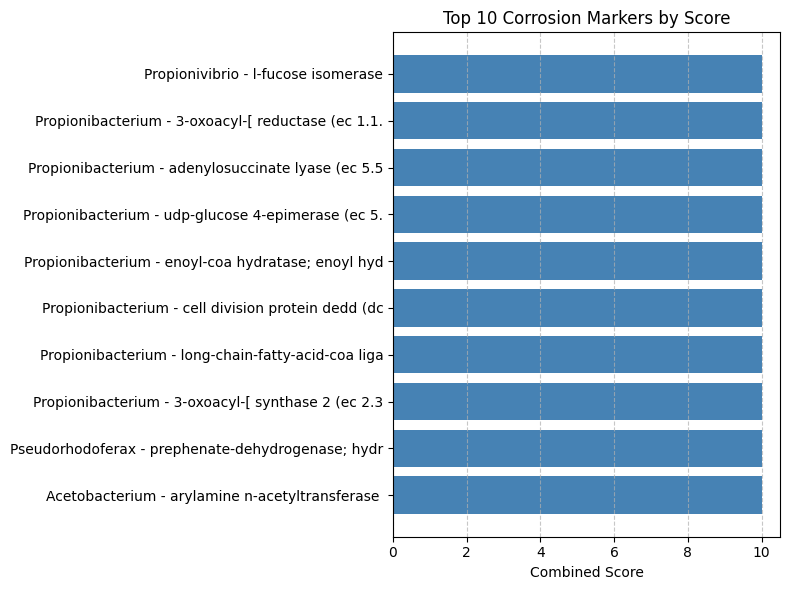

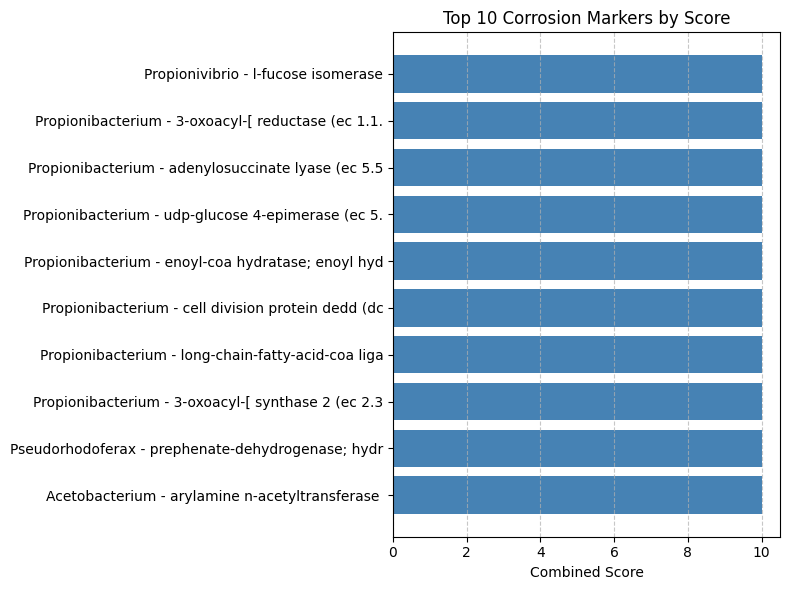

In [92]:
def plot_top_markers_by_score(prioritized_markers, top_n=20, figsize=(8, 6)):
    """
    Create a horizontal bar chart of top markers by score
    """
    # Get top markers
    top_markers = prioritized_markers.head(top_n)

    # Create labels
    labels = [f"{row['Genus']} - {row['protein_name'][:30]}"
              for _, row in top_markers.iterrows()]

    # Create figure
    plt.figure(figsize=figsize)

    # Plot horizontal bars
    plt.barh(range(len(labels)), top_markers['combined_score'], color='steelblue')

    # Add labels and title
    plt.yticks(range(len(labels)), labels)
    plt.xlabel('Combined Score')
    plt.title(f'Top {top_n} Corrosion Markers by Score')
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    plt.tight_layout()
    return plt.gcf()

plot_top_markers_by_score(top_markers, top_n=10, figsize=(8, 6))

### Genus-Mechanism Heatmap
Shows relationships between top genera and corrosion mechanisms

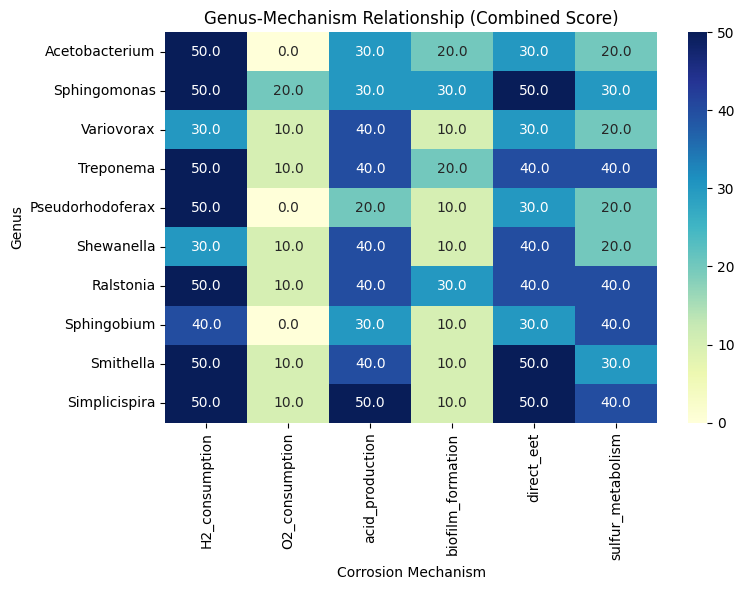

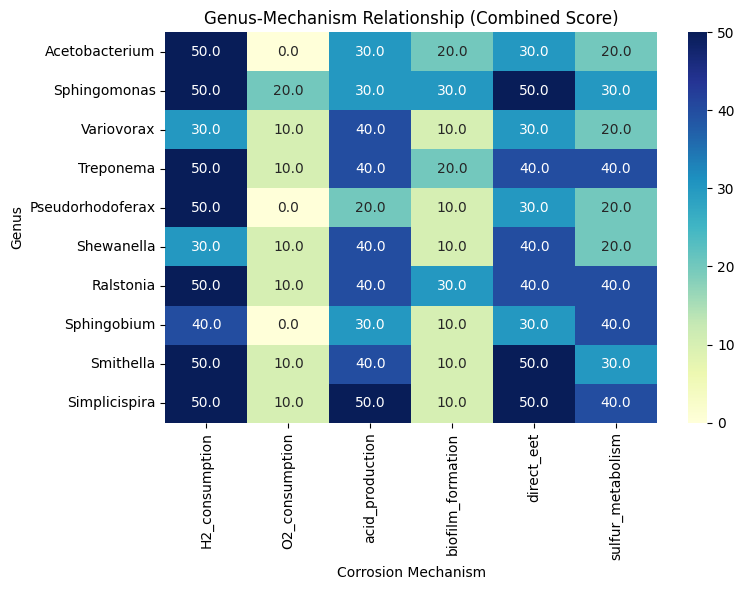

In [93]:
def plot_genus_mechanism_heatmap(prioritized_markers, top_genera=10, top_markers_per_genus=5, figsize=None):
    """
    Create a heatmap showing top genera and their corrosion mechanisms
    """
    # Ensure corrosion_mechanisms column exists
    if 'corrosion_mechanisms' not in prioritized_markers.columns:
        raise ValueError("DataFrame must contain 'corrosion_mechanisms' column")

    # Get top genera
    top_genera_list = prioritized_markers['Genus'].value_counts().head(top_genera).index.tolist()

    # Filter for top genera
    genus_df = prioritized_markers[prioritized_markers['Genus'].isin(top_genera_list)].copy(deep=False)

    # Get top markers per genus
    top_markers = []
    for genus in top_genera_list:
        genus_markers = genus_df[genus_df['Genus'] == genus].head(top_markers_per_genus)
        top_markers.append(genus_markers)

    top_markers_df = pd.concat(top_markers)

    # Extract all unique mechanisms
    all_mechanisms = set()
    for mechs in top_markers_df['corrosion_mechanisms'].dropna():
        if isinstance(mechs, str):
            all_mechanisms.update([m.strip() for m in mechs.split(';')])

    all_mechanisms = sorted(list(all_mechanisms))

    # Create matrix for heatmap (genus x mechanism)
    heatmap_data = np.zeros((len(top_genera_list), len(all_mechanisms)))

    # Fill matrix with scores
    for i, genus in enumerate(top_genera_list):
        genus_markers = top_markers_df[top_markers_df['Genus'] == genus]

        for _, row in genus_markers.iterrows():
            if pd.notna(row['corrosion_mechanisms']):
                mechanisms = [m.strip() for m in row['corrosion_mechanisms'].split(';')]
                score = row['combined_score']

                for mechanism in mechanisms:
                    if mechanism in all_mechanisms:
                        j = all_mechanisms.index(mechanism)
                        heatmap_data[i, j] += score

    # Create heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='YlGnBu',
                xticklabels=all_mechanisms, yticklabels=top_genera_list)

    plt.title('Genus-Mechanism Relationship (Combined Score)')
    plt.ylabel('Genus')
    plt.xlabel('Corrosion Mechanism')
    plt.tight_layout()

    return plt.gcf()

plot_genus_mechanism_heatmap(top_markers, top_genera=10, top_markers_per_genus=5, figsize=(8, 6))

### Abundance Across Categories
Line plots showing how abundance changes across corrosion categories

In [ ]:
def plot_abundance_across_categories(prioritized_markers, top_n=5, figsize=None):
    """
    Plot abundance patterns across corrosion categories for top markers
    """
    # Get mean columns
    mean_cols = [col for col in prioritized_markers.columns if col.startswith('mean_')]

    if not mean_cols:
        raise ValueError("No mean abundance columns found (should start with 'mean_')")

    # Get top markers
    top_markers = prioritized_markers.head(top_n)

    # Extract category numbers from column names
    categories = [col.replace('mean_', '') for col in mean_cols]

    # Create figure
    plt.figure(figsize=figsize)

    # Plot abundance patterns for each marker
    for i, (_, row) in enumerate(top_markers.iterrows()):
        label = f"{row['Genus']} - {row['protein_name'][:20]}"
        values = [row[col] for col in mean_cols]
        plt.plot(categories, values, marker='o', linewidth=2, label=label)

    # Add labels and title
    plt.xlabel('Corrosion Category')
    plt.ylabel('Mean Abundance')
    plt.title(f'Abundance Patterns Across Corrosion Categories (Top {top_n} Markers)')
    plt.grid(linestyle='--', alpha=0.7)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    return plt.gcf()

plot_abundance_across_categories(high_confidence, top_n=5, figsize=(8, 6))

### Pathway Classification Breakdown
Shows distribution of universal vs niche-specific pathways



In [ ]:
def plot_pathway_classification_breakdown(prioritized_markers, figsize=(8, 6)):
    """
    Create pie and bar charts showing pathway classification breakdown
    """
    if 'pathway_classification' not in prioritized_markers.columns:
        raise ValueError("DataFrame must contain 'pathway_classification' column")

    # Count pathway classifications
    class_counts = prioritized_markers['pathway_classification'].value_counts()

    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    # Pie chart
    ax1.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%',
           shadow=True, startangle=90, colors=['#ff9999','#66b3ff','#99ff99'])
    ax1.set_title('Pathway Classification Distribution')

    # Bar chart
    ax2.bar(class_counts.index, class_counts.values, color=['#ff9999','#66b3ff','#99ff99'])
    ax2.set_title('Pathway Classification Counts')
    ax2.set_ylabel('Count')

    #plt.tight_layout()
    return fig

plot_pathway_classification_breakdown(top_results figsize=(12, 8))

In [ ]:
def prepare_genera_pca(base_matrix, category_mapping=None):
    """
    Prepare genera data for PCA with handling of multi-index categories

    Parameters: base_matrix : pandas.DataFrame, Matrix with multi-index (Sites, Category)
                category_mapping : pandas.Series,  Category mapping

    Returns:    X_pca : numpy.ndarray, PCA transformed data
                explained_variance_ratio : numpy.ndarray  Explained variance ratios
                loadings : pandas.DataFrame, PCA loadings
                categories : pandas.Series,  Categories for each site
    """
    # Extract categories if they're in the multi-index
    if isinstance(base_matrix.index, pd.MultiIndex):
        categories = base_matrix.index.get_level_values('Category')
        # No need to drop category as it's in the index
        X = base_matrix
    else:
        # Use provided category mapping or None
        categories = category_mapping
        X = base_matrix

    # No need for iloc[1:] as we don't have enzyme names as first row anymore
    X_for_scaling = X.astype(float)

    # Standardize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_for_scaling)

    # PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    # Create loadings DataFrame with proper multi-index columns
    loadings = pd.DataFrame(
        pca.components_.T,
        index=X.columns,  # preserving multi-index columns (Genus, protein_name)
        columns=['PC1', 'PC2']
    )

    return X_pca, pca.explained_variance_ratio_, loadings, categories
def plot_pca_results(X_pca, explained_variance, Category, title, category_colors, categories_labels,
                     pc1_idx=0, pc2_idx=1):  # Add parameters for component indices
    """
    Plot PCA with risk categories

    Parameters:
    -----------
    X_pca : numpy array   PCA transformed data
    explained_variance : numpy array        Explained variance ratios
    Category : array-like  Category labels for each sample
    title : str   Plot title
    category_colors : dict  Mapping of categories to colors
    categories_labels : dict  Mapping of categories to display labels
    pc1_idx : int        Index of the first PC to plot (default 0 for PC1)
    pc2_idx : int        Index of the second PC to plot (default 1 for PC2)
    """
    plt.figure(figsize=(10, 8))

    # Plot using specified components
    for category in sorted(set(Category)):
        mask = Category == category
        plt.scatter(
            X_pca[mask, pc1_idx],  # Specified PC for x-axis
            X_pca[mask, pc2_idx],  # Specified PC for y-axis
            c=category_colors[category],
            label=categories_labels[category],
            alpha=0.7,
            s=100
        )

    plt.xlabel(f'PC{pc1_idx+1} ({explained_variance[pc1_idx]:.1%} variance explained)')
    plt.ylabel(f'PC{pc2_idx+1} ({explained_variance[pc2_idx]:.1%} variance explained)')
    plt.title(title)
    plt.legend(title='Risk Category')
    plt.tight_layout()
    plt.show()


def prepare_flexible_pca(data_matrix, categories=None, n_components=None):
    """
    Prepare PCA with flexible number of components

    Parameters:
    -----------
    data_matrix : pandas DataFrame   Input data with samples as rows and features as columns
    categories : array-like,   Category labels for each sample
    n_components : int,   Number of components to calculate (None for all possible)
    n_plot : int   Number of components to return for plotting

    Returns:
    --------
    X_pca : numpy array   PCA transformed data (first n_plot components)
    explained_variance : numpy array  Explained variance ratios for all components
    loadings : pandas DataFrame  PCA loadings with feature names as index
    """
    # Standardize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(data_matrix)

    # PCA
    pca = PCA(n_components=n_components)
    X_pca_full = pca.fit_transform(X_scaled)

    # Get loadings for all components
    loadings = pd.DataFrame(
        pca.components_.T,
        index=data_matrix.columns,
        columns=[f'PC{i+1}' for i in range(pca.n_components_)]
    )

    # Return only requested components for plotting
    X_pca = X_pca_full

    # Return all calculated components
    return X_pca_full, pca.explained_variance_ratio_, loadings

# Calculate PCA with all components
X_pca_all, var_ratio_all, loadings_all = prepare_flexible_pca(base_matrix)

# Plot different component combinations
# PC1 vs PC2 (default)
plot_pca_results(X_pca_all, var_ratio_all, categories.values, "PC1 vs PC2",
                 category_colors, categories_labels)

# PC2 vs PC3
plot_pca_results(X_pca_all, var_ratio_all, categories.values, "PC2 vs PC3",
                 category_colors, categories_labels,
                 pc1_idx=1, pc2_idx=2)

# PC3 vs PC4
plot_pca_results(X_pca_all, var_ratio_all, categories.values, "PC3 vs PC4",
                 category_colors, categories_labels,
                 pc1_idx=2, pc2_idx=3)

## Adapting for Source Groups

## 9.5 Retrieving Statistically Significant Groups

From notebook 3_Feature_selection the file finalist.xlsx contain the groups worked and that were statistically significant in relation to the risk label. This groups posses interest since the relationship to the label could show better understanding in contrast with the different groups of known bacteria, core taxa, checked bacteria and the mixed groups.
The idea is to understand if the core taxa which make up a large influence on the comunities on the water and cooling systems are also influencing corrosion.


In [ ]:
source_groups = {
    "known_bacteria": known_bacteria_list,
    "pure_checked": pure_checked_list,
    "pure_core": pure_core_list,
    "checked_core": checked_core_list
}

Influencers_uniques_path = base_dir / "finalist_dfs.xlsx"
# Integrated taxa from origin genus as headers with levels 6 for the genera, 7 for the GID, muss be cleaned
Influencers_uniques = pd.read_excel(Influencers_uniques_path, sheet_name='Influencers_uniques', header=[0,1,2,3,4,5,6,7], engine ='openpyxl')
# Drop first row (index 0) and first column in one chain
Influencers_uniques = Influencers_uniques.drop(index=0)
Influencers_uniques = Influencers_uniques.drop(Influencers_uniques.columns[0], axis=1)
Influencers_uniques = Influencers_uniques.astype({'Sites': str})
# Remove 'Unnamed' level names
Influencers_uniques.columns = Influencers_uniques.columns.map(lambda x: tuple('' if "Unnamed" in str(level) else level for level in x))
Influencers_uniques_list= Influencers_uniques.columns.get_level_values(6)
Influencers_uniques_list= Influencers_uniques_list[Influencers_uniques_list !='']

### Updating the groups to visualise
source_groups = {
    "known_bacteria": known_bacteria_list,
    "pure_checked": pure_checked_list,
    "pure_core": pure_core_list,
    "checked_core": checked_core_list,
    "Influencers_uniques": Influencers_uniques_list,
}

In [ ]:
# Suppose known_bacteria_list is our list of genera
group_cols_known = [col for col in base_matrix.columns if col[0] in known_bacteria_list]
base_matrix_known = base_matrix.loc[:, group_cols_known]

plot_top_proteins_across_categories(
    base_matrix_known,
    categories=[1,2,3],
    n_top=5,
    n_genera=10,
    category_level=1
)

# 10. Pathways Analysis

## 10.1. Pathways distribution by Risk Category

In [ ]:
def prepare_pathway_pca(metabolic_info, use_col='Pathways'):
    """
    Convert pathway strings to numeric features for PCA

    Parameters:
    -----------
    metabolic_info : pandas.DataFrame,   DataFrame with 'Pathways' column containing comma-separated pathway strings

    Returns:
    --------
    X_pca : numpy.ndarray,    PCA transformed data
    explained_variance_ratio : numpy.ndarray,     Explained variance ratios
    loadings : pandas.DataFrame,   PCA loadings with pathway names as index
    pathway_matrix : pandas.Dataframe,  Binary matrix of pathway presence/absence (useful for further analysis)
    """
    # Handle NaN values first
    valid_data = metabolic_info[metabolic_info[use_col].notna()]

    # Create set of unique items with explicit string handling
    all_items = set()
    for item_str in valid_data[use_col]:
        if isinstance(item_str, str):  # Ensure it's a string
            items = [i.strip() for i in item_str.strip('[]').split(',') if i.strip()]
            all_items.update(items)

    # Create binary matrix with explicit index preservation
    data_dict = {}
    original_index = metabolic_info.index

    for item in all_items:
        if item:  # Skip empty strings
            item_escaped = re.escape(item)
            data_dict[item] = metabolic_info[use_col].str.contains(
                item_escaped,
                regex=True,
                na=False
            ).astype(int)

    data_matrix = pd.DataFrame(data_dict, index=original_index)

    # Print debug info
    print(f"Created matrix with {data_matrix.shape[1]} features")
    print(f"Non-zero entries: {data_matrix.astype(bool).sum().sum()}")

    # Run PCA with explicit scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(data_matrix)
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    loadings = pd.DataFrame(
        pca.components_.T,
        index=data_matrix.columns,
        columns=['PC1', 'PC2']
    )

    return X_pca, pca.explained_variance_ratio_, loadings, data_matrix

def plot_metabolic_pca_results(X_pca, explained_variance, metabolic_sites_info, category_dict, title, category_colors, categories_labels):
    """
    Plot PCA results for pathways with risk categories

    Parameters:     X_pca : numpy array  PCA transformed coordinates
                    explained_variance : numpy array   Explained variance ratios
                    metabolic_info : pandas DataFrame   The metabolic info DataFrame with Sites index
                    category_dict : dict     Mapping of sites to categories
    """
    plt.figure(figsize=(10, 8))

    # Get categories for each site in metabolic_info
    if isinstance(metabolic_sites_info.index, pd.MultiIndex):
        Sites = metabolic_sites_info.index.get_level_values('Sites')
    else:
        Sites = metabolic_sites_info.index

    plot_categories = pd.Series(Sites).map(category_dict)

    # Plot each category
    for category in sorted(set(plot_categories)):
        mask = plot_categories == category
        plt.scatter( X_pca[mask, 0], X_pca[mask, 1], c=category_colors[category],
            label=categories_labels[category], alpha=0.7, s=100)

    plt.xlabel(f'PC1 ({explained_variance[0]:.1%} variance explained)')
    plt.ylabel(f'PC2 ({explained_variance[1]:.1%} variance explained)')
    plt.title(title)
    plt.legend(title='Risk Category')
    plt.tight_layout()
    plt.show()
# For pathway PCA
X_pca_path, var_ratio_path, loadings_path, pathway_matrix = prepare_pathway_pca(metabolic_sites_info, use_col='Pathways')

plot_metabolic_pca_results( X_pca_path, var_ratio_path,  metabolic_sites_info, category_dict, "Pathways PCA by Risk Category", category_colors, categories_labels)

## 10.2. Top Pathways Loadings by Category

In [ ]:
def plot_pca_loadings_heatmap(loadings, top_n=20):
    """Plot a heatmap of pathway loadings for PC1 and PC2.
       Parameters:     loadings: DataFrame with PCA loadings
       top_n: Number of top pathways to display     """
    plt.figure(figsize=(10, 8))
    # Select top pathways based on absolute contribution to PC1 and PC2
    top_pathways = (loadings[['PC1', 'PC2']].abs().sum(axis=1).nlargest(top_n).index)
    # Filter the loadings dataframe
    heatmap_data = loadings.loc[top_pathways, ['PC1', 'PC2']]
    sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', center=0)
    plt.title('Top Pathway Contributions to PC1 and PC2')
    plt.xlabel('Principal Components')
    plt.ylabel('Pathways')
    plt.tight_layout()
    plt.show()

plot_pca_loadings_heatmap(loadings_genera)

## 10.3. Pathways patterns by source groups

|Sites|---|site_1|site_1|site_1|site_2|site_2|site_2|site_2|
|---|---|---|---|---|---|---|---|---|
|Genus|---|genus_1|genus_2|genus3|genus_2|genus_70|genus_154|genus_520|
|Pathways|---|---|---|---|---|---|---|---|
|pathway_1|---|---|---|---|---|---|---|---|
|pathway_2|---|---|---|---|---|---|---|---|


In [ ]:
def analyze_bacterial_groups(base_matrix, metabolic_sites_info, source_groups):
    """
    Analyze relationships between bacterial groups and functional patterns.

    Parameters:
    - base_matrix: DataFrame with sites and functional data.
      (Columns are multi-indexed (Site, Genus) or similar structure.)
    - metabolic_sites_info: DataFrame with site-genus level information.
    - source_groups: dict with group names as keys and list of genera as values.

    Returns:
    - results: dict with analysis results for each group.
    """
    results = {}

    for source_name, genus_list in source_groups.items():

        # Filter columns where the first level (e.g., site or genus) is in the group list.
        group_cols = [col for col in base_matrix.columns if col[0] in genus_list]
        group_data = base_matrix.loc[:, group_cols]

        # Standardize the data
        scaler = MinMaxScaler() # Changing from standard scaler to robustscaler
        scaled_data = scaler.fit_transform(group_data)

        # PCA analysis
        pca = PCA(n_components=5)
        pca_result = pca.fit_transform(scaled_data)

        print("\nPCA Variance Explained:")
        for i, var in enumerate(pca.explained_variance_ratio_):
            print(f"PC{i+1}: {var:.2%}")
        print(f"Total variance explained: {sum(pca.explained_variance_ratio_):.2%}")

        # UMAP analysis
        reducer = umap.UMAP(random_state=42)
        umap_result = reducer.fit_transform(scaled_data)

        # Save results for current group
        results[source_name] = {
            'pca': pca_result,
            'umap': umap_result,
            'pca_explained': pca.explained_variance_ratio_,
            'data': group_data
        }

        # Plottinextract categories from base_matrix index if available.
        try:
            categories = base_matrix.index.get_level_values('Category')
        except (KeyError, AttributeError):
            # If no 'Category' level, assign a default category (e.g., all 1)
            categories = pd.Series(np.ones(group_data.shape[0]), index=group_data.index)

        # PCA plot
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        for cat in sorted(set(categories)):
            mask = categories == cat
            ax1.scatter(pca_result[mask, 0],
                        pca_result[mask, 1],
                        c=category_colors.get(cat, '#000000'),
                        label=categories_labels.get(cat, f'Cat {cat}'),
                        alpha=0.7)
        ax1.set_title(f'PCA - {source_name}')
        ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
        ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
        ax1.legend()

        # UMAP plot
        for cat in sorted(set(categories)):
            mask = categories == cat
            ax2.scatter(umap_result[mask, 0],
                        umap_result[mask, 1],
                        c=category_colors.get(cat, '#000000'),
                        label=categories_labels.get(cat, f'Cat {cat}'),
                        alpha=0.7)
        ax2.set_title(f'UMAP - {source_name}')
        ax2.set_xlabel('UMAP 1')
        ax2.set_ylabel('UMAP 2')
        ax2.legend()

        plt.tight_layout()
        plt.show()

        # PCA Explained Variance plot
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
                 np.cumsum(pca.explained_variance_ratio_), 'bo-')
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Explained Variance Ratio')
        plt.title(f'PCA Explained Variance - {source_name}')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return results


In [ ]:
print(f"{known_bacteria}: group_data.shape = {group_data.shape}")


In [ ]:
known_bacteria_list = ['Clostridium', 'Corynebacterium', 'Novosphingobium', 'Streptococcus', 'Thiobacillus', 'Acetobacterium', 'Bacillus', 'Desulfotomaculum', 'Desulfovibrio', 'Micrococcus', 'Propionibacterium',
 'Pseudomonas', 'Staphylococcus', 'Desulfobacterium', 'Desulfobulbus', 'Gallionella', 'Shewanella']

group_cols_known = [col for col in base_matrix.columns if col[0] in known_bacteria_list]
group_data_known = base_matrix.loc[:, group_cols_known]

group_data_known.head()

In [ ]:
print(group_data_known.head(), group_data_known.shape)

In [ ]:
for gname, glist in source_groups.items():
    group_cols = [col for col in base_matrix.columns if col[0] in glist]
    tmp_data = base_matrix.loc[:, group_cols]
    print(gname, tmp_data.shape)


In [ ]:
corr_matrix = group_data_known.corr()
corr_matrix

In [ ]:
corr_matrix

## Bacterial Groups Analysis Component

In [ ]:
def analyze_combined_groups(base_matrix, source_groups, group_names=['checked_core', 'Influencers_uniques']):
    """
    Analyze combined bacterial groups while preserving their individual contributions.

    Parameters:
    - base_matrix: DataFrame with sites and functional data
    - source_groups: dict with group names as keys and list of genera as values
    - group_names: list of group names to combine

    Returns:
    - Combined analysis results including PCA, UMAP and variance explained
    """
    # Filter for selected groups
    selected_genera = []
    for group in group_names:
        selected_genera.extend(source_groups[group])

    # Remove duplicates while preserving order
    selected_genera = list(dict.fromkeys(selected_genera))

    # Filter columns for selected genera
    group_cols = [col for col in base_matrix.columns if col[0] in selected_genera]
    combined_data = base_matrix.loc[:, group_cols]

    # Remove zero columns
    combined_data = combined_data.loc[:, (combined_data != 0).any(axis=0)]

    # Standardize
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(combined_data)

    # PCA
    pca = PCA(n_components=3)
    pca_result = pca.fit_transform(scaled_data)

    # UMAP
    reducer = umap.UMAP(random_state=42)
    umap_result = reducer.fit_transform(scaled_data)

    results = {
        'pca': pca_result,
        'umap': umap_result,
        'pca_explained': pca.explained_variance_ratio_,
        'data': combined_data,
        'genera': selected_genera
    }

    # Plottinextract categories from base_matrix index if available.
    try:
        categories = base_matrix.index.get_level_values('Category')
    except (KeyError, AttributeError):
        # If no 'Category' level, assign a default category (e.g., all 1)
        categories = pd.Series(np.ones(combined_data.shape[0]), index=combined_data.index)

    # PCA plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    for cat in sorted(set(categories)):
        mask = categories == cat
        ax1.scatter(pca_result[mask, 0],
                    pca_result[mask, 1],
                    c=category_colors.get(cat, '#000000'),
                    label=categories_labels.get(cat, f'Cat {cat}'),
                    alpha=0.7)
    ax1.set_title(f'PCA - {combined_data}')
    ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    ax1.legend()

    # UMAP plot
    for cat in sorted(set(categories)):
        mask = categories == cat
        ax2.scatter(umap_result[mask, 0],
                    umap_result[mask, 1],
                    c=category_colors.get(cat, '#000000'),
                    label=categories_labels.get(cat, f'Cat {cat}'),
                    alpha=0.7)
    ax2.set_title(f'UMAP - {group_names}')
    ax2.set_xlabel('UMAP 1')
    ax2.set_ylabel('UMAP 2')
    ax2.legend()

    plt.tight_layout()
    plt.show()

    # PCA Explained Variance plot
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
              np.cumsum(pca.explained_variance_ratio_), 'bo-')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title(f'PCA Explained Variance - {group_names}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return results

In [ ]:
results = analyze_combined_groups(base_matrix, source_groups, group_names=['checked_core', 'Influencers_uniques'])

In [ ]:
from scipy import stats
from statsmodels.stats.multitest import multipletests

In [ ]:
def analyze_category_enrichment(base_matrix, category_dict, source_groups):
    """
    Analyze pathway enrichment within each risk category.
    Uses relative abundance and statistical testing to identify
    significantly enriched proteins in each category.
    """
    # Get the sites and categories from the MultiIndex
    sites_categories = pd.Series(
        base_matrix.index.get_level_values('Category'),
        index=base_matrix.index.get_level_values('Sites')
    )

    def get_enrichment_for_group(group_data, category):
        # Get data for this category
        cat_mask = group_data.index.get_level_values("Category")  == category
        cat_data = group_data[cat_mask]
        other_data= group_data[~cat_mask]

        # Calculate mean abundances
        cat_means = cat_data.mean()
        other_means = other_data.mean()

        # Calculate fold change
        fold_change = np.log2(cat_means / other_means)

        # Perform statistical test (Mann-Whitney U)
        pvalues = []
        for col in group_data.columns:
            stat, pval = stats.mannwhitneyu(
                cat_data[col],
                other_data[col],
                alternative='greater'
            )
            pvalues.append(pval)

        # Create results DataFrame
        results = pd.DataFrame({
            'fold_change': fold_change,
            'pvalue': pvalues,
            'mean_abundance': cat_means
        })

        # Add multiple testing correction
        results['padj'] = multipletests(results['pvalue'], method='fdr_bh')[1]

        return results

    enrichment_results = {}

    # Analyze each source group
    for group_name, genera in source_groups.items():
        print(f"\nAnalyzing {group_name}...")

        # Filter for genera in this group
        group_cols = [col for col in base_matrix.columns if col[0] in genera]
        if not group_cols:
            continue

        group_data = base_matrix[group_cols]

        # Get enrichment for each category
        group_results = {}
        for cat in [1, 2, 3]:
            results = get_enrichment_for_group(group_data, cat)
            group_results[cat] = results

        enrichment_results[group_name] = group_results

        # Plot volcano plots for each category
        plt.figure(figsize=(15, 5))
        plt.suptitle(f"Protein Enrichment Analysis - {group_name}", y=1.05)

        for i, cat in enumerate([1, 2, 3], 1):
            results = group_results[cat]

            plt.subplot(1, 3, i)

            # Create volcano plot
            plt.scatter(
                results['fold_change'],
                -np.log10(results['padj']),
                alpha=0.6,
                c=category_colors[cat],
                s= results['mean_abundance']*1000
            )

            # Add significance lines
            plt.axhline(-np.log10(0.05), color='red', linestyle='--', alpha=0.3)
            plt.axvline(0, color='black', linestyle='--', alpha=0.3)

            plt.title(f"{categories_labels[cat]}")
            plt.xlabel("Log2 Fold Change")
            plt.ylabel("-log10(adjusted p-value)")

        plt.tight_layout()
        plt.show()

        # Print top enriched proteins
        for cat in [1, 2, 3]:
            results = group_results[cat]
            significant = results[results['padj'] < 0.05].sort_values('fold_change', ascending=False)

            print(f"\nTop enriched proteins in {categories_labels[cat]} for {group_name}:")
            if len(significant) > 0:
                print(significant.head(10))
            else:
                print("No significantly enriched proteins found")

    return enrichment_results

# Run the analysis
enrichment_results = analyze_category_enrichment(base_matrix, category_dict, source_groups)

In [ ]:
def create_comparison_table(enrichment_results):
    """
    Create a structured comparison table from enrichment results
    """
    # Create empty list to store rows
    comparison_rows = []

    for group_name, group_results in enrichment_results.items():
        for category in [1, 2, 3]:
            if category in group_results:
                results = group_results[category]
                significant = results[results['padj'] < 0.05]

                if len(significant) > 0:
                    for idx, row in significant.head(10).iterrows():
                        comparison_rows.append({
                            'Group': group_name,
                            'Category': categories_labels[category],
                            'Genus': idx[0],
                            'Protein': idx[1],
                            'Fold_Change': row['fold_change'],
                            'Padj': row['padj'],
                            'Mean_Abundance': row['mean_abundance']
                        })

    # Create DataFrame
    comparison_df = pd.DataFrame(comparison_rows)

    # Save to CSV with proper formatting
    comparison_df.to_csv('enrichment_comparison.csv', index=False)

    return comparison_df

# Create comparison table
comparison_table = create_comparison_table(enrichment_results)

# Display formatted table
print("\nComparison Table Preview:")
print(comparison_table.to_string())

__________________________________

https://www.youtube.com/watch?v=jQVNsyAnDMo

https://microreact.org/



In [ ]:
def create_integrated_visualization(df, results, metadata=None):
    """
    Create an integrated visualization combining PCA, clustering, and metadata

    Parameters:
    df: Original pathway data
    results: Results from explore_pathway_patterns
    metadata: DataFrame with risk labels, materials, etc.
    """
    fig = plt.figure(figsize=(15, 10))

    # 1. PCA with clustering
    pca_data = results['pca']['components']
    clusters = results['clustering'][5]['kmeans']  # Using k=5 clusters

    plt.subplot(2, 2, 1)
    scatter = plt.scatter(pca_data[:, 0], pca_data[:, 1],
                         c=clusters, cmap='Set2', alpha=0.6)
    plt.title('PCA Components with Clusters')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.colorbar(scatter, label='Cluster')

    # 2. Top pathway contributions
    plt.subplot(2, 2, 2)
    top_loadings = abs(results['pca']['loadings']['PC1']).nlargest(10)
    sns.barplot(x=top_loadings.values, y=top_loadings.index)
    plt.title('Top 10 Pathways Contributing to PC1')
    plt.xlabel('Absolute Loading')

    # 3. Correlation structure summary
    plt.subplot(2, 2, 3)
    corr_summary = results['correlation'].abs().mean()
    sns.histplot(corr_summary, bins=50)
    plt.title('Distribution of Mean Correlation Strengths')
    plt.xlabel('Mean |Correlation|')

    plt.tight_layout()
    return fig

In [ ]:
create_integrated_visualization(base_matrix, results_patterns, metadata=None)

## 9.3 Analysing Pathways Organic Fate

Now the task is to identify the most abundant pathways in the samples, focusing specifically on organic matter-related metabolism. Ultimately creating visualizations to understand pathway distributions and analyze correlations between pathways.

In [ ]:
def analyze_metabolic_pathways(df):
    """
    Analyze metabolic pathways from PICRUSt output

    Parameters:
    df: pandas DataFrame with pathways as index and samples as columns
    """
    # Calculate mean abundance across samples for each pathway
    mean_abundance = df.mean(axis=1).sort_values(ascending=False)

    # Get top 20 most abundant pathways
    top_pathways = mean_abundance.head(20)

    # Create heatmap of top pathways across samples
    plt.figure(figsize=(15, 8))
    sns.heatmap(df.loc[top_pathways.index],
                cmap='YlOrRd',
                center=0,
                robust=True,
                xticklabels=True,
                yticklabels=True)
    plt.title('Top 20 Most Abundant Pathways Across Samples')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Filter for organic matter metabolism related pathways
    organic_terms = ['carbon', 'carbohydrate', 'lipid', 'fatty acid',
                    'organic acid', 'amino acid', 'degradation']

    organic_pathways = df.index[df.index.str.lower().str.contains('|'.join(organic_terms))]
    organic_data = df.loc[organic_pathways]

    # Calculate summary statistics for organic matter pathways
    pathway_stats = pd.DataFrame({
        'mean_abundance': organic_data.mean(axis=1),
        'std_abundance': organic_data.std(axis=1),
        'cv': organic_data.std(axis=1) / organic_data.mean(axis=1) * 100
    }).sort_values('mean_abundance', ascending=False)

    return pathway_stats, organic_data

def plot_pathway_distribution(pathway_stats):
    """Plot distribution of pathway abundances"""
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=pathway_stats.reset_index(),
                x='mean_abundance',
                y='index',
                order=pathway_stats.index[:15])
    plt.title('Top 15 Organic Matter Related Pathways')
    plt.xlabel('Mean Abundance')
    plt.tight_layout()
    plt.show()

# Calling the function
stats, organic_data = analyze_metabolic_pathways(Picrust_Result)
plot_pathway_distribution(stats)

In [ ]:
def analyze_pathway_patterns(df):
    """
    Analyze pathway patterns using sites vs pathways abundances
    """
    # Create the correct matrix: sites vs pathways with abundances
    pathway_matrix = df.pivot_table(
        values='norm_abund_contri',
        index='Sites',          # Sites as rows
        columns='Pathways',     # Pathways as columns
        aggfunc='sum',          # Sum abundances
        fill_value=0
    )

    print("Matrix shape:", pathway_matrix.shape)

    # Standardize data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(pathway_matrix)

    # PCA
    pca = PCA(n_components=5)
    X_pca = pca.fit_transform(scaled_data)

    # UMAP
    reducer = umap.UMAP(random_state=42)
    umap_result = reducer.fit_transform(scaled_data)

    # Get categories for sites
    categories = pd.Series(pathway_matrix.index).map(lambda x: category_dict[x])

    # Plot both PCA and UMAP
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # PCA explained variance
    ax1.plot(range(1, 6), pca.explained_variance_ratio_, 'bo-')
    print("\nPCA Variance Explained:")
    print(f"Total (5 components): {sum(pca.explained_variance_ratio_):.2%}")
    ax1.set_title('PCA Explained Variance')
    ax1.set_xlabel('Component')
    ax1.set_ylabel('Explained Variance Ratio')

    # PCA scatter
    for cat in category_colors.keys():
        mask = categories == cat
        ax2.scatter(X_pca[mask, 0],
                   X_pca[mask, 1],
                   c=category_colors[cat],
                   label=categories_labels[cat],
                   alpha=0.7)

    ax2.set_title('PCA First Two Components')
    ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    ax2.legend()
    plt.tight_layout()
    plt.show()

    # UMAP plot
    plt.figure(figsize=(12, 8))
    for cat in category_colors.keys():
        mask = categories == cat
        plt.scatter(umap_result[mask, 0],
                   umap_result[mask, 1],
                   c=category_colors[cat],
                   label=categories_labels[cat],
                   alpha=0.7)

    plt.title('UMAP Projection of Pathways')
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.legend()
    plt.show()

# Run the analysis
results = analyze_pathway_patterns(metabolic_sites_info)

In [ ]:
# To analyze specific pathways of interest:
def analyze_specific_pathways(df, pathway_list):
    """
    Analyze specific pathways of interest

    Parameters:
    df: DataFrame with pathway data
    pathway_list: list of pathway names to analyze
    """
    specific_data = df.loc[df.index.str.contains('|'.join(pathway_list), case=False)]

    # Create correlation matrix for these pathways
    corr = specific_data.T.corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation between Selected Pathways')
    plt.tight_layout()
    plt.show()

    return specific_data.describe()

# Calling the funtion
Description = analyze_specific_pathways(Picrust_Result, Picrust_Result.index.tolist())

## 9.4. Pathways Relevant to Corrosion
This code witll categorise pathways into key groups: sulfur metabolism (critical for sulfate-reducing bacteria), Metal-related pathways (iron, manganese, etc.); organic acid production (which can influence local pH); biofilm formation (important for corrosion processes) and electron transfer mechanisms. Then it would analyse correlations between these different categories to understand potential synergistic effects, identifying the most abundant pathways in each category

In [ ]:
def analyze_corrosion_pathways(df):
    """
    Analyze pathways relevant to microbially influenced corrosion (MIC)

    Parameters:
    df: pandas DataFrame with pathways as index and samples as columns
    """
    # Define relevant pathway terms for different corrosion mechanisms
    pathway_categories = {
        'sulfur': ['sulfur', 'sulfate', 'sulfide', 'thiosulfate', 'sulfite', 'sulfonate'],
        'metal': ['iron', 'metal', 'Fe', 'manganese', 'chromium', 'nickel'],
        'organic_acid': ['organic acid', 'acetate', 'formate', 'lactate', 'pyruvate'],
        'biofilm': ['biofilm', 'exopolysaccharide', 'EPS', 'adhesion'],
        'electron_transfer': ['cytochrome', 'electron transport', 'oxidoreductase']
    }

    # Function to filter pathways by category
    def get_category_pathways(terms):
        return df.index[df.index.str.lower().str.contains('|'.join(terms), regex=True)]

    # Analyze each category
    category_data = {}
    category_stats = {}

    for category, terms in pathway_categories.items():
        pathways = get_category_pathways(terms)
        if len(pathways) > 0:
            category_data[category] = df.loc[pathways]
            category_stats[category] = pd.DataFrame({
                'mean_abundance': category_data[category].mean(axis=1),
                'std_abundance': category_data[category].std(axis=1),
                'cv': category_data[category].std(axis=1) / category_data[category].mean(axis=1) * 100
            }).sort_values('mean_abundance', ascending=False)

    return category_data, category_stats

def plot_corrosion_pathways(category_data, category_stats):
    """
    Create visualizations for corrosion-related pathways
    """
    # Plot top pathways for each category
    for category, data in category_stats.items():
        if len(data) > 0:
            plt.figure(figsize=(12, min(6, max(3, len(data)*0.3))))
            sns.barplot(data=data.head(10).reset_index(),
                       x='mean_abundance',
                       y='index',
                       palette='YlOrRd')
            plt.title(f'Top {min(10, len(data))} {category.replace("_", " ").title()} Related Pathways')
            plt.xlabel('Mean Abundance')
            plt.ylabel('Pathway')
            plt.tight_layout()
            plt.show()

    # Create correlation heatmap between categories
    category_means = pd.DataFrame({
        cat: data.mean(axis=1) for cat, data in category_data.items()
    })

    plt.figure(figsize=(10, 8))
    sns.heatmap(category_means.corr(),
                annot=True,
                cmap='coolwarm',
                center=0,
                vmin=-1,
                vmax=1)
    plt.title('Correlation between Pathway Categories')
    plt.tight_layout()
    plt.show()

def analyze_pathway_interactions(df, category_data):
    """
    Analyze interactions between different pathway categories
    """
    # Calculate mean abundance for each category
    category_abundances = pd.DataFrame({
        category: data.mean(axis=0)
        for category, data in category_data.items()
    })

    # Calculate correlations between categories
    correlations = category_abundances.corr()

    # Identify potential synergistic relationships
    high_correlations = correlations.unstack()
    high_correlations = high_correlations[high_correlations != 1.0]
    high_correlations = high_correlations[abs(high_correlations) > 0.5]

    return category_abundances, correlations, high_correlations.sort_values(ascending=False)

# Analysing Corrosion Pathways
category_data, category_stats = analyze_corrosion_pathways(Picrust_Result)
plot_corrosion_pathways(category_data, category_stats)
abundances, correlations, high_corr = analyze_pathway_interactions(Picrust_Result, category_data)

## 9.5. Heating and Cooling Systems Pathway Analysis
Creating independent analyses:

Failure analysis (based on human assessment/estimation)
Microbiological analysis (16S rRNA)
Physicochemical parameters


Using physicochemical parameters as labels/indicators of corrosion state - this is quite clever because it gives us an objective measure without directly mixing in the biological data
Then planning to correlate the microbial communities with these states through machine learning

And now to use PICRUSt's functional predictions to validate our assumptions about organic matter metabolism. It can help confirm if the bacteria identified through correlations actually have the metabolic capacity to influence corrosion
It might reveal unexpected metabolic pathways that could explain the correlations. The following script will Validate our organic matter assumptions by:

Breaking down different types of organic matter processing
Looking at both degradation and synthesis pathways
Identifying transport mechanisms

Connect with our physicochemical parameters by analyzing pathways that could influence:

pH modulation
Temperature response
Metal interactions

In [ ]:
def analyze_system_pathways(df):
    """
    Analyze pathways relevant to heating/cooling system corrosion

    Parameters:
    df: pandas DataFrame with pathways as index and samples as columns
    """
    # Define pathway categories relevant to system conditions
    pathway_categories = {
        # Water chemistry influence
        'ph_modulation': ['acid', 'alkaline', 'proton pump', 'pH homeostasis'],

        # Temperature adaptation
        'temp_response': ['heat shock', 'cold shock', 'temperature response'],

        # Organic matter processing
        'carbon_metabolism': [
            'carbon fixation', 'carbon utilization',
            'organic acid', 'fatty acid',
            'carbohydrate metabolism'
        ],

        # Corrosion-related
        'metal_interaction': [
            'iron', 'metal', 'oxidation-reduction',
            'electron transport', 'metal binding'
        ],

        # Biofilm formation
        'surface_attachment': [
            'biofilm', 'adhesion', 'exopolysaccharide',
            'extracellular matrix'
        ]
    }

    # Filter and analyze pathways
    def get_category_pathways(terms):
        return df.index[df.index.str.lower().str.contains('|'.join(terms), regex=True)]

    category_data = {}
    category_stats = {}

    for category, terms in pathway_categories.items():
        pathways = get_category_pathways(terms)
        if len(pathways) > 0:
            category_data[category] = df.loc[pathways]

            # Calculate basic statistics
            category_stats[category] = pd.DataFrame({
                'mean_abundance': category_data[category].mean(axis=1),
                'std_abundance': category_data[category].std(axis=1),
                'cv': category_data[category].std(axis=1) / category_data[category].mean(axis=1) * 100,
                'presence': (category_data[category] > 0).mean(axis=1) * 100  # % of samples with pathway
            }).sort_values('mean_abundance', ascending=False)

    return category_data, category_stats

def analyze_organic_matter_pathways(df):
    """
    Detailed analysis of organic matter related pathways
    """
    # Specific organic matter categories
    organic_categories = {
        'degradation': ['degradation', 'breakdown', 'catabolism'],
        'synthesis': ['biosynthesis', 'anabolism', 'synthesis'],
        'transport': ['transport', 'uptake', 'export'],
        'modification': ['modification', 'conversion', 'transformation']
    }

    organic_data = {}

    for category, terms in organic_categories.items():
        pathways = df.index[df.index.str.lower().str.contains(
            '|'.join(terms), regex=True
        ) & df.index.str.lower().str.contains(
            'organic|carbon|fatty acid|lipid|protein|amino acid'
        )]
        if len(pathways) > 0:
            organic_data[category] = df.loc[pathways]

    return organic_data

def plot_pathway_distributions(category_stats, category_data):
    """
    Create visualizations for pathway distributions
    """
    for category, stats in category_stats.items():
        if len(stats) > 0:
            # Create subplot with dual axis
            fig, ax1 = plt.subplots(figsize=(12, min(8, max(4, len(stats)*0.3))))
            ax2 = ax1.twinx()

            # Plot mean abundance
            sns.barplot(data=stats.head(10).reset_index(),
                       x='mean_abundance',
                       y='index',
                       color='skyblue',
                       ax=ax1)

            # Plot presence percentage
            stats.head(10)['presence'].plot(
                marker='o',
                color='red',
                ax=ax2
            )

            ax1.set_title(f'{category.replace("_", " ").title()} Pathways')
            ax1.set_xlabel('Mean Abundance')
            ax2.set_xlabel('Presence (%)')

            plt.tight_layout()
            plt.show()

# Calling the analysis
category_data, category_stats = analyze_system_pathways(Picrust_Result)
organic_data = analyze_organic_matter_pathways(Picrust_Result)
plot_pathway_distributions(category_stats, category_data)

I have a big gap on the cation anion account and then used mackensy, 2012 method from the usgs to check ec measured Vs calculated and cation Vs ions. It is a big gap still, but I have a lot of OM so I could no assume as normally that OM is CH4 so I attribute it to small organic acids and put acetate and oxalate as OM representatives, I have a small study of small acids form on failure analysis and also report of a mass that has a magnetic consistency, so I infere that those muss be some organic metalic compound but only accounted for AC- and Ox-2, I thought better to chose this other compounds Fe rich but I don't know how to do it actually. So in my bacteria I actually found lots of them with Ac- metabolism whiles I was looking at the families I realise no only oxobacter accendants, but others similar, also got important biofilm formers, there is also halogen related and should be, big deal of difference make the material and location cause water treatment, unfortunately the annotations are no to be taken as parameters but can serve as annotations

validate assumptions about:

Organic acid presence (by showing metabolic capability)
Metal-organic complex formation (through siderophore and metal-binding pathways)
Biofilm formation potential (which can influence local chemistry)

Validate acetate/oxalate assumptions by showing if these metabolic pathways are actually present
Look for other potential organic acid pathways might want to consider
Identify metal-organic interaction pathways that could explain magnetic mass observation

In [ ]:
def analyze_organic_metal_pathways(df):
    """
    Analyze pathways related to organic acid metabolism and metal interactions

    Parameters:
    df: pandas DataFrame with pathways as index and samples as columns
    """
    # Define specific pathway categories
    pathway_categories = {
        'organic_acid_metabolism': [
            'acetate', 'acetic acid', 'acetyl',
            'oxalate', 'oxalic acid',
            'organic acid', 'fatty acid',
            'carboxylic acid'
        ],

        'metal_organic_interaction': [
            'siderophore', 'metal binding',
            'iron complex', 'metal transport',
            'metallophore', 'metal organic'
        ],

        'biofilm_formation': [
            'biofilm', 'exopolysaccharide',
            'extracellular matrix', 'adhesion'
        ],

        'halogen_related': [
            'halogen', 'chloride', 'bromide',
            'halide', 'dehalogenation'
        ]
    }

    # Analyze each category
    def get_category_pathways(terms):
        return df.index[df.index.str.lower().str.contains('|'.join(terms), regex=True)]

    pathway_data = {}
    pathway_stats = {}

    for category, terms in pathway_categories.items():
        pathways = get_category_pathways(terms)
        if len(pathways) > 0:
            pathway_data[category] = df.loc[pathways]

            # Calculate comprehensive statistics
            pathway_stats[category] = pd.DataFrame({
                'mean_abundance': pathway_data[category].mean(axis=1),
                'std_abundance': pathway_data[category].std(axis=1),
                'cv': pathway_data[category].std(axis=1) / pathway_data[category].mean(axis=1) * 100,
                'presence': (pathway_data[category] > 0).mean(axis=1) * 100,  # % of samples with pathway
                'relative_abundance': pathway_data[category].mean(axis=1) / df.mean(axis=1).mean() * 100
            }).sort_values('mean_abundance', ascending=False)

    return pathway_data, pathway_stats

def analyze_pathway_relationships(pathway_data):
    """
    Analyze relationships between different pathway categories
    """
    # Calculate mean abundance for each category across samples
    category_means = pd.DataFrame({
        category: data.mean(axis=0)
        for category, data in pathway_data.items()
    })

    # Calculate correlations
    correlations = category_means.corr()

    # Identify potential functional relationships
    high_correlations = correlations.unstack()
    high_correlations = high_correlations[high_correlations != 1.0]
    high_correlations = high_correlations[abs(high_correlations) > 0.5]

    return category_means, correlations, high_correlations.sort_values(ascending=False)

def plot_pathway_analysis(pathway_stats, pathway_data):
    """
    Create visualizations for pathway analysis
    """
    for category, stats in pathway_stats.items():
        if len(stats) > 0:
            # Create subplot with dual axis
            fig, ax1 = plt.subplots(figsize=(12, min(8, max(4, len(stats)*0.3))))
            ax2 = ax1.twinx()

            # Plot abundance and relative abundance
            sns.barplot(data=stats.head(10).reset_index(),
                       x='relative_abundance',
                       y='index',
                       color='skyblue',
                       ax=ax1)

            stats.head(10)['presence'].plot(
                marker='o',
                color='red',
                ax=ax2
            )

            ax1.set_title(f'{category.replace("_", " ").title()} Pathways')
            ax1.set_xlabel('Relative Abundance (%)')
            ax2.set_xlabel('Presence (%)')

            plt.tight_layout()
            plt.show()

# calling the function
pathway_data, pathway_stats = analyze_organic_metal_pathways(Picrust_Result)category_means, correlations, high_corr = analyze_pathway_relationships(pathway_data)
plot_pathway_analysis(pathway_stats, pathway_data)

## 9.6. Corrosion Relevant Pathways

Focus on corrosion-relevant pathways by categorizing them into:

Organic acid metabolism (relevant to our acetate/oxalate observations)
Sulfur metabolism
Metal interactions
Biofilm formation


Handle the high-dimensional data by:

Using dimensionality reduction (PCA)
Calculating summary statistics
Visualizing key patterns


Address our specific interests:

Organic matter metabolism pathways
Metal-organic interactions
Correlations with physicochemical parameters

In [ ]:
def analyze_corrosion_pathways(df):
    """
    Analyze pathways relevant to microbially influenced corrosion
    """
    # Define pathway categories relevant to corrosion
    pathway_categories = {
        'organic_acid': [
            'CENTFERM-PWY',  # Central fermentation pathways
            'FERMENTATION-PWY',  # Mixed acid fermentation
            'GLYCOLYSIS',  # Glucose fermentation
            'PWY-5100',  # Pyruvate fermentation
            'GALACTUROCAT-PWY'  # Galacturonate degradation
        ],
        'sulfur': [
            'PWY-6932',  # Sulfate reduction
            'SO4ASSIM-PWY',  # Sulfate assimilation
            'SULFATE-CYS-PWY'  # Sulfate to cysteine
        ],
        'metal_interaction': [
            'PWY-7219',  # Iron oxidation
            'PWY-7221',  # Iron reduction
            'HEME-BIOSYNTHESIS-II',  # Iron-containing compounds
            'P125-PWY'  # Metal resistance
        ],
        'biofilm': [
            'COLANSYN-PWY',  # Colanic acid (biofilm)
            'EXOPOLYSACC-PWY',  # Exopolysaccharide
            'GLUCOSE1PMETAB-PWY'  # UDP-glucose synthesis
        ]
    }

    # Extract relevant pathways and their abundances
    relevant_pathways = {}
    for category, pathways in pathway_categories.items():
        category_data = df[df.index.isin(pathways)]
        if not category_data.empty:
            relevant_pathways[category] = category_data

    # Calculate summary statistics
    summary_stats = {}
    for category, data in relevant_pathways.items():
        summary_stats[category] = {
            'mean_abundance': data.mean().mean(),
            'std_abundance': data.mean().std(),
            'present_in_samples': (data > 0).mean().mean() * 100,
            'pathways_found': len(data)
        }

    # Dimension reduction for visualization
    if df.shape[0] > 0:
        # Standardize the data
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(df.T)

        # PCA
        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(scaled_data)

        return relevant_pathways, summary_stats, pca_result, pca.explained_variance_ratio_

    return relevant_pathways, summary_stats, None, None

def plot_pathway_analysis(relevant_pathways, summary_stats, pca_result=None, explained_variance=None):
    """
    Create visualizations for pathway analysis
    """
    # Plot mean abundances by category
    plt.figure(figsize=(12, 6))
    categories = list(summary_stats.keys())
    means = [stats['mean_abundance'] for stats in summary_stats.values()]
    presence = [stats['present_in_samples'] for stats in summary_stats.values()]

    ax1 = plt.gca()
    ax2 = ax1.twinx()

    bars = ax1.bar(categories, means, alpha=0.6, color='skyblue')
    ax1.set_ylabel('Mean Abundance')

    line = ax2.plot(categories, presence, 'ro-', label='Presence %')
    ax2.set_ylabel('Presence in Samples (%)')

    plt.title('Pathway Categories Overview')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # If PCA results available, plot them
    if pca_result is not None:
        plt.figure(figsize=(10, 8))
        plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.6)
        plt.xlabel(f'PC1 ({explained_variance[0]*100:.1f}%)')
        plt.ylabel(f'PC2 ({explained_variance[1]*100:.1f}%)')
        plt.title('PCA of Pathway Abundances')
        plt.tight_layout()
        plt.show()

# Calling the functions
relevant_pathways, summary_stats, pca_result, explained_variance = analyze_corrosion_pathways(Picrust_Result)
plot_pathway_analysis(relevant_pathways, summary_stats, pca_result, explained_variance)

## 9.7. Functional Pathway Clustering Analysis
Hierarchical Clustering:

Groups pathways based on their abundance patterns
Creates a dendrogram to visualize relationships
Automatically determines optimal number of clusters


Correlation-based Analysis:

Identifies pathways that behave similarly across samples
Creates correlation heatmap to visualize relationships
Helps identify functional modules


Feature Creation:

Generates new features based on cluster statistics:

Mean abundance per cluster
Total abundance per cluster
Pathway diversity within clusters

Reduce dimensionality while maintaining biological meaning
Identify functional modules that might be working together
Create more robust features for our ML analysis

In [ ]:
def cluster_pathways(df, n_clusters=None, corr_threshold=0.7):
    """
    Cluster pathways based on their functional similarity

    Parameters:
    df: DataFrame with pathways as rows and samples as columns
    n_clusters: Number of clusters (if None, determined automatically)
    corr_threshold: Correlation threshold for considering pathways related
    """
    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df.T).T

    # Calculate correlation matrix
    corr_matrix = np.corrcoef(scaled_data)

    # Create linkage matrix for hierarchical clustering
    linkage_matrix = hierarchy.linkage(pdist(scaled_data), method='ward')

    if n_clusters is None:
        # Automatically determine number of clusters using elbow method
        last = linkage_matrix[-10:, 2]
        acceleration = np.diff(last, 2)
        n_clusters = len(last) - np.argmax(acceleration) + 1

    # Perform clustering
    clustering = AgglomerativeClustering(n_clusters=n_clusters)
    cluster_labels = clustering.fit_predict(scaled_data)

    # Create cluster summary
    cluster_summary = pd.DataFrame({
        'pathway': df.index,
        'cluster': cluster_labels
    })

    return cluster_labels, linkage_matrix, corr_matrix, cluster_summary

def analyze_pathway_clusters(df, cluster_labels):
    """
    Analyze the characteristics of each pathway cluster
    """
    cluster_stats = {}

    for cluster in np.unique(cluster_labels):
        # Get pathways in this cluster
        cluster_paths = df.index[cluster_labels == cluster]
        cluster_data = df.loc[cluster_paths]

        # Calculate statistics
        cluster_stats[cluster] = {
            'size': len(cluster_paths),
            'mean_abundance': cluster_data.mean().mean(),
            'std_abundance': cluster_data.mean().std(),
            'pathways': list(cluster_paths),
            'correlation': np.corrcoef(cluster_data),
            'total_abundance': cluster_data.sum().mean()
        }

    return cluster_stats

def plot_pathway_clusters(df, linkage_matrix, corr_matrix, cluster_labels, cluster_stats):
    """
    Create visualizations for pathway clusters
    """
    # Plot dendrogram
    plt.figure(figsize=(15, 10))
    plt.title('Pathway Clustering Dendrogram')
    hierarchy.dendrogram(linkage_matrix, labels=df.index, leaf_rotation=90)
    plt.tight_layout()
    plt.show()

    # Plot correlation heatmap
    plt.figure(figsize=(12, 12))
    sns.heatmap(pd.DataFrame(corr_matrix, index=df.index, columns=df.index),
                cmap='coolwarm', center=0, vmin=-1, vmax=1)
    plt.title('Pathway Correlation Heatmap')
    plt.tight_layout()
    plt.show()

    # Plot cluster sizes and abundances
    plt.figure(figsize=(12, 6))
    clusters = list(cluster_stats.keys())
    sizes = [stats['size'] for stats in cluster_stats.values()]
    abundances = [stats['mean_abundance'] for stats in cluster_stats.values()]

    ax1 = plt.gca()
    ax2 = ax1.twinx()

    ax1.bar(clusters, sizes, alpha=0.6, color='skyblue')
    ax1.set_ylabel('Number of Pathways')

    ax2.plot(clusters, abundances, 'ro-')
    ax2.set_ylabel('Mean Abundance')

    plt.title('Cluster Sizes and Abundances')
    plt.tight_layout()
    plt.show()

def create_cluster_features(df, cluster_labels):
    """
    Create new features based on pathway clusters
    """
    n_clusters = len(np.unique(cluster_labels))
    cluster_features = pd.DataFrame(index=df.columns)

    for cluster in range(n_clusters):
        # Get pathways in this cluster
        cluster_paths = df.index[cluster_labels == cluster]

        # Calculate mean abundance for cluster
        cluster_features[f'cluster_{cluster}'] = df.loc[cluster_paths].mean()

        # Calculate total abundance for cluster
        cluster_features[f'cluster_{cluster}_total'] = df.loc[cluster_paths].sum()

        # Calculate diversity within cluster
        cluster_features[f'cluster_{cluster}_diversity'] = (df.loc[cluster_paths] > 0).sum()

    return cluster_features

# Calling the fUNCTION
cluster_labels, linkage_matrix, corr_matrix, cluster_summary = cluster_pathways(Picrust_Result)
cluster_stats = analyze_pathway_clusters(Picrust_Result, cluster_labels)
plot_pathway_clusters(Picrust_Result, linkage_matrix, corr_matrix, cluster_labels, cluster_stats)
cluster_features = create_cluster_features(Picrust_Result, cluster_labels)

# 13 Organic Metal Pathways

In [ ]:

def analyze_organic_metal_pathways(df):
    """
    Analyze pathways related to organic acid metabolism and metal interactions

    Parameters:
    df: pandas DataFrame with pathways as index and samples as columns
    """
    # Define specific pathway categories
    pathway_categories = {
        'organic_acid_metabolism': [
            'acetate', 'acetic acid', 'acetyl',
            'oxalate', 'oxalic acid',
            'organic acid', 'fatty acid',
            'carboxylic acid'
        ],

        'metal_organic_interaction': [
            'siderophore', 'metal binding',
            'iron complex', 'metal transport',
            'metallophore', 'metal organic'
        ],

        'biofilm_formation': [
            'biofilm', 'exopolysaccharide',
            'extracellular matrix', 'adhesion'
        ],

        'halogen_related': [
            'halogen', 'chloride', 'bromide',
            'halide', 'dehalogenation'
        ]
    }

    # Analyze each category
    def get_category_pathways(terms):
        return df.index[df.index.str.lower().str.contains('|'.join(terms), regex=True)]

    pathway_data = {}
    pathway_stats = {}

    for category, terms in pathway_categories.items():
        pathways = get_category_pathways(terms)
        if len(pathways) > 0:
            pathway_data[category] = df.loc[pathways]

            # Calculate comprehensive statistics
            pathway_stats[category] = pd.DataFrame({
                'mean_abundance': pathway_data[category].mean(axis=1),
                'std_abundance': pathway_data[category].std(axis=1),
                'cv': pathway_data[category].std(axis=1) / pathway_data[category].mean(axis=1) * 100,
                'presence': (pathway_data[category] > 0).mean(axis=1) * 100,  # % of samples with pathway
                'relative_abundance': pathway_data[category].mean(axis=1) / df.mean(axis=1).mean() * 100
            }).sort_values('mean_abundance', ascending=False)

    return pathway_data, pathway_stats

def analyze_pathway_relationships(pathway_data):
    """
    Analyze relationships between different pathway categories
    """
    # Calculate mean abundance for each category across samples
    category_means = pd.DataFrame({
        category: data.mean(axis=0)
        for category, data in pathway_data.items()
    })

    # Calculate correlations
    correlations = category_means.corr()

    # Identify potential functional relationships
    high_correlations = correlations.unstack()
    high_correlations = high_correlations[high_correlations != 1.0]
    high_correlations = high_correlations[abs(high_correlations) > 0.5]

    return category_means, correlations, high_correlations.sort_values(ascending=False)

def plot_pathway_analysis(pathway_stats, pathway_data):
    """
    Create visualizations for pathway analysis
    """
    for category, stats in pathway_stats.items():
        if len(stats) > 0:
            # Create subplot with dual axis
            fig, ax1 = plt.subplots(figsize=(12, min(8, max(4, len(stats)*0.3))))
            ax2 = ax1.twinx()

            # Plot abundance and relative abundance
            sns.barplot(data=stats.head(10).reset_index(),
                       x='relative_abundance',
                       y='index',
                       color='skyblue',
                       ax=ax1)

            stats.head(10)['presence'].plot(
                marker='o',
                color='red',
                ax=ax2
            )

            ax1.set_title(f'{category.replace("_", " ").title()} Pathways')
            ax1.set_xlabel('Relative Abundance (%)')
            ax2.set_xlabel('Presence (%)')

            plt.tight_layout()
            plt.show()